<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Denmark/VWSDE/VWSDE_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "VWS.DE"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [0]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close  Volume
Date                                                     
2009-01-02  42.00  44.48  41.75  43.55      23.44    4894
2009-01-05  47.09  47.44  45.43  47.10      25.35   11680
2009-01-06  47.20  48.11  45.71  46.75      25.16    9490
2009-01-07  46.99  46.99  43.60  44.13      23.75   12053
2009-01-08  42.60  46.00  39.90  44.81      24.11   18155
...           ...    ...    ...    ...        ...     ...
2018-12-19  68.64  68.64  66.22  67.10      60.78    3862
2018-12-20  66.04  66.96  65.38  65.98      59.77    2705
2018-12-21  66.00  67.10  65.84  67.10      60.78   12826
2018-12-27  68.08  68.14  63.50  64.72      58.62    7763
2018-12-28  66.32  66.34  65.78  66.10      59.87    3938

[2539 rows x 6 columns]

Open         High          Low        Close    Adj Close         Volume
count  2539.000000  2539.000000  2539.000000  2539.000000  2539.000000    2539.000000
mean     38.733226    39.209720    38.148440    38.664545    25.148050   27330.157148
std      22.182540    22.355704    21.993709    22.176315    17.622071   40036.726866
min       3.240000     3.280000     3.130000     3.200000     1.720000       0.000000
25%      20.725000    20.890000    20.315000    20.555000    11.060000    5333.500000
50%      38.900000    39.490000    38.010000    38.730000    20.850000   13183.000000
75%      57.005000    57.750000    55.930000    56.900000    40.080000   32537.000000
max      84.790000    84.790000    83.290000    84.170000    64.480000  468846.000000

7

In [0]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2009-03-13  32.92  33.14  32.40  32.93      17.72    4945   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  32.355886  33.819056 -34.790000  31.847584  32.795679  34.472152      32.500      32.195  34.790000  32.43750  32.280212  32.0320  32.290556  32.43750  32.643333  35.124497               35.484002                 32.43750               29.390998               37.007253                 32.43750               27.867747               38.530504                 32.43750               26.344496               40.053755                 32.43750               24.821245  32.795679  32.550614  34.711882               35.842181                32.795679               29.749177               37.365432                32.795679               28.225926               38.888683                32.795679               26.702675               40.411934                32.795679   
2009-03-16  32.92  34.00  32.40  34.00      18.30    3809   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  32.438092  33.784532  29.090000  32.534053  33.063306  34.466197      32.025      32.195  34.334000  32.31875  33.196307  32.1935  32.637778  32.31875  33.465000  34.784066               35.018591                 32.31875               29.618909               36.368512                 32.31875               28.268988               37.718433                 32.31875               26.919067               39.068354                 32.31875               25.569146  33.063306  33.551949  34.384593               35.763147                33.063306               30.363464               37.113068                33.063306               29.013544               38.462989                33.063306               27.663623               39.812909                33.063306   
2009-03-17  33.55  34.27  32.27  32.43      17.45

Open         High          Low        Close    Adj Close         Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000    2489.000000  2489.000000  2489.000000  2489.000000    2489.000000   2489.000000     2489.000000     2489.000000       2489.000000  2489.000000  2489.000000  2489.000000  2489.000000   2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000  2489.000000  2489.000000  2489.000000             2489.000000              2489.000000             2489.000000             2489.000000              2489.000000             2489.000000             2489.000000   
mean     38.726826    39.196247    38.160422    38.662535    25.234166   27704.830856    15.762555     2.002812   185.324628      30.459221      0.031338        0.028124        0.008437          0.008035     6.595822     2.531137    26.959020     2.002812      2.012455    26.959020    38.637982    38.527396     0.646521    38.661222    38.615009    38.618470    38.579385    38.576943    38.467381    38.614408    38.663754    38.614619    38.630677    38.614408    38.657591    38.525113               40.469138                38.614408               36.759678               41.396503                38.614408               35.832313               42.323868                38.614408               34.904948               43.251233                38.614408               33.977583    38.615009    38.654739    38.537440               40.469739                38.615009               36.760279               41.397104                38.615009               35.832914               42.324469   
std      22.396160    22.570988    22.206446    22.390632    17.784975   40343.417895     8.711079     1.408087   103.325294       0.787286      0.174264        0.165360        0.091484          0.089297     3.387334     1.104259    14.776277     1.408087      1.413448    14.776277    22.325405    22.175814    44.538569    22.403067    22.322226    22.243542    22.299210    22.288112    22.225304    22.337215    22.396488    22.343770    22.349657    22.337215    22.386862    22.234119               23.038647                22.337215               21.707312               23.414203                22.337215               21.421184               23.805287                22.337215               21.155330               24.211145                22.337215               20.910521    22.322226    22.376918    22.249339               23.022951                22.322226               21.693123               23.398187                22.322226               21.407432               23.788970   
min       3.240000     3.280000   

36

In [0]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close  Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2009-03-13  0.363948  0.366335  0.365145  0.367173   0.254939    4945   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.364933  0.384765  0.300300  0.354254  0.369412  0.394336    0.365133    0.362461  0.387705  0.363455  0.359427  0.358506  0.361941  0.363455  0.364521  0.399573                0.387356                 0.363455                0.331906                0.388225                 0.363455                0.316102                0.374463                 0.363455                0.300337                0.362626                 0.363455                0.284614  0.369412  0.363916  0.394126                0.391313                 0.369412                0.336108                0.398697                 0.369412                0.320768                0.387497                 0.369412                0.305493                0.374435                 0.369412   
2009-03-16  0.363948  0.376886  0.365145  0.380388   0.264181    3809   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.365967  0.384325  0.683964  0.362743  0.372774  0.394260    0.359186    0.362461  0.382121  0.361972  0.370744  0.360522  0.366277  0.361972  0.374726  0.395262                0.381719                 0.361972                0.334759                0.380804                 0.361972                0.321117                0.365738                 0.361972                0.307510                0.352779                 0.361972                0.293938  0.372774  0.376367  0.389987                0.390355                 0.372774                0.343830                0.395711                 0.372774                0.330648                0.382802                 0.372774                0.317522                0.368302                 0.372774   
2009-03-17  0.371674  0.380199  0.363523  0.360998   0.2

140860

In [0]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpco3i3g5j
  JVM stdout: /tmp/tmpco3i3g5j/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpco3i3g5j/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 6 days
H2O cluster name:           H2O_from_python_unknownUser_bxkqaj
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_112833_mod...  0.588566  6.097858              0.482171  0.674939  0.455542
1  DeepLearning_grid_1_AutoML_20190825_112833_mod...  0.561628  1.173028              0.487209  0.624391  0.389865
2  DeepLearning_grid_1_AutoML_20190825_112833_mod...  0.549935  2.107752              0.487209  0.702976  0.494175
3  DeepLearning_grid_1_AutoML_20190825_112833_mod...  0.546027  2.023261              0.483333  0.589260  0.347227
4  DeepLearning_grid_1_AutoML_20190825_112833_mod...  0.518282  1.196174              0.482752  0.608602  0.370396
5  DeepLearning_grid_1_AutoML_20190825_112833_mod...  0.500000  0.692544              0.500000  0.499698  0.249699
6  DeepLearning_grid_1_AutoML_20190825_112833_mod...  0.500000  0.692732              0.500000  0.499792  0.249792
7  DeepLearning_grid_1_AutoML_20190825_112833_mod...  0.500000  0.692532              0.500000  0.499693  0.249693
8              DeepLearning_1_AutoML_20190825_112833  0.481137  1.249989              0.500000  0.521802  0.272278
9  DeepLearning_grid_1_AutoML_20190825_112833_mod...  0.463243  0.692855              0.495833  0.499853  0.249853

variable  relative_importance  scaled_importance  percentage
0                   aroonup_20             1.000000           1.000000    0.001044
1     BBANDS_middleband_20_3_4             0.998185           0.998185    0.001042
2                          ADD             0.994006           0.994006    0.001037
3                      NATR_24             0.993339           0.993339    0.001037
4                      MA_24_6             0.990646           0.990646    0.001034
...                        ...                  ...                ...         ...
1040                   MA_20_1             0.844122           0.844122    0.000881
1041                 ROCR100_8             0.843799           0.843799    0.000881
1042    BBANDS_lowerband_8_3_3             0.841115           0.841115    0.000878
1043               MIDPOINT_30             0.838039           0.838039    0.000875
1044    BBANDS_upperband_8_7_4             0.823792           0.823792    0.000860

[1045 rows x 4 columns]

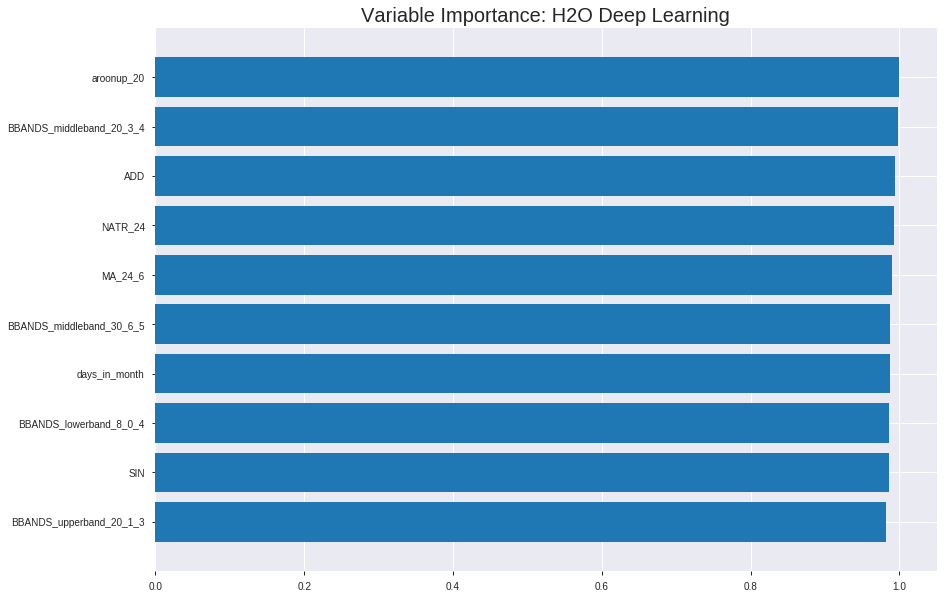

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_112833_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.4253894513492196
RMSE: 0.6522188676734365
LogLoss: 4.499335591899948
Mean Per-Class Error: 0.4386090319855319
AUC: 0.5590735680435098
pr_auc: 0.4439433048742225
Gini: 0.11814713608701966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.9667643326487944e-06: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    855   1        (855.0/855.0)
1      0    886   0        (0.0/886.0)
Total  0    1741  0.4911   (855.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.96676e-06  0.674534  399
max f2                       1.96676e-06  0.838221  399
max f0point5                 1.96676e-06  0.564331  399
max accuracy                 0.998137     0.557725  13
max precision                0.999881     0.615591  2
max recall                   1.96676e-06  1         399
max specificity              0.999996     0.871345  0
max absolute_mcc             0.998137     0.134565  13
max min_per_class_accuracy   0.457174     0.547404  224
max mean_per_class_accuracy  0.998137     0.561391  13

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 49.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   1                  1.52834   1.52834            0.777778         1            0.777778                    1                   0.0158014       0.0158014                  52.8342   52.8342
    2        0.0201034                   1                  0.924711  1.23515            0.470588         1            0.628571                    1                   0.00902935      0.0248307                  -7.52888  23.515
    3        0.0304423                   1                  1.20084   1.2235             0.611111         1            0.622642                    1                   0.0124153       0.037246                   20.084    22.3498
    4        0.0402068                   1                  1.27148   1.23515            0.647059         1            0.628571                    1                   0.0124153       0.0496614                  27.1478   23.515
    5        0.0505457                   1                  1.20084   1.22813            0.611111         1            0.625                       1                   0.0124153       0.0620767                  20.084    22.8132
    6        0.100517                    0.999998           1.26483   1.24638            0.643678         0.999999     0.634286                    1                   0.0632054       0.125282                   26.4835   24.6379
    7        0.150488                    0.999984           1.19708   1.23001            0.609195         0.999993     0.625954                    0.999998            0.0598194       0.185102                   19.7076   23.0007
    8        0.20046                     0.999898           1.10673   1.19928            0.563218         0.999952     0.610315                    0.999986            0.0553047       0.240406                   10.673    19.9276
    9        0.300402                    0.997444           1.20837   1.2023             0.614943         0.999282     0.611855                    0.999752            0.120767        0.361174                   20.8369   20.2301
    10       0.400345                    0.958748           0.959919  1.14179            0.488506         0.985833     0.581062                    0.996277            0.0959368       0.457111                   -4.00807  14.1793
    11       0.500287                    0.455773           0.903453  1.09418            0.45977          0.783766     0.556831                    0.953824            0.0902935       0.547404                   -9.65465  9.41796
    12       0.60023                     0.0103755          0.835694  1.05114            0.425287         0.162548     0.534928                    0.822071            0.0835214       0.630926                   -16.4306  5.114
    13       0.700172                    0.000128338        0.948626  1.03651            0.482759         0.00265484   0.527482                    0.705107            0.0948081       0.725734                   -5.13739  3.65072
    14       0.800115                    5.75677e-07        0.937333  1.02412            0.477011         2.4134e-05   0.521177                    0.617035            0.0936795       0.819413                   -6.2667   2.41193
    15       0.900057                    7.20351e-09        0.971212  1.01824            0.494253         1.31955e-07  0.518188                    0.54852             0.0970655       0.916479                   -2.87875  1.82445
    16       1                           3.1258e-20         0.835694  1                  0.425287         1.30525e



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4844539901811585
RMSE: 0.6960272912617425
LogLoss: 11.79311050885808
Mean Per-Class Error: 0.4810452556630125
AUC: 0.5049001404653115
pr_auc: 0.485224611237662
Gini: 0.009800280930623018
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.7643916080151852e-60: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    241  1        (241.0/241.0)
1      0    257  0        (0.0/257.0)
Total  0    498  0.4839   (241.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       1.76439e-60  0.680795   183
max f2                       1.76439e-60  0.842071   183
max f0point5                 1.76439e-60  0.571365   183
max accuracy                 0.104367     0.516064   146
max precision                0.999999     0.584615   8
max recall                   1.76439e-60  1          183
max specificity              1            0.925311   0
max absolute_mcc             0.999999     0.0531473  8
max min_per_class_accuracy   8.02145e-42  0.48249    182
max mean_per_class_accuracy  0.999997     0.518955   22

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 39.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   1                  0.775097  0.775097           0.4              1             0.4                         1                   0.0077821       0.0077821                  -22.4903  -22.4903
    2        0.0200803                   1                  1.16265   0.968872           0.6              1             0.5                         1                   0.0116732       0.0194553                  16.2646   -3.11284
    3        0.0301205                   1                  0.775097  0.90428            0.4              1             0.466667                    1                   0.0077821       0.0272374                  -22.4903  -9.57198
    4        0.0401606                   1                  0.775097  0.871984           0.4              1             0.45                        1                   0.0077821       0.0350195                  -22.4903  -12.8016
    5        0.0502008                   1                  1.55019   1.00763            0.8              1             0.52                        1                   0.0155642       0.0505837                  55.0195   0.762646
    6        0.100402                    1                  1.16265   1.08514            0.6              1             0.56                        1                   0.0583658       0.108949                   16.2646   8.51362
    7        0.150602                    0.999998           1.08514   1.08514            0.56             0.999999      0.56                        1                   0.0544747       0.163424                   8.51362   8.51362
    8        0.200803                    0.999983           0.697588  0.988249           0.36             0.999992      0.51                        0.999998            0.0350195       0.198444                   -30.2412  -1.1751
    9        0.301205                    0.998331           1.12389   1.03346            0.58             0.999706      0.533333                    0.999901            0.11284         0.311284                   12.3891   3.3463
    10       0.399598                    0.543753           0.949099  1.01269            0.489796         0.933937      0.522613                    0.983658            0.0933852       0.404669                   -5.09013  1.26899
    11       0.5                         1.24035e-148       0.930117  0.996109           0.48             0.0512458     0.514056                    0.796427            0.0933852       0.498054                   -6.98833  -0.389105
    12       1                           0                  1.00389   1                  0.518072         5.06117e-161  0.516064                    0.398213            0.501946        1                          0.389105  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 11:28:40  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 11:28:43  4.564 sec         187 obs/sec       0.304423  1             530        0.687877         6.80544             -0.893298      0.514557        0.353192           1.31001          0.491097                         0.7049             15.079                -0.989588        0.512133          0.254488             1.00361            0.463855
    2019-08-25 11:29:00  21.596 sec        230 obs/sec       2.43366   8             4237       0.65374          5.30144             -0.710047      0.578618        0.270792           0.764171         0.458357                         0.711352           16.4437               -1.02618         0.498394          0.272544             1.09684            0.483936
    2019-08-25 11:29:15  36.265 sec        233 obs/sec       4.26422   14            7424       0.652219         4.49934             -0.702097      0.559074        0.443943           1.52834          0.491097                         0.696027           11.7931               -0.939818        0.5049            0.485225             0.775097           0.483936
    2019-08-25 11:29:29  51.210 sec        235 obs/sec       6.12464   20            10663      0.675337         7.31381             -0.824897      0.542239        0.442546           1.34448          0.491097                         0.718376           17.8242               -1.06639         0.514256          0.533633             0.775097           0.483936
    2019-08-25 11:29:46  1 min  7.852 sec  238 obs/sec       8.28202   27            14419      0.622633         3.22513             -0.551178      0.591596        0.55949            1.52834          0.491097                         0.718376           15.5706               -1.06639         0.51173           0.55059              1.55019            0.483936
    2019-08-25 11:30:01  1 min 22.162 sec  239 obs/sec       10.1189   33            17617      0.609688         2.32729             -0.487351      0.645513        0.626491           1.85584          0.427341                         0.717912           13.0717               -1.06372         0.51822           0.541212             1.16265            0.483936
    2019-08-25 11:30:02  1 min 23.610 sec  239 obs/sec       10.1189   33            17617      0.652219         4.49934             -0.702097      0.559074        0.443943           1.52834          0.491097                         0.696027           11.7931               -0.939818        0.5049            0.485225             0.775097           0.483936

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
aroonup_20                1.0                    1.0                  0.0010436903896578794
BBANDS_middleband_20_3_4  0.9981845617294312     0.9981845617294312   0.0010417956341818697
ADD                       0.9940063953399658     0.9940063953399658   0.001037434922074793
NATR_24                   0.993338942527771      0.993338942527771    0.0010367383079891554
MA_24_6                   0.9906455278396606     0.9906455278396606   0.001033927216963811
---                       ---                    ---                  ---
MA_20_1                   0.8441224694252014     0.8441224694252014   0.0008810025090333599
ROCR100_8                 0.8437989354133606     0.8437989354133606   0.0008806648396944742
BBANDS_lowerband_8_3_3    0.8411150574684143     0.8411150574684143   0.0008778637020763191
MIDPOINT_30               0.8380385637283325     0.8380385637283325   0.0008746527951259531
BBANDS_upperband_8_7_4    0.823792040348053      0.823792040348053    0.000859783835587919


See the whole table with table.as_data_frame()


('accuracy', 0.5823293172690763)

('F1', 0.6830601092896175)

('auc', 0.5885658914728682)

('logloss', 6.097858243434661)

('mean_per_class_error', 0.4208333333333334)

('rmse', 0.6749388408695933)

('mse', 0.4555424389143903)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


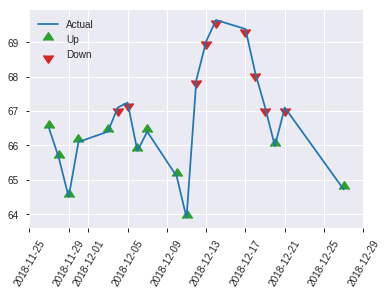


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4555424389143903
RMSE: 0.6749388408695933
LogLoss: 6.097858243434661
Mean Per-Class Error: 0.4208333333333334
AUC: 0.5885658914728682
pr_auc: 0.4279978427440445
Gini: 0.1771317829457364
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.2427036976574866e-38: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    112  0.9333   (112.0/120.0)
1      4    125  0.031    (4.0/129.0)
Total  12   237  0.4659   (116.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.2427e-38   0.68306   151
max f2                       3.15396e-50  0.843137  152
max f0point5                 0.999925     0.601307  73
max accuracy                 0.999925     0.582329  73
max precision                1            0.702128  0
max recall                   3.15396e-50  1         152
max specificity              1            0.883333  0
max absolute_mcc             1            0.181043  1
max min_per_class_accuracy   0.999994     0.55      40
max mean_per_class_accuracy  1            0.579167  1

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 89.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   1                  1.28682   1.28682            0.666667         1          0.666667                    1                   0.0155039       0.0155039                  28.6822   28.6822
    2        0.0200803                   1                  1.93023   1.54419            1                1          0.8                         1                   0.0155039       0.0310078                  93.0233   54.4186
    3        0.0321285                   1                  0.643411  1.2064             0.333333         1          0.625                       1                   0.00775194      0.0387597                  -35.6589  20.6395
    4        0.0401606                   1                  1.93023   1.35116            1                1          0.7                         1                   0.0155039       0.0542636                  93.0233   35.1163
    5        0.0522088                   1                  1.28682   1.33631            0.666667         1          0.692308                    1                   0.0155039       0.0697674                  28.6822   33.6315
    6        0.100402                    1                  1.28682   1.31256            0.666667         1          0.68                        1                   0.0620155       0.131783                   28.6822   31.2558
    7        0.15261                     1                  1.48479   1.37148            0.769231         1          0.710526                    1                   0.0775194       0.209302                   48.4794   37.1481
    8        0.200803                    1                  1.28682   1.35116            0.666667         1          0.7                         1                   0.0620155       0.271318                   28.6822   35.1163
    9        0.301205                    1                  0.926512  1.20961            0.48             1          0.626667                    1                   0.0930233       0.364341                   -7.34884  20.9612
    10       0.401606                    0.999998           0.694884  1.08093            0.36             0.999999   0.56                        1                   0.0697674       0.434109                   -30.5116  8.09302
    11       0.502008                    0.999994           1.15814   1.09637            0.6              0.999997   0.568                       0.999999            0.116279        0.550388                   15.814    9.63721
    12       0.598394                    0.999955           1.04554   1.08818            0.541667         0.999984   0.563758                    0.999997            0.100775        0.651163                   4.55426   8.81848
    13       0.698795                    0.999721           1.00372   1.07605            0.52             0.999875   0.557471                    0.999979            0.100775        0.751938                   0.372093  7.60492
    14       0.799197                    0.996205           0.772093  1.03786            0.4              0.998903   0.537688                    0.999844            0.0775194       0.829457                   -22.7907  3.78637
    15       0.899598                    0.635207           0.849302  1.01682            0.44             0.911777   0.526786                    0.990015            0.0852713       0.914729                   -15.0698  1.68189
    16       1                           0                  0.849302  1                  0.44             0.0540447  0.518072                   

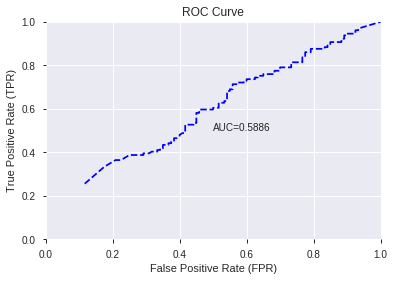

This function is available for GLM models only


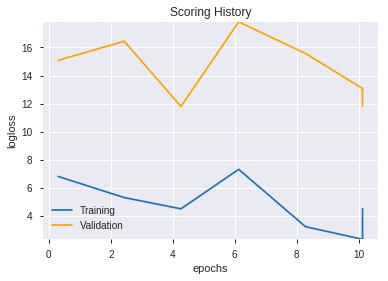

--2019-08-25 12:03:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  59.1MB/s    in 5.6s    

2019-08-25 12:03:09 (62.9 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_112833_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_112833_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [0]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_120319_model_1  0.578101  0.789562              0.495833  0.521084  0.271529
1  DeepLearning_grid_1_AutoML_20190825_120319_model_2  0.575258  0.730017              0.486919  0.516816  0.267099
2  DeepLearning_grid_1_AutoML_20190825_120319_model_5  0.552778  0.692390              0.474128  0.499621  0.249622
3  DeepLearning_grid_1_AutoML_20190825_120319_model_4  0.546318  0.705898              0.495543  0.506096  0.256133
4               DeepLearning_1_AutoML_20190825_120319  0.535078  0.926503              0.474419  0.583731  0.340742
5  DeepLearning_grid_1_AutoML_20190825_120319_model_3  0.521382  0.785395              0.478004  0.520605  0.271029
6  DeepLearning_grid_1_AutoML_20190825_120319_model_6  0.502067  0.696064              0.495833  0.501448  0.251450
7  DeepLearning_grid_1_AutoML_20190825_120319_model_9  0.500000  0.692503              0.500000  0.499678  0.249678
8  DeepLearning_grid_1_AutoML_20190825_120319_model_8  0.500000  0.692496              0.500000  0.499675  0.249675
9  DeepLearning_grid_1_AutoML_20190825_120319_model_7  0.493992  0.733676              0.495833  0.513245  0.263421

variable  relative_importance  scaled_importance  percentage
0               CDLTHRUSTING             1.000000           1.000000    0.035668
1             CDL3BLACKCROWS             0.931588           0.931588    0.033227
2                CDLPIERCING             0.889379           0.889379    0.031722
3         CDLIDENTICAL3CROWS             0.888670           0.888670    0.031697
4                  dayofweek             0.650998           0.650998    0.023219
5                CDLBELTHOLD             0.645642           0.645642    0.023028
6                 aroonup_20             0.627988           0.627988    0.022399
7                        SIN             0.627257           0.627257    0.022373
8              days_in_month             0.624944           0.624944    0.022290
9                   CORREL_8             0.617041           0.617041    0.022008
10                 CORREL_12             0.591882           0.591882    0.021111
11                   NATR_24             0.583310           0.583310    0.020805
12   BBANDS_lowerband_30_7_5             0.557185           0.557185    0.019873
13                 MACD_hist             0.549539           0.549539    0.019601
14                    ATR_12             0.542008           0.542008    0.019332
15         MACDFIX_signal_12             0.531890           0.531890    0.018971
16                MACDFIX_24             0.531524           0.531524    0.018958
17                    RSI_14             0.529318           0.529318    0.018879
18    BBANDS_lowerband_8_0_4             0.528867           0.528867    0.018863
19                ROCR100_24             0.526726           0.526726    0.018787
20                   MA_12_1             0.525108           0.525108    0.018729
21   BBANDS_lowerband_14_2_4             0.524348           0.524348    0.018702
22   BBANDS_lowerband_20_2_2             0.518060           0.518060    0.018478
23   BBANDS_middleband_8_2_3             0.518048           0.518048    0.018477
24              LINEARREG_20             0.516103           0.516103    0.018408
25   BBANDS_lowerband_12_4_5             0.514639           0.514639    0.018356
26   BBANDS_lowerband_20_6_5             0.512453           0.512453    0.018278
27                    MA_8_6             0.510830           0.510830    0.018220
28    BBANDS_lowerband_8_5_3             0.510797           0.510797    0.018219
29  BBANDS_middleband_24_5_4             0.509408           0.509408    0.018169
30  BBANDS_middleband_20_6_5             0.504861           0.504861    0.018007
31                   ROCP_14             0.504232           0.504232    0.017985
32    BBANDS_lowerband_8_3_2             0.503335           0.503335    0.017953
33   BBANDS_middleband_8_3_3             0.503040           0.503040    0.017942
34   BBANDS_middleband_8_5_4             0.502500           0.502500    0.017923
35                   MA_24_6             0.501948           0.501948    0.017903
36  BBANDS_middleband_30_6_5             0.501817           0.501817    0.017899
37   BBANDS_upperband_14_7_3             0.499277           0.499277    0.017808
38   BBANDS_upperband_20_6_2             0.499151           0.499151    0.017803
39   BBANDS_upperband_20_1_3             0.496920           0.496920    0.017724
40  BBANDS_middleband_20_3_4             0.496807           0.496807    0.017720
41  BBANDS_middleband_20_1_5             0.496328           0.496328    0.017703
42  BBANDS_middleband_14_5_3             0.495375           0.495375    0.017669
43   BBANDS_upperband_30_5_5             0.494552           0.494552    0.017639
44   BBANDS_middleband_8_7_5             0.491114           0.491114    0.017517
45                 MAVP_12_7             0.490733           0.490733    0.017503
46                       ADD             0.488571           0.488571    0.017426
47                   MA_24_1             0.484384           0.484384    0.017277
48   BBANDS_lowerband_14_3_3             0.481893  

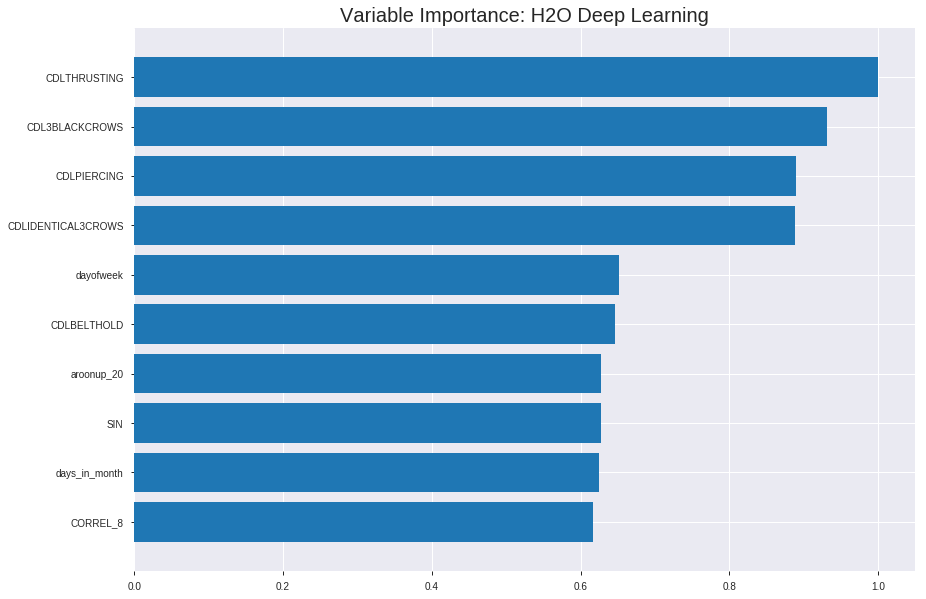

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_120319_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.268972157943904
RMSE: 0.5186252577188118
LogLoss: 0.7571454179394377
Mean Per-Class Error: 0.4356850553773448
AUC: 0.585719377450398
pr_auc: 0.5883718483794754
Gini: 0.17143875490079608
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08006492791380163: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      22   833   0.9743   (833.0/855.0)
1      3    883   0.0034   (3.0/886.0)
Total  25   1716  0.4802   (836.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0800649    0.678709  388
max f2                       0.0742049    0.839825  389
max f0point5                 0.314633     0.582701  284
max accuracy                 0.646288     0.560597  127
max precision                1            1         0
max recall                   0.042009     1         396
max specificity              1            1         0
max absolute_mcc             0.6811       0.142587  111
max min_per_class_accuracy   0.494738     0.548538  200
max mean_per_class_accuracy  0.646288     0.564315  127

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 49.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103389                   0.978285           1.52834   1.52834            0.777778         0.987825  0.777778                    0.987825            0.0158014       0.0158014                  52.8342    52.8342
    2        0.0201034                   0.95376            0.809122  1.17901            0.411765         0.967285  0.6                         0.977848            0.00790068      0.023702                   -19.0878   17.9007
    3        0.0304423                   0.93345            1.63751   1.33472            0.833333         0.944087  0.679245                    0.966382            0.01693         0.0406321                  63.7509    33.4725
    4        0.0402068                   0.913412           1.27148   1.31936            0.647059         0.9223    0.671429                    0.955677            0.0124153       0.0530474                  27.1478    31.9365
    5        0.0505457                   0.896701           1.20084   1.29512            0.611111         0.905036  0.659091                    0.945318            0.0124153       0.0654628                  20.084     29.5121
    6        0.100517                    0.820298           1.31001   1.30252            0.666667         0.86085   0.662857                    0.903325            0.0654628       0.130926                   31.0008    30.2522
    7        0.150488                    0.760793           1.26483   1.29001            0.643678         0.790498  0.656489                    0.86586             0.0632054       0.194131                   26.4835    29.0007
    8        0.20046                     0.720516           1.12932   1.24995            0.574713         0.738623  0.636103                    0.834142            0.0564334       0.250564                   12.9317    24.995
    9        0.300402                    0.639118           1.11802   1.20606            0.568966         0.679092  0.613767                    0.782557            0.111738        0.362302                   11.8024    20.6059
    10       0.400345                    0.567929           0.89216   1.1277             0.454023         0.604366  0.573888                    0.738073            0.0891648       0.451467                   -10.784    12.7697
    11       0.500287                    0.497659           0.971212  1.09644            0.494253         0.531163  0.557979                    0.696739            0.0970655       0.548533                   -2.87875   9.64357
    12       0.60023                     0.42189            0.937333  1.06994            0.477011         0.455777  0.544498                    0.656617            0.0936795       0.642212                   -6.2667    6.99439
    13       0.700172                    0.344872           1.05026   1.06713            0.534483         0.38208   0.543068                    0.61743             0.104966        0.747178                   5.02647    6.71349
    14       0.800115                    0.27138            0.993799  1.05797            0.505747         0.30747   0.538406                    0.578713            0.0993228       0.846501                   -0.620119  5.79745
    15       0.900057                    0.189556           0.89216   1.03956            0.454023         0.232563  0.529036                    0.540276            0.0891648       0.935666                   -10.784    3.95624
    16       1                           2.1083e-10         0.643711  1                  0.327586         0.128577  0.508903                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.30588116015904504
RMSE: 0.5530652404183841
LogLoss: 0.8706893125496031
Mean Per-Class Error: 0.4676122511584352
AUC: 0.5106075528359462
pr_auc: 0.5093940329530948
Gini: 0.02121510567189233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.144161296501514: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    234  0.971    (234.0/241.0)
1      2    255  0.0078   (2.0/257.0)
Total  9    489  0.4739   (236.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.144161     0.683646  390
max f2                       0.0999298    0.843176  397
max f0point5                 0.231543     0.581784  364
max accuracy                 0.410598     0.540161  287
max precision                0.910879     0.541667  35
max recall                   0.0999298    1         397
max specificity              0.989148     0.995851  0
max absolute_mcc             0.231543     0.100049  364
max min_per_class_accuracy   0.598167     0.514523  193
max mean_per_class_accuracy  0.410598     0.532388  287

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 59.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.964637           0.387549  0.387549           0.2              0.973701  0.2                         0.973701            0.00389105      0.00389105                 -61.2451  -61.2451
    2        0.0200803                   0.957904           1.55019   0.968872           0.8              0.963245  0.5                         0.968473            0.0155642       0.0194553                  55.0195   -3.11284
    3        0.0301205                   0.949561           0         0.645914           0                0.95547   0.333333                    0.964139            0               0.0194553                  -100      -35.4086
    4        0.0401606                   0.946068           1.16265   0.775097           0.6              0.947833  0.4                         0.960062            0.0116732       0.0311284                  16.2646   -22.4903
    5        0.0502008                   0.934623           1.16265   0.852607           0.6              0.941034  0.44                        0.956257            0.0116732       0.0428016                  16.2646   -14.7393
    6        0.100402                    0.907603           1.16265   1.00763            0.6              0.920815  0.52                        0.938536            0.0583658       0.101167                   16.2646   0.762646
    7        0.150602                    0.879429           0.697588  0.90428            0.36             0.893821  0.466667                    0.923631            0.0350195       0.136187                   -30.2412  -9.57198
    8        0.200803                    0.847785           1.08514   0.949494           0.56             0.864731  0.49                        0.908906            0.0544747       0.190661                   8.51362   -5.05058
    9        0.301205                    0.753058           1.12389   1.00763            0.58             0.803586  0.52                        0.873799            0.11284         0.303502                   12.3891   0.762646
    10       0.399598                    0.672001           0.790916  0.954265           0.408163         0.707655  0.492462                    0.832889            0.077821        0.381323                   -20.9084  -4.57345
    11       0.5                         0.599197           1.31767   1.02724            0.68             0.636185  0.53012                     0.79339             0.132296        0.513619                   31.7665   2.72374
    12       0.600402                    0.512286           1.12389   1.0434             0.58             0.557653  0.538462                    0.753969            0.11284         0.626459                   12.3891   4.34002
    13       0.698795                    0.437018           0.909553  1.02455            0.469388         0.481789  0.528736                    0.715645            0.0894942       0.715953                   -9.04471  2.45539
    14       0.799197                    0.359429           1.04638   1.0273             0.54             0.400206  0.530151                    0.676017            0.105058        0.821012                   4.63813   2.7296
    15       0.899598                    0.255074           0.968872  1.02078            0.5              0.307925  0.526786                    0.634935            0.0972763       0.918288                   -3.11284  2.07754
    16       1                           1.67636e-10        0.813852  1                  0.42             0.190431  0.516064                    0.590306


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:03:20  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:03:26  5.723 sec   3061 obs/sec      9.81735   1             17092      0.587544         1.10696             -0.381271      0.530811        0.534848           1.31001          0.491097                         0.650898           1.5763                -0.696425        0.515298          0.507277             0.387549           0.471888
    2019-08-25 12:03:32  11.153 sec  3129 obs/sec      19.6358   2             34186      0.5415           0.829789            -0.173261      0.563667        0.575424           1.41917          0.486502                         0.59715            1.18291               -0.427827        0.51328           0.51229              1.16265            0.465863
    2019-08-25 12:03:41  20.888 sec  3327 obs/sec      39.2545   4             68342      0.536226         0.81041             -0.150519      0.580838        0.593196           1.74668          0.473866                         0.574245           0.960422              -0.320394        0.517833          0.509556             1.16265            0.457831
    2019-08-25 12:03:51  30.427 sec  3428 obs/sec      58.8966   6             102539     0.518625         0.757145            -0.0762298     0.585719        0.588372           1.52834          0.480184                         0.553065           0.870689              -0.224789        0.510608          0.509394             0.387549           0.473896
    2019-08-25 12:04:00  39.462 sec  3522 obs/sec      78.5365   8             136732     0.531039         0.847929            -0.128368      0.608427        0.625398           1.74668          0.482481                         0.690562           2.17145               -0.909472        0.502325          0.505276             0.775097           0.471888
    2019-08-25 12:04:08  47.951 sec  3620 obs/sec      98.1804   10            170932     0.525262         0.829432            -0.103952      0.602711        0.620291           1.74668          0.487651                         0.687259           2.0525                -0.89125         0.508258          0.509592             1.16265            0.463855
    2019-08-25 12:04:16  55.477 sec  3754 obs/sec      117.808   12            205103     0.490048         0.702732            0.0391072      0.659331        0.666183           1.74668          0.443423                         0.590329           1.0406                -0.395395        0.508638          0.50196              0.775097           0.461847
    2019-08-25 12:04:16  55.584 sec  3753 obs/sec      117.808   12            205103     0.518625         0.757145            -0.0762298     0.585719        0.588372           1.52834          0.480184                         0.553065           0.870689              -0.224789        0.510608          0.509394             0.387549           0.473896

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
CDLTHRUSTING             1.0                    1.0                  0.03566750136481392
CDL3BLACKCROWS           0.931588351726532      0.931588351726532    0.03322742880665083
CDLPIERCING              0.8893790245056152     0.8893790245056152   0.031721927570390905
CDLIDENTICAL3CROWS       0.8886696100234985     0.8886696100234985   0.03169662452838179
dayofweek                0.6509983539581299     0.6509983539581299   0.023219484678293212
---                      ---                    ---                  ---
MAVP_12_7                0.4907328188419342     0.4907328188419342   0.01750321348580367
ADD                      0.488571435213089      0.488571435213089    0.01742612233227195
MA_24_1                  0.4843837022781372     0.4843837022781372   0.017276756362099077
BBANDS_lowerband_14_3_3  0.4818931221961975     0.4818931221961975   0.017187923593627315
MAVP_8_4                 0.4643368422985077     0.4643368422985077   0.01656173495641541


See the whole table with table.as_data_frame()


('accuracy', 0.5903614457831325)

('F1', 0.6843501326259948)

('auc', 0.5781007751937984)

('logloss', 0.7895617354202726)

('mean_per_class_error', 0.4155038759689922)

('rmse', 0.5210844982033649)

('mse', 0.27152905426785257)

deeplearning prediction progress: |███████████████████████████████████████| 100%


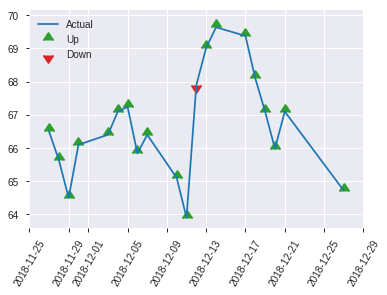


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27152905426785257
RMSE: 0.5210844982033649
LogLoss: 0.7895617354202726
Mean Per-Class Error: 0.4155038759689922
AUC: 0.5781007751937984
pr_auc: 0.5712307344374462
Gini: 0.15620155038759687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1195869421560844: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    119  0.9917   (119.0/120.0)
1      0    129  0        (0.0/129.0)
Total  1    248  0.4779   (119.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.119587     0.68435   247
max f2                       0.119587     0.844241  247
max f0point5                 0.470961     0.609613  180
max accuracy                 0.502002     0.590361  170
max precision                0.989121     1         0
max recall                   0.119587     1         247
max specificity              0.989121     1         0
max absolute_mcc             0.470961     0.184523  180
max min_per_class_accuracy   0.589295     0.55814   123
max mean_per_class_accuracy  0.562162     0.584496  137

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 59.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.986281           1.93023   1.93023            1                0.988055  1                           0.988055            0.0232558       0.0232558                  93.0233   93.0233
    2        0.0200803                   0.98328            0.965116  1.54419            0.5              0.985746  0.8                         0.987132            0.00775194      0.0310078                  -3.48837  54.4186
    3        0.0321285                   0.976269           0.643411  1.2064             0.333333         0.979392  0.625                       0.984229            0.00775194      0.0387597                  -35.6589  20.6395
    4        0.0401606                   0.973157           0         0.965116           0                0.976001  0.5                         0.982584            0               0.0387597                  -100      -3.48837
    5        0.0522088                   0.969027           1.93023   1.18784            1                0.971693  0.615385                    0.98007             0.0232558       0.0620155                  93.0233   18.7835
    6        0.100402                    0.853346           0.965116  1.08093            0.5              0.922091  0.56                        0.95224             0.0465116       0.108527                   -3.48837  8.09302
    7        0.15261                     0.811656           0.890877  1.01591            0.461538         0.827825  0.526316                    0.909677            0.0465116       0.155039                   -10.9123  1.59119
    8        0.200803                    0.776864           1.28682   1.08093            0.666667         0.794707  0.56                        0.882084            0.0620155       0.217054                   28.6822   8.09302
    9        0.301205                    0.695209           1.15814   1.10667            0.6              0.737475  0.573333                    0.833881            0.116279        0.333333                   15.814    10.6667
    10       0.401606                    0.637808           1.23535   1.13884            0.64             0.662347  0.59                        0.790998            0.124031        0.457364                   23.5349   13.8837
    11       0.502008                    0.58709            1.00372   1.11181            0.52             0.608544  0.576                       0.754507            0.100775        0.55814                    0.372093  11.1814
    12       0.598394                    0.541037           1.12597   1.11409            0.583333         0.561572  0.577181                    0.72343             0.108527        0.666667                   12.5969   11.4094
    13       0.698795                    0.484484           1.08093   1.10933            0.56             0.523074  0.574713                    0.694644            0.108527        0.775194                   8.09302   10.9329
    14       0.799197                    0.41727            0.617674  1.04756            0.32             0.456378  0.542714                    0.664711            0.0620155       0.837209                   -38.2326  4.75634
    15       0.899598                    0.304611           0.772093  1.01682            0.4              0.364532  0.526786                    0.631209            0.0775194       0.914729                   -22.7907  1.68189
    16       1                           1.01866e-10        0.849302  1                  0.44             0.22743   0.518072                    0.590669        

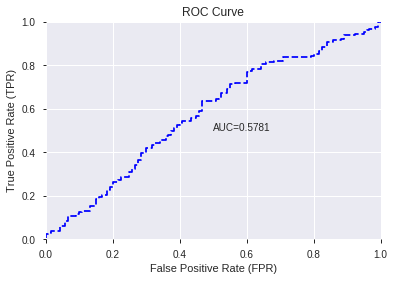

This function is available for GLM models only


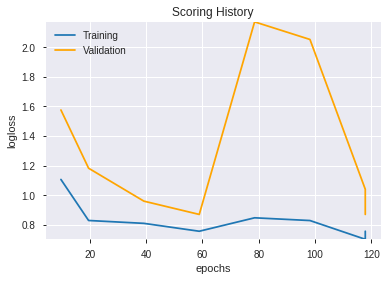

--2019-08-25 12:14:33--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_120319_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_120319_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLTHRUSTING',
 'CDL3BLACKCROWS',
 'CDLPIERCING',
 'CDLIDENTICAL3CROWS',
 'dayofweek',
 'CDLBELTHOLD',
 'aroonup_20',
 'SIN',
 'days_in_month',
 'CORREL_8',
 'CORREL_12',
 'NATR_24',
 'BBANDS_lowerband_30_7_5',
 'MACD_hist',
 'ATR_12',
 'MACDFIX_signal_12',
 'MACDFIX_24',
 'RSI_14',
 'BBANDS_lowerband_8_0_4',
 'ROCR100_24',
 'MA_12_1',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_middleband_8_2_3',
 'LINEARREG_20',
 'BBANDS_lowerband_12_4_5',
 'BBANDS_lowerband_20_6_5',
 'MA_8_6',
 'BBANDS_lowerband_8_5_3',
 'BBANDS_middleband_24_5_4',
 'BBANDS_middleband_20_6_5',
 'ROCP_14',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_middleband_8_3_3',
 'BBANDS_middleband_8_5_4',
 'MA_24_6',
 'BBANDS_middleband_30_6_5',
 'BBANDS_upperband_14_7_3',
 'BBANDS_upperband_20_6_2',
 'BBANDS_upperband_20_1_3',
 'BBANDS_middleband_20_3_4',
 'BBANDS_middleband_20_1_5',
 'BBANDS_middleband_14_5_3',
 'BBANDS_upperband_30_5_5',
 'BBANDS_middleband_8_7_5',
 'MAVP_12_7',
 'ADD',
 'MA_24_1',
 'BBANDS_l

In [0]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_121529_model_1  0.492183  0.697501              0.491667  0.502145  0.252149

variable  relative_importance  scaled_importance  percentage
0                 aroonup_20             0.082624           1.000000    0.065800
1    BBANDS_lowerband_30_7_5             0.076631           0.927462    0.061027
2              days_in_month             0.070833           0.857295    0.056410
3                        SIN             0.066972           0.810568    0.053335
4         CDLIDENTICAL3CROWS             0.066260           0.801946    0.052768
5                     ATR_12             0.063844           0.772711    0.050844
6                   CORREL_8             0.062480           0.756196    0.049758
7                CDLBELTHOLD             0.060484           0.732044    0.048168
8                 ROCR100_24             0.052606           0.636696    0.041895
9   BBANDS_middleband_30_6_5             0.045229           0.547409    0.036020
10   BBANDS_upperband_30_5_5             0.044271           0.535808    0.035256
11                 CORREL_12             0.042463           0.513932    0.033817
12                  MAVP_8_4             0.032305           0.390992    0.025727
13   BBANDS_lowerband_14_2_4             0.028315           0.342694    0.022549
14                   MA_24_6             0.026327           0.318642    0.020967
15   BBANDS_lowerband_20_6_5             0.025653           0.310480    0.020430
16            CDL3BLACKCROWS             0.024634           0.298148    0.019618
17  BBANDS_middleband_20_6_5             0.024626           0.298044    0.019611
18                       ADD             0.024465           0.296105    0.019484
19   BBANDS_upperband_20_6_2             0.024175           0.292586    0.019252
20                 dayofweek             0.024078           0.291414    0.019175
21               CDLPIERCING             0.020151           0.243887    0.016048
22   BBANDS_lowerband_12_4_5             0.019884           0.240660    0.015835
23                    RSI_14             0.018960           0.229470    0.015099
24                   ROCP_14             0.018654           0.225764    0.014855
25   BBANDS_lowerband_14_3_3             0.018432           0.223086    0.014679
26              LINEARREG_20             0.017991           0.217752    0.014328
27   BBANDS_middleband_8_5_4             0.017866           0.216232    0.014228
28         MACDFIX_signal_12             0.017119           0.207198    0.013634
29    BBANDS_lowerband_8_0_4             0.015854           0.191880    0.012626
30   BBANDS_upperband_14_7_3             0.015621           0.189063    0.012440
31                   NATR_24             0.014300           0.173068    0.011388
32    BBANDS_lowerband_8_3_2             0.012251           0.148271    0.009756
33                MACDFIX_24             0.011857           0.143500    0.009442
34              CDLTHRUSTING             0.009256           0.112027    0.007371
35                    MA_8_6             0.009065           0.109720    0.007220
36   BBANDS_middleband_8_2_3             0.009034           0.109343    0.007195
37                 MACD_hist             0.009013           0.109090    0.007178
38                   MA_12_1             0.007071           0.085584    0.005631
39                   MA_24_1             0.005550           0.067169    0.004420
40  BBANDS_middleband_14_5_3             0.005468           0.066174    0.004354
41    BBANDS_lowerband_8_5_3             0.004114           0.049796    0.003277
42   BBANDS_middleband_8_7_5             0.002525           0.030555    0.002011
43   BBANDS_middleband_8_3_3             0.002022           0.024469    0.001610
44                 MAVP_12_7             0.001675           0.020278    0.001334
45  BBANDS_middleband_20_1_5             0.001560           0.018879    0.001242
46  BBANDS_middleband_20_3_4             0.000426           0.005150    0.000339
47  BBANDS_middleband_24_5_4             0.000327           0.003961    0.000261
48   BBANDS_upperband_20_1_3             0.000221  

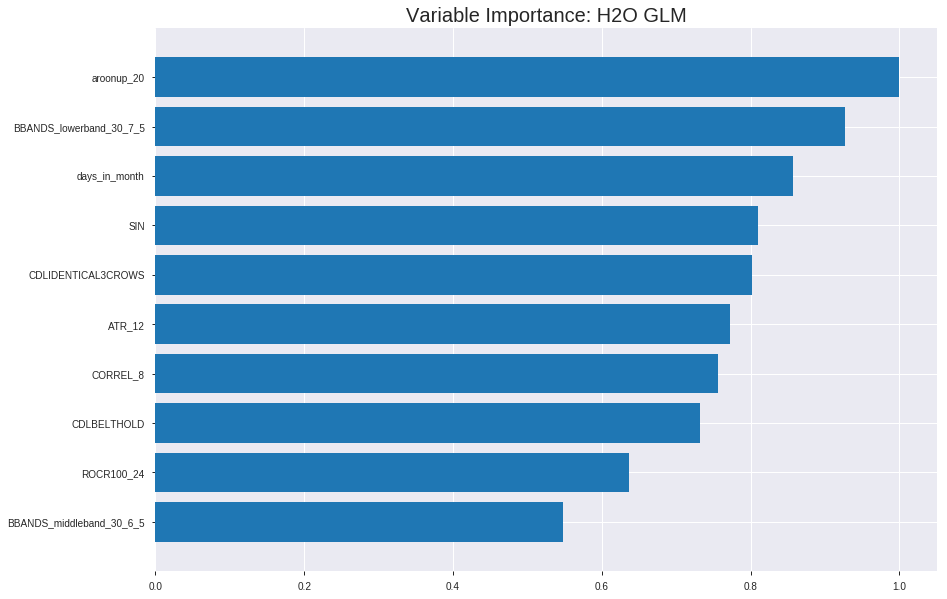

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_121529_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24754442563506354
RMSE: 0.4975383659930795
LogLoss: 0.6881396160810558
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2412.986471918777
Residual deviance: 2396.1021431942363
AIC: 2498.1021431942363
AUC: 0.554692223410294
pr_auc: 0.5639039933967774
Gini: 0.10938444682058801
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4287133812317736: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   830   0.9708   (830.0/855.0)
1      11   875   0.0124   (11.0/886.0)
Total  36   1705  0.4831   (841.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428713     0.675415  372
max f2                       0.314889     0.838221  399
max f0point5                 0.428713     0.567739  372
max accuracy                 0.517638     0.548535  168
max precision                0.937221     1         0
max recall                   0.314889     1         399
max specificity              0.937221     1         0
max absolute_mcc             0.517638     0.10178   168
max min_per_class_accuracy   0.508348     0.536842  194
max mean_per_class_accuracy  0.517638     0.550111  168

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.605674           1.41917   1.41917            0.722222         0.632648  0.722222                    0.632648            0.0146727       0.0146727                  41.9175   41.9175
    2        0.0201034                   0.592284           1.0403    1.23515            0.529412         0.599113  0.628571                    0.61636             0.010158        0.0248307                  4.03001   23.515
    3        0.0304423                   0.585846           1.09167   1.18642            0.555556         0.588018  0.603774                    0.606734            0.0112867       0.0361174                  9.16729   18.6422
    4        0.0402068                   0.582985           1.50266   1.26322            0.764706         0.584304  0.642857                    0.601287            0.0146727       0.0507901                  50.2656   26.3222
    5        0.0505457                   0.578173           1.41917   1.29512            0.722222         0.580441  0.659091                    0.597023            0.0146727       0.0654628                  41.9175   29.5121
    6        0.100517                    0.561114           1.21966   1.25761            0.62069          0.569065  0.64                        0.583124            0.0609481       0.126411                   21.9662   25.7607
    7        0.150488                    0.55096            1.08414   1.20001            0.551724         0.555419  0.610687                    0.573924            0.0541761       0.180587                   8.41442   20.0007
    8        0.20046                     0.543203           1.12932   1.18239            0.574713         0.546864  0.601719                    0.567179            0.0564334       0.23702                    12.9317   18.2385
    9        0.300402                    0.529715           1.05026   1.13843            0.534483         0.536103  0.57935                     0.55684             0.104966        0.341986                   5.02647   13.8429
    10       0.400345                    0.518602           1.06156   1.11924            0.54023          0.524152  0.569584                    0.54868             0.106095        0.448081                   6.15578   11.9239
    11       0.500287                    0.508296           0.89216   1.07388            0.454023         0.51302   0.546498                    0.541556            0.0891648       0.537246                   -10.784   7.38753
    12       0.60023                     0.498479           0.903453  1.0455             0.45977          0.503585  0.532057                    0.535234            0.0902935       0.62754                    -9.65465  4.54988
    13       0.700172                    0.486471           0.971212  1.0349             0.494253         0.492277  0.526661                    0.529102            0.0970655       0.724605                   -2.87875  3.48952
    14       0.800115                    0.475072           0.914747  1.01989            0.465517         0.481071  0.519024                    0.523102            0.0914221       0.816027                   -8.52534  1.98874
    15       0.900057                    0.457593           0.914747  1.00821            0.465517         0.466913  0.513082                    0.516863            0.0914221       0.907449                   -8.52534  0.821256
    16       1                           0.314889           0.92604   1                  0.471264         0.437189  0.508903                    0.5089           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24815336575961
RMSE: 0.49814994304888766
LogLoss: 0.6894150924761766
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.962659370588
Residual deviance: 686.6574321062719
AIC: 788.6574321062719
AUC: 0.5476532605712255
pr_auc: 0.5449065032100651
Gini: 0.09530652114245108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42327977534819194: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   228  0.9461   (228.0/241.0)
1      3    254  0.0117   (3.0/257.0)
Total  16   482  0.4639   (231.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42328      0.687415  383
max f2                       0.408208     0.844839  394
max f0point5                 0.462142     0.58647   308
max accuracy                 0.469705     0.556225  288
max precision                0.618639     1         0
max recall                   0.408208     1         394
max specificity              0.618639     1         0
max absolute_mcc             0.43339      0.123035  372
max min_per_class_accuracy   0.493429     0.536965  205
max mean_per_class_accuracy  0.501273     0.554911  172

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 49.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.582388           1.16265   1.16265            0.6              0.597887  0.6                         0.597887            0.0116732       0.0116732                  16.2646   16.2646
    2        0.0200803                   0.578697           1.16265   1.16265            0.6              0.58049   0.6                         0.589189            0.0116732       0.0233463                  16.2646   16.2646
    3        0.0301205                   0.570399           1.16265   1.16265            0.6              0.576877  0.6                         0.585085            0.0116732       0.0350195                  16.2646   16.2646
    4        0.0401606                   0.562668           1.55019   1.25953            0.8              0.566719  0.65                        0.580493            0.0155642       0.0505837                  55.0195   25.9533
    5        0.0502008                   0.559742           0.775097  1.16265            0.4              0.560969  0.6                         0.576588            0.0077821       0.0583658                  -22.4903  16.2646
    6        0.100402                    0.545146           0.852607  1.00763            0.44             0.55253   0.52                        0.564559            0.0428016       0.101167                   -14.7393  0.762646
    7        0.150602                    0.53547            0.697588  0.90428            0.36             0.540753  0.466667                    0.556624            0.0350195       0.136187                   -30.2412  -9.57198
    8        0.200803                    0.52619            1.39518   1.027              0.72             0.531284  0.53                        0.550289            0.0700389       0.206226                   39.5175   2.70039
    9        0.301205                    0.513654           1.2014    1.08514            0.62             0.519728  0.56                        0.540102            0.120623        0.326848                   20.1401   8.51362
    10       0.399598                    0.503813           1.22592   1.1198             0.632653         0.508897  0.577889                    0.532418            0.120623        0.447471                   22.5919   11.9801
    11       0.5                         0.493156           0.891362  1.07393            0.46             0.498062  0.554217                    0.525519            0.0894942       0.536965                   -10.8638  7.393
    12       0.600402                    0.4857             0.930117  1.04988            0.48             0.489271  0.541806                    0.519458            0.0933852       0.63035                    -6.98833  4.98809
    13       0.698795                    0.474951           0.988644  1.04126            0.510204         0.479842  0.537356                    0.51388             0.0972763       0.727626                   -1.13555  4.12586
    14       0.799197                    0.460603           1.12389   1.05164            0.58             0.468326  0.542714                    0.508157            0.11284         0.840467                   12.3891   5.16395
    15       0.899598                    0.444389           0.697588  1.01212            0.36             0.450798  0.522321                    0.501755            0.0700389       0.910506                   -30.2412  1.21248
    16       1                           0.38825            0.891362  1                  0.46             0.42718   0.516064                    0.494268         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:15:30  0.000 sec   2            2.5       51            1.38411           1.38494
    2019-08-25 12:15:30  0.062 sec   4            1.6       51            1.38339           1.38469
    2019-08-25 12:15:30  0.115 sec   6            0.96      51            1.38253           1.3843
    2019-08-25 12:15:30  0.160 sec   8            0.6       51            1.38155           1.38374
    2019-08-25 12:15:30  0.190 sec   10           0.37      51            1.38051           1.38299
    2019-08-25 12:15:30  0.217 sec   12           0.23      51            1.37949           1.3821
    2019-08-25 12:15:30  0.235 sec   14           0.14      51            1.37858           1.38118
    2019-08-25 12:15:30  0.253 sec   16           0.089     51            1.37782           1.38031
    2019-08-25 12:15:30  0.270 sec   17           0.055     51            1.37722           1.37956
    2019-08-25 12:15:30  0.285 sec   18           0.034     51            1.37672           1.37903
    2019-08-25 12:15:30  0.297 sec   19           0.021     51            1.37628           1.37883
    2019-08-25 12:15:30  0.309 sec   20           0.013     51            1.37584           1.37912
    2019-08-25 12:15:30  0.320 sec   21           0.0082    51            1.37537           1.37999
    2019-08-25 12:15:30  0.330 sec   22           0.0051    51            1.37484           1.38142
    2019-08-25 12:15:30  0.340 sec   23           0.0032    51            1.37426           1.38329
    2019-08-25 12:15:30  0.351 sec   24           0.002     51            1.37356           1.38566

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5341365461847389)

('F1', 0.6861702127659575)

('auc', 0.4921834625322997)

('logloss', 0.6975014890906686)

('mean_per_class_error', 0.47228682170542635)

('rmse', 0.5021445757072438)

('mse', 0.2521491749122079)

glm prediction progress: |████████████████████████████████████████████████| 100%


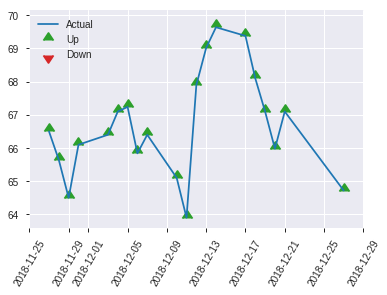


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2521491749122079
RMSE: 0.5021445757072438
LogLoss: 0.6975014890906686
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 344.9457142036249
Residual deviance: 347.35574156715296
AIC: 449.35574156715296
AUC: 0.4921834625322997
pr_auc: 0.49334999627566917
Gini: -0.01563307493540056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4112742704746789: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    118  0.9833   (118.0/120.0)
1      0    129  0        (0.0/129.0)
Total  2    247  0.4739   (118.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411274     0.68617   246
max f2                       0.411274     0.845347  246
max f0point5                 0.411274     0.57744   246
max accuracy                 0.49079      0.534137  168
max precision                0.523468     0.554348  91
max recall                   0.411274     1         246
max specificity              0.608549     0.991667  0
max absolute_mcc             0.590434     0.176338  6
max min_per_class_accuracy   0.509889     0.48062   122
max mean_per_class_accuracy  0.49079      0.527713  168

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.595949           0         0                  0                0.604414  0                           0.604414            0               0                          -100      -100
    2        0.0200803                   0.591142           0         0                  0                0.592155  0                           0.59951             0               0                          -100      -100
    3        0.0321285                   0.587755           0.643411  0.241279           0.333333         0.590437  0.125                       0.596108            0.00775194      0.00775194                 -35.6589  -75.8721
    4        0.0401606                   0.583023           0.965116  0.386047           0.5              0.584443  0.2                         0.593775            0.00775194      0.0155039                  -3.48837  -61.3953
    5        0.0522088                   0.577443           1.28682   0.593918           0.666667         0.580529  0.307692                    0.590718            0.0155039       0.0310078                  28.6822   -40.6082
    6        0.100402                    0.554122           0.965116  0.772093           0.5              0.564178  0.4                         0.577979            0.0465116       0.0775194                  -3.48837  -22.7907
    7        0.15261                     0.546338           1.18784   0.914321           0.615385         0.550041  0.473684                    0.568421            0.0620155       0.139535                   18.7835   -8.56793
    8        0.200803                    0.540132           0.965116  0.926512           0.5              0.542866  0.48                        0.562288            0.0465116       0.186047                   -3.48837  -7.34884
    9        0.301205                    0.528571           1.23535   1.02946            0.64             0.534232  0.533333                    0.552936            0.124031        0.310078                   23.5349   2.94574
    10       0.401606                    0.520928           0.926512  1.00372            0.48             0.524412  0.52                        0.545805            0.0930233       0.403101                   -7.34884  0.372093
    11       0.502008                    0.508638           0.772093  0.957395           0.4              0.515394  0.496                       0.539723            0.0775194       0.48062                    -22.7907  -4.26047
    12       0.598394                    0.501261           1.28682   1.01046            0.666667         0.504833  0.52349                     0.534103            0.124031        0.604651                   28.6822   1.04573
    13       0.698795                    0.489486           1.08093   1.02058            0.56             0.49497   0.528736                    0.52848             0.108527        0.713178                   8.09302   2.05827
    14       0.799197                    0.479708           0.849302  0.999065           0.44             0.48519   0.517588                    0.523042            0.0852713       0.79845                    -15.0698  -0.0934907
    15       0.899598                    0.466538           0.926512  0.990968           0.48             0.472199  0.513393                    0.517368            0.0930233       0.891473                   -7.34884  -0.903239
    16       1                           0.375644           1.08093   1                  0.56             0.443971  0.518072                    0.509998  

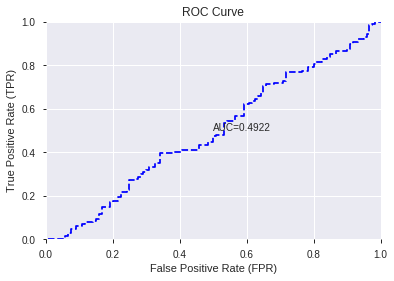

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


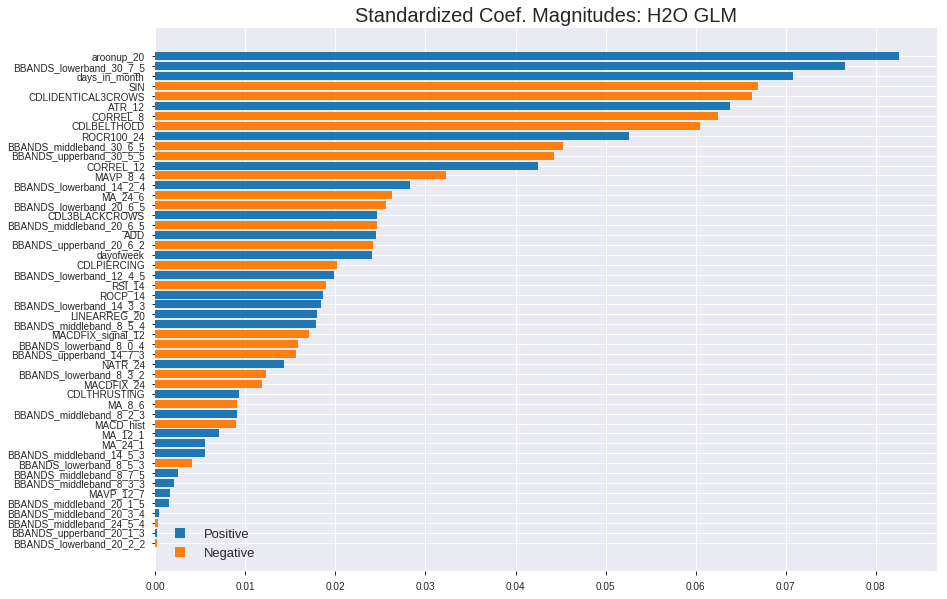

'log_likelihood'
--2019-08-25 12:15:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.110.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.110.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_121529_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_121529_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['aroonup_20',
 'BBANDS_lowerband_30_7_5',
 'days_in_month',
 'SIN',
 'CDLIDENTICAL3CROWS',
 'ATR_12',
 'CORREL_8',
 'CDLBELTHOLD',
 'ROCR100_24',
 'BBANDS_middleband_30_6_5',
 'BBANDS_upperband_30_5_5',
 'CORREL_12',
 'MAVP_8_4',
 'BBANDS_lowerband_14_2_4',
 'MA_24_6',
 'BBANDS_lowerband_20_6_5',
 'CDL3BLACKCROWS',
 'BBANDS_middleband_20_6_5',
 'ADD',
 'BBANDS_upperband_20_6_2',
 'dayofweek',
 'CDLPIERCING',
 'BBANDS_lowerband_12_4_5',
 'RSI_14',
 'ROCP_14',
 'BBANDS_lowerband_14_3_3',
 'LINEARREG_20',
 'BBANDS_middleband_8_5_4',
 'MACDFIX_signal_12',
 'BBANDS_lowerband_8_0_4',
 'BBANDS_upperband_14_7_3',
 'NATR_24',
 'BBANDS_lowerband_8_3_2',
 'MACDFIX_24',
 'CDLTHRUSTING',
 'MA_8_6',
 'BBANDS_middleband_8_2_3',
 'MACD_hist',
 'MA_12_1',
 'MA_24_1',
 'BBANDS_middleband_14_5_3',
 'BBANDS_lowerband_8_5_3',
 'BBANDS_middleband_8_7_5',
 'BBANDS_middleband_8_3_3',
 'MAVP_12_7',
 'BBANDS_middleband_20_1_5',
 'BBANDS_middleband_20_3_4',
 'BBANDS_middleband_24_5_4',
 'BBANDS_upperband_20_1_3

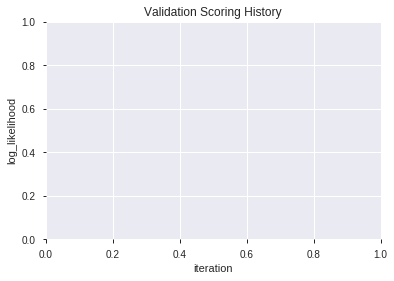

In [0]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_121636_model_1  0.567668  0.700861              0.491667  0.503553  0.253566
1  XGBoost_grid_1_AutoML_20190825_121636_model_5  0.527067  0.747663              0.500000  0.522452  0.272956
2               XGBoost_2_AutoML_20190825_121636  0.514341  0.705520              0.500000  0.505966  0.256002
3  XGBoost_grid_1_AutoML_20190825_121636_model_6  0.514341  0.715213              0.500000  0.510533  0.260644
4               XGBoost_3_AutoML_20190825_121636  0.507235  0.716207              0.483333  0.511103  0.261226
5  XGBoost_grid_1_AutoML_20190825_121636_model_7  0.503165  0.722134              0.495833  0.513546  0.263729
6  XGBoost_grid_1_AutoML_20190825_121636_model_2  0.502132  0.699733              0.491085  0.503241  0.253252
7  XGBoost_grid_1_AutoML_20190825_121636_model_3  0.499031  0.741702              0.500000  0.522167  0.272658
8  XGBoost_grid_1_AutoML_20190825_121636_model_4  0.498966  0.703469              0.486628  0.505032  0.255058
9               XGBoost_1_AutoML_20190825_121636  0.491731  0.716718              0.495833  0.511132  0.261256

variable  relative_importance  scaled_importance  percentage
0                    ROCP_14           272.747528           1.000000    0.090472
1                        SIN           258.648529           0.948308    0.085795
2                 ROCR100_24           249.445297           0.914565    0.082742
3                  MACD_hist           221.609833           0.812509    0.073509
4          MACDFIX_signal_12           219.948334           0.806417    0.072958
5                     RSI_14           207.611282           0.761185    0.068866
6                   CORREL_8           165.347519           0.606229    0.054847
7    BBANDS_lowerband_30_7_5           145.044693           0.531791    0.048112
8                  CORREL_12           143.958069           0.527807    0.047752
9                 MACDFIX_24           137.793381           0.505205    0.045707
10                    ATR_12           108.537323           0.397941    0.036002
11   BBANDS_upperband_30_5_5            93.874405           0.344181    0.031139
12                   NATR_24            63.169411           0.231604    0.020954
13                aroonup_20            60.769970           0.222807    0.020158
14    BBANDS_lowerband_8_0_4            55.476704           0.203399    0.018402
15   BBANDS_lowerband_12_4_5            53.481682           0.196085    0.017740
16   BBANDS_lowerband_20_6_5            49.437206           0.181256    0.016399
17   BBANDS_upperband_14_7_3            42.087879           0.154311    0.013961
18  BBANDS_middleband_20_3_4            38.595730           0.141507    0.012802
19   BBANDS_lowerband_20_2_2            37.867840           0.138838    0.012561
20   BBANDS_lowerband_14_2_4            37.138977           0.136166    0.012319
21   BBANDS_lowerband_14_3_3            36.472782           0.133724    0.012098
22                 dayofweek            32.758301           0.120105    0.010866
23   BBANDS_middleband_8_5_4            24.118919           0.088429    0.008000
24  BBANDS_middleband_24_5_4            23.916618           0.087688    0.007933
25                    MA_8_6            22.157179           0.081237    0.007350
26             days_in_month            21.443756           0.078621    0.007113
27                  MAVP_8_4            20.977148           0.076910    0.006958
28  BBANDS_middleband_20_6_5            19.856243           0.072801    0.006586
29  BBANDS_middleband_14_5_3            18.693668           0.068538    0.006201
30                   MA_12_1            16.841379           0.061747    0.005586
31    BBANDS_lowerband_8_5_3            14.908998           0.054662    0.004945
32    BBANDS_lowerband_8_3_2            13.684303           0.050172    0.004539
33  BBANDS_middleband_20_1_5            12.880215           0.047224    0.004272
34   BBANDS_middleband_8_3_3            12.596866           0.046185    0.004178
35   BBANDS_middleband_8_2_3            12.427943           0.045566    0.004122
36   BBANDS_upperband_20_6_2            12.417113           0.045526    0.004119
37               CDLBELTHOLD             8.663095           0.031762    0.002874
38              LINEARREG_20             7.781378           0.028530    0.002581
39                       ADD             7.648269           0.028042    0.002537
40   BBANDS_middleband_8_7_5             7.166455           0.026275    0.002377
41                   MA_24_1             4.718538           0.017300    0.001565

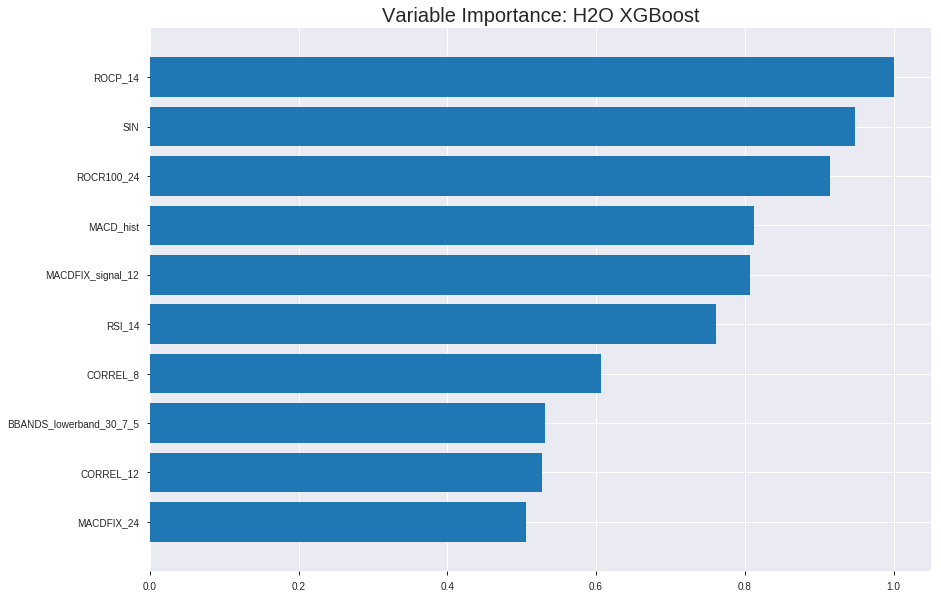

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_121636_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2086450951300134
RMSE: 0.4567768548536729
LogLoss: 0.6087390864899068
Mean Per-Class Error: 0.23208321782635677
AUC: 0.8461282061436511
pr_auc: 0.8448339480431777
Gini: 0.6922564122873023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49680901169776914: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      593  262  0.3064   (262.0/855.0)
1      150  736  0.1693   (150.0/886.0)
Total  743  998  0.2366   (412.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496809     0.781316  212
max f2                       0.441807     0.869256  280
max f0point5                 0.515601     0.776506  188
max accuracy                 0.511882     0.767949  193
max precision                0.782923     1         0
max recall                   0.36636      1         355
max specificity              0.782923     1         0
max absolute_mcc             0.511882     0.535795  193
max min_per_class_accuracy   0.511882     0.766082  193
max mean_per_class_accuracy  0.511882     0.767917  193

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.691075           1.96501   1.96501            1                0.713743  1                           0.713743            0.020316        0.020316                   96.5011   96.5011
    2        0.0201034                   0.674561           1.96501   1.96501            1                0.683426  1                           0.699017            0.0191874       0.0395034                  96.5011   96.5011
    3        0.0304423                   0.660899           1.96501   1.96501            1                0.668453  1                           0.688637            0.020316        0.0598194                  96.5011   96.5011
    4        0.0407812                   0.653433           1.74668   1.90966            0.888889         0.656408  0.971831                    0.680466            0.0180587       0.0778781                  74.6677   90.9659
    5        0.0505457                   0.641349           1.84942   1.89802            0.941176         0.645609  0.965909                    0.673732            0.0180587       0.0959368                  84.9422   89.8022
    6        0.100517                    0.608866           1.80691   1.85272            0.91954          0.624534  0.942857                    0.649274            0.0902935       0.18623                    80.6907   85.2725
    7        0.150488                    0.592609           1.82949   1.84501            0.931034         0.600585  0.938931                    0.633106            0.0914221       0.277652                   82.9493   84.5011
    8        0.20046                     0.577049           1.6488    1.7961             0.83908          0.58439   0.91404                     0.620962            0.0823928       0.360045                   64.8803   79.6099
    9        0.300402                    0.550695           1.54716   1.71328            0.787356         0.563504  0.871893                    0.601846            0.154628        0.514673                   54.7164   71.3279
    10       0.400345                    0.530288           1.27613   1.60415            0.649425         0.540673  0.816356                    0.586575            0.12754         0.642212                   27.6128   60.4148
    11       0.500287                    0.512927           1.18578   1.52057            0.603448         0.521623  0.773823                    0.573599            0.11851         0.760722                   18.5783   52.0571
    12       0.60023                     0.491012           0.846988  1.40841            0.431034         0.501156  0.716746                    0.561537            0.0846501       0.845372                   -15.3012  40.8415
    13       0.700172                    0.466698           0.801815  1.32183            0.408046         0.479683  0.672683                    0.549853            0.0801354       0.925508                   -19.8185  32.1829
    14       0.800115                    0.437732           0.406554  1.2075             0.206897         0.453007  0.614501                    0.537756            0.0406321       0.96614                    -59.3446  20.7502
    15       0.900057                    0.400415           0.271036  1.10352            0.137931         0.421356  0.561583                    0.524831            0.027088        0.993228                   -72.8964  10.3516
    16       1                           0.251351           0.067759  1                  0.0344828        0.358698  0.508903                    0.508227         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2645951923002176
RMSE: 0.514388172784151
LogLoss: 0.7232714092867941
Mean Per-Class Error: 0.4825064178116474
AUC: 0.4831603080549591
pr_auc: 0.4988568034222934
Gini: -0.03367938389008185
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2533554136753082: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    240  0.9959   (240.0/241.0)
1      0    257  0        (0.0/257.0)
Total  1    497  0.4819   (240.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.253355     0.681698   398
max f2                       0.253355     0.842623   398
max f0point5                 0.315581     0.576122   378
max accuracy                 0.350033     0.53012    353
max precision                0.670576     1          0
max recall                   0.253355     1          398
max specificity              0.670576     1          0
max absolute_mcc             0.562919     0.0859698  40
max min_per_class_accuracy   0.435427     0.489627   206
max mean_per_class_accuracy  0.350033     0.517494   353

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 44.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.63476            1.55019   1.55019            0.8              0.6517    0.8                         0.6517              0.0155642       0.0155642                  55.0195   55.0195
    2        0.0200803                   0.629104           0.387549  0.968872           0.2              0.632793  0.5                         0.642246            0.00389105      0.0194553                  -61.2451  -3.11284
    3        0.0321285                   0.619147           0.322957  0.726654           0.166667         0.623431  0.375                       0.635191            0.00389105      0.0233463                  -67.7043  -27.3346
    4        0.0401606                   0.605512           1.45331   0.871984           0.75             0.611271  0.45                        0.630407            0.0116732       0.0350195                  45.3307   -12.8016
    5        0.0502008                   0.592943           1.16265   0.930117           0.6              0.601392  0.48                        0.624604            0.0116732       0.0466926                  16.2646   -6.98833
    6        0.100402                    0.558885           0.697588  0.813852           0.36             0.573671  0.42                        0.599138            0.0350195       0.0817121                  -30.2412  -18.6148
    7        0.150602                    0.520828           1.24016   0.955953           0.64             0.538459  0.493333                    0.578912            0.0622568       0.143969                   24.0156   -4.40467
    8        0.200803                    0.504967           0.775097  0.910739           0.4              0.511665  0.47                        0.5621              0.0389105       0.182879                   -22.4903  -8.92607
    9        0.301205                    0.477557           1.08514   0.968872           0.56             0.490054  0.5                         0.538085            0.108949        0.291829                   8.51362   -3.11284
    10       0.399598                    0.457745           0.870007  0.944528           0.44898          0.468006  0.487437                    0.520829            0.0856031       0.377432                   -12.9993  -5.54719
    11       0.5                         0.435332           1.12389   0.980545           0.58             0.446059  0.506024                    0.505815            0.11284         0.490272                   12.3891   -1.94553
    12       0.600402                    0.409064           0.852607  0.95915            0.44             0.421701  0.494983                    0.491749            0.0856031       0.575875                   -14.7393  -4.08495
    13       0.698795                    0.386763           1.14683   0.985576           0.591837         0.3991    0.508621                    0.478704            0.11284         0.688716                   14.6828   -1.44237
    14       0.799197                    0.370704           1.12389   1.00295            0.58             0.378232  0.517588                    0.466082            0.11284         0.801556                   12.3891   0.295251
    15       0.899598                    0.346746           1.08514   1.01212            0.56             0.360279  0.522321                    0.454273            0.108949        0.910506                   8.51362   1.21248
    16       1                           0.217172           0.891362  1                  0.46             0.314085  0.516064                    0.44


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:16:50  0.047 sec   0                  0.5              0.693147            0.5             0                  1                0.491097                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-25 12:16:50  0.129 sec   5                  0.49193          0.677097            0.71518         0.711269           1.85584          0.402642                         0.502491           0.698162              0.488957          0.499927             1.10728            0.473896
    2019-08-25 12:16:50  0.178 sec   10                 0.485493         0.664403            0.752948        0.753252           1.96501          0.342906                         0.502694           0.698586              0.496957          0.505461             0.968872           0.46988
    2019-08-25 12:16:50  0.224 sec   15                 0.48042          0.654466            0.775767        0.773777           1.96501          0.325101                         0.504438           0.702171              0.49983           0.505056             0.553641           0.475904
    2019-08-25 12:16:50  0.275 sec   20                 0.476158         0.646152            0.795339        0.789697           1.85584          0.299828                         0.506087           0.705548              0.491104          0.500999             0.553641           0.457831
    2019-08-25 12:16:50  0.336 sec   25                 0.472634         0.639301            0.803135        0.797824           1.96501          0.290063                         0.506801           0.707019              0.485849          0.50118              1.16265            0.467871
    2019-08-25 12:16:50  0.405 sec   30                 0.469887         0.633953            0.812791        0.80658            1.96501          0.275704                         0.508969           0.71155               0.484726          0.501                1.16265            0.465863
    2019-08-25 12:16:50  0.462 sec   35                 0.466461         0.627348            0.823146        0.816669           1.96501          0.274555                         0.508797           0.711194              0.487253          0.501924             1.55019            0.463855
    2019-08-25 12:16:50  0.527 sec   40                 0.463276         0.621211            0.830324        0.8258             1.96501          0.266513                         0.510714           0.715295              0.488989          0.501776             1.16265            0.463855
    2019-08-25 12:16:50  0.595 sec   45                 0.460054         0.615024            0.837698        0.835463           1.96501          0.261918                         0.512427           0.719007              0.484282          0.496628             1.16265            0.475904
    2019-08-25 12:16:51  0.672 sec   50                 0.456777         0.608739            0.846128        0.844834           1.96501          0.236646                         0.514388           0.723271              0.48316           0.498857             1.55019            0.481928

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
ROCP_14                  272.7475280761719      1.0                   0.09047190431368451
SIN                      258.6485290527344      0.9483075094286465    0.08579518625297698
ROCR100_24               249.44529724121094     0.9145648321752959    0.08274242198522432
MACD_hist                221.60983276367188     0.8125090420683172    0.07350924030800828
MACDFIX_signal_12        219.94833374023438     0.8064173314113705    0.07295811164434633
---                      ---                    ---                   ---
CDLBELTHOLD              8.663095474243164      0.03176232443002661   0.002873597976613572
LINEARREG_20             7.781377792358398      0.028529599689663347  0.002581127213230946
ADD                      7.648268699645996      0.02804156926221534   0.002536974171096703
BBANDS_middleband_8_7_5  7.166455268859863      0.026275051214610618  0.002377153919325412
MA_24_1                  4.718538284301758      0.017300022176494238  0.0015651659509764069


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5742971887550201)

('F1', 0.6861702127659575)

('auc', 0.5676679586563308)

('logloss', 0.7008607275837095)

('mean_per_class_error', 0.42771317829457356)

('rmse', 0.5035529812446675)

('mse', 0.2535656049203925)

xgboost prediction progress: |████████████████████████████████████████████| 100%


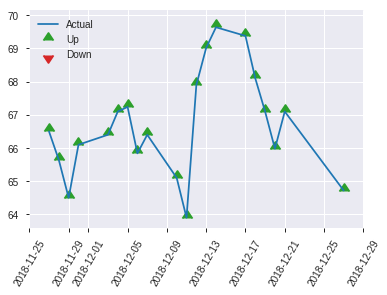


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2535656049203925
RMSE: 0.5035529812446675
LogLoss: 0.7008607275837095
Mean Per-Class Error: 0.42771317829457356
AUC: 0.5676679586563308
pr_auc: 0.5755841467680878
Gini: 0.1353359173126616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28197720646858215: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    118  0.9833   (118.0/120.0)
1      0    129  0        (0.0/129.0)
Total  2    247  0.4739   (118.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281977     0.68617   245
max f2                       0.281977     0.845347  245
max f0point5                 0.413269     0.591241  137
max accuracy                 0.413269     0.574297  137
max precision                0.653278     1         0
max recall                   0.281977     1         245
max specificity              0.653278     1         0
max absolute_mcc             0.506255     0.181447  43
max min_per_class_accuracy   0.423428     0.55      123
max mean_per_class_accuracy  0.413269     0.572287  137

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 42.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.601673           0.643411  0.643411           0.333333         0.624876  0.333333                    0.624876            0.00775194      0.00775194                 -35.6589  -35.6589
    2        0.0200803                   0.594487           1.93023   1.15814            1                0.600063  0.6                         0.614951            0.0155039       0.0232558                  93.0233   15.814
    3        0.0321285                   0.583342           1.28682   1.2064             0.666667         0.590129  0.625                       0.605643            0.0155039       0.0387597                  28.6822   20.6395
    4        0.0401606                   0.576089           0         0.965116           0                0.581562  0.5                         0.600827            0               0.0387597                  -100      -3.48837
    5        0.0522088                   0.565651           1.93023   1.18784            1                0.573315  0.615385                    0.594478            0.0232558       0.0620155                  93.0233   18.7835
    6        0.100402                    0.54381            1.44767   1.31256            0.75             0.552578  0.68                        0.574366            0.0697674       0.131783                   44.7674   31.2558
    7        0.15261                     0.520974           1.33631   1.32069            0.692308         0.534729  0.684211                    0.560806            0.0697674       0.20155                    33.6315   32.0685
    8        0.200803                    0.493321           1.28682   1.31256            0.666667         0.506257  0.68                        0.547714            0.0620155       0.263566                   28.6822   31.2558
    9        0.301205                    0.464265           0.694884  1.10667            0.36             0.47766   0.573333                    0.524363            0.0697674       0.333333                   -30.5116  10.6667
    10       0.401606                    0.437336           1.00372   1.08093            0.52             0.452471  0.56                        0.50639             0.100775        0.434109                   0.372093  8.09302
    11       0.502008                    0.423428           1.15814   1.09637            0.6              0.429181  0.568                       0.490948            0.116279        0.550388                   15.814    9.63721
    12       0.598394                    0.404492           1.04554   1.08818            0.541667         0.41474   0.563758                    0.478673            0.100775        0.651163                   4.55426   8.81848
    13       0.698795                    0.382837           0.926512  1.06496            0.48             0.393241  0.551724                    0.466398            0.0930233       0.744186                   -7.34884  6.49559
    14       0.799197                    0.365714           0.772093  1.02816            0.4              0.374665  0.532663                    0.454874            0.0775194       0.821705                   -22.7907  2.81641
    15       0.899598                    0.330201           0.926512  1.01682            0.48             0.351576  0.526786                    0.443345            0.0930233       0.914729                   -7.34884  1.68189
    16       1                           0.272401           0.849302  1                  0.44             0.308972  0.518072                    0.429854        

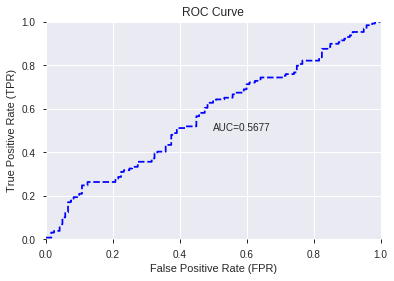

This function is available for GLM models only


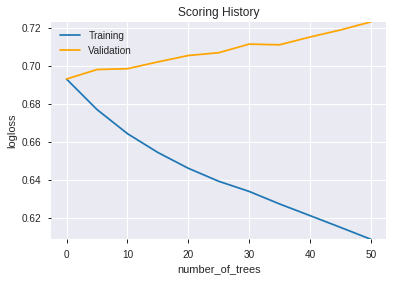

--2019-08-25 12:17:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_121636_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_121636_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ROCP_14',
 'SIN',
 'ROCR100_24',
 'MACD_hist',
 'MACDFIX_signal_12',
 'RSI_14',
 'CORREL_8',
 'BBANDS_lowerband_30_7_5',
 'CORREL_12',
 'MACDFIX_24',
 'ATR_12',
 'BBANDS_upperband_30_5_5',
 'NATR_24',
 'aroonup_20',
 'BBANDS_lowerband_8_0_4',
 'BBANDS_lowerband_12_4_5',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_upperband_14_7_3',
 'BBANDS_middleband_20_3_4',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_lowerband_14_3_3',
 'dayofweek',
 'BBANDS_middleband_8_5_4',
 'BBANDS_middleband_24_5_4',
 'MA_8_6',
 'days_in_month',
 'MAVP_8_4',
 'BBANDS_middleband_20_6_5',
 'BBANDS_middleband_14_5_3',
 'MA_12_1',
 'BBANDS_lowerband_8_5_3',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_middleband_20_1_5',
 'BBANDS_middleband_8_3_3',
 'BBANDS_middleband_8_2_3',
 'BBANDS_upperband_20_6_2',
 'CDLBELTHOLD',
 'LINEARREG_20',
 'ADD',
 'BBANDS_middleband_8_7_5',
 'MA_24_1']

In [0]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_121804_model_1  0.564147  0.717561              0.478295  0.499673  0.249673

variable  relative_importance  scaled_importance  percentage
0                          BOP             0.008632           1.000000    0.016149
1                 CDLTASUKIGAP             0.007989           0.925456    0.014945
2           CDLCLOSINGMARUBOZU             0.007781           0.901355    0.014556
3                 CDLSHORTLINE             0.007147           0.827956    0.013371
4                 weekday_name             0.006842           0.792600    0.012800
...                        ...                  ...                ...         ...
1040  BBANDS_middleband_14_1_3             0.000000           0.000000    0.000000
1041  BBANDS_middleband_14_1_4             0.000000           0.000000    0.000000
1042  BBANDS_middleband_14_1_5             0.000000           0.000000    0.000000
1043   BBANDS_lowerband_14_2_3             0.000000           0.000000    0.000000
1044                    WMA_20             0.000000           0.000000    0.000000

[1045 rows x 4 columns]

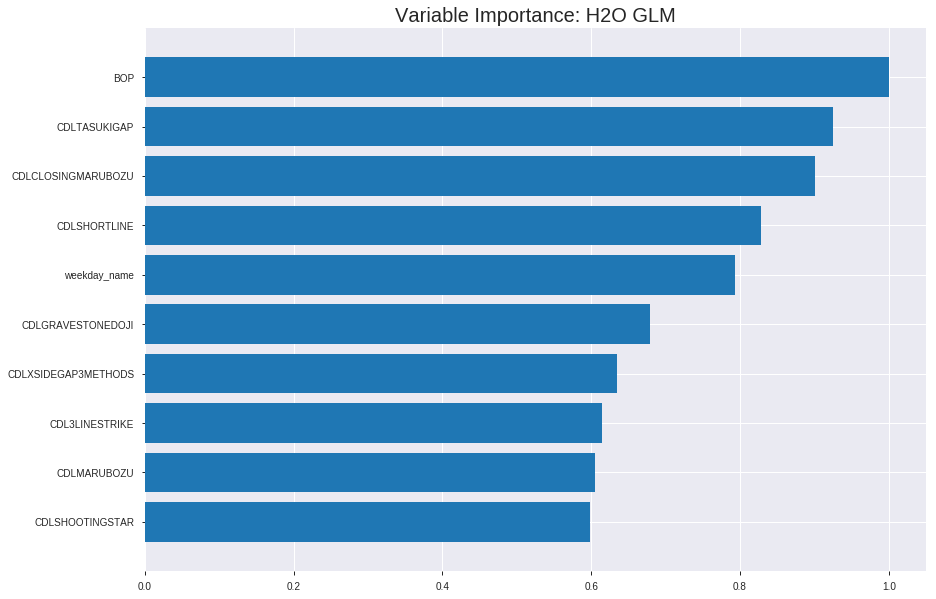

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_121804_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24684789542528035
RMSE: 0.4968378965269058
LogLoss: 0.6868307383552573
Null degrees of freedom: 1740
Residual degrees of freedom: 701
Null deviance: 2412.986471918777
Residual deviance: 2391.544630953006
AIC: 4471.544630953006
AUC: 0.5902056684223727
pr_auc: 0.5857638442019766
Gini: 0.1804113368447453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4752258400572335: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      67   788   0.9216   (788.0/855.0)
1      30   856   0.0339   (30.0/886.0)
Total  97   1644  0.4698   (818.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475226     0.67668   353
max f2                       0.454714     0.839015  394
max f0point5                 0.499989     0.581839  246
max accuracy                 0.508942     0.574383  203
max precision                0.578625     1         0
max recall                   0.454714     1         394
max specificity              0.578625     1         0
max absolute_mcc             0.508942     0.149225  203
max min_per_class_accuracy   0.508305     0.567251  206
max mean_per_class_accuracy  0.508942     0.574606  203

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.557732           1.52834   1.52834            0.777778         0.563419  0.777778                    0.563419            0.0158014       0.0158014                  52.8342   52.8342
    2        0.0201034                   0.552552           1.27148   1.40358            0.647059         0.555161  0.714286                    0.559408            0.0124153       0.0282167                  27.1478   40.3579
    3        0.0304423                   0.548808           0.764171  1.18642            0.388889         0.550272  0.603774                    0.556305            0.00790068      0.0361174                  -23.5829  18.6422
    4        0.0402068                   0.546941           1.50266   1.26322            0.764706         0.547777  0.642857                    0.554234            0.0146727       0.0507901                  50.2656   26.3222
    5        0.0505457                   0.545143           1.09167   1.22813            0.555556         0.546022  0.625                       0.552554            0.0112867       0.0620767                  9.16729   22.8132
    6        0.100517                    0.538301           1.31001   1.26884            0.666667         0.541238  0.645714                    0.546929            0.0654628       0.12754                    31.0008   26.8836
    7        0.150488                    0.533591           1.24225   1.26001            0.632184         0.535922  0.641221                    0.543274            0.0620767       0.189616                   24.2249   26.0007
    8        0.20046                     0.52966            1.17449   1.23869            0.597701         0.531711  0.630372                    0.540391            0.0586907       0.248307                   17.449    23.8689
    9        0.300402                    0.522005           1.08414   1.18727            0.551724         0.525824  0.604207                    0.535545            0.108352        0.356659                   8.41442   18.7273
    10       0.400345                    0.514905           1.05026   1.15307            0.534483         0.518364  0.586801                    0.531256            0.104966        0.461625                   5.02647   15.307
    11       0.500287                    0.508272           1.06156   1.13479            0.54023          0.511517  0.577497                    0.527312            0.106095        0.56772                    6.15578   13.4788
    12       0.60023                     0.501519           0.858281  1.08875            0.436782         0.504764  0.554067                    0.523558            0.0857788       0.653499                   -14.1719  8.87479
    13       0.700172                    0.495512           0.971212  1.07197            0.494253         0.498363  0.545529                    0.519962            0.0970655       0.750564                   -2.87875  7.19709
    14       0.800115                    0.489164           0.903453  1.05092            0.45977          0.492149  0.534817                    0.516488            0.0902935       0.840858                   -9.65465  5.09213
    15       0.900057                    0.480775           0.880867  1.03204            0.448276         0.485231  0.525207                    0.513017            0.0880361       0.928894                   -11.9133  3.20385
    16       1                           0.422935           0.71147   1                  0.362069         0.471855  0.508903                    0.508903          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3843651119332489
RMSE: 0.6199718638238746
LogLoss: 8.705422142531352
Null degrees of freedom: 497
Residual degrees of freedom: -542
Null deviance: 689.962659370588
Residual deviance: 139813.9933976815
AIC: 141893.9933976815
AUC: 0.5060464665708704
pr_auc: 0.5207445673059916
Gini: 0.012092933141740758
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.9888903633865874e-54: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    241  1        (241.0/241.0)
1      0    257  0        (0.0/257.0)
Total  0    498  0.4839   (241.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       4.98889e-54  0.680795   290
max f2                       4.98889e-54  0.842071   290
max f0point5                 4.98889e-54  0.571365   290
max accuracy                 0.469641     0.518072   210
max precision                0.521437     0.621622   36
max recall                   4.98889e-54  1          290
max specificity              0.548956     0.995851   0
max absolute_mcc             0.545455     0.0803926  2
max min_per_class_accuracy   0.145023     0.498054   247
max mean_per_class_accuracy  0.502046     0.521167   107

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 24.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.540955           0.387549  0.387549           0.2              0.545343      0.2                         0.545343            0.00389105      0.00389105                 -61.2451  -61.2451
    2        0.0200803                   0.533505           1.16265   0.775097           0.6              0.536283      0.4                         0.540813            0.0116732       0.0155642                  16.2646   -22.4903
    3        0.0301205                   0.529095           1.16265   0.90428            0.6              0.531893      0.466667                    0.53784             0.0116732       0.0272374                  16.2646   -9.57198
    4        0.0401606                   0.527529           0.775097  0.871984           0.4              0.527959      0.45                        0.53537             0.0077821       0.0350195                  -22.4903  -12.8016
    5        0.0502008                   0.525348           1.16265   0.930117           0.6              0.526994      0.48                        0.533695            0.0116732       0.0466926                  16.2646   -6.98833
    6        0.100402                    0.516267           1.24016   1.08514            0.64             0.521296      0.56                        0.527496            0.0622568       0.108949                   24.0156   8.51362
    7        0.150602                    0.508595           0.930117  1.03346            0.48             0.51149       0.533333                    0.522161            0.0466926       0.155642                   -6.98833  3.3463
    8        0.200803                    0.502985           1.16265   1.06576            0.6              0.50598       0.55                        0.518115            0.0583658       0.214008                   16.2646   6.57588
    9        0.301205                    0.491507           1.00763   1.04638            0.52             0.497883      0.54                        0.511371            0.101167        0.315175                   0.762646  4.63813
    10       0.399598                    0.477604           0.909553  1.01269            0.469388         0.484841      0.522613                    0.504839            0.0894942       0.404669                   -9.04471  1.26899
    11       0.5                         0.117261           0.930117  0.996109           0.48             0.428223      0.514056                    0.489454            0.0933852       0.498054                   -6.98833  -0.389105
    12       0.600402                    8.26367e-124       1.12389   1.01748            0.58             0.0051548     0.525084                    0.408467            0.11284         0.610895                   12.3891   1.74772
    13       1                           0                  0.97374   1                  0.502513         3.18871e-127  0.516064                    0.245245            0.389105        1                          -2.62597  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:18:07  0.000 sec   2            3.7       1040          1.37366           280.751
    2019-08-25 12:18:09  1.996 sec   4            2.7       1040          1.37055           288.324
    2019-08-25 12:18:11  3.971 sec   6            2         1045          1.36687           295.208
    2019-08-25 12:18:13  5.991 sec   8            1.4       1045          1.36251           300.479
    2019-08-25 12:18:15  7.962 sec   10           1         1046          1.35749           304.389

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.570281124497992)

('F1', 0.6866485013623979)

('auc', 0.5641472868217055)

('logloss', 0.7175612312731569)

('mean_per_class_error', 0.4344961240310077)

('rmse', 0.49967311909187423)

('mse', 0.24967322594300234)

glm prediction progress: |████████████████████████████████████████████████| 100%


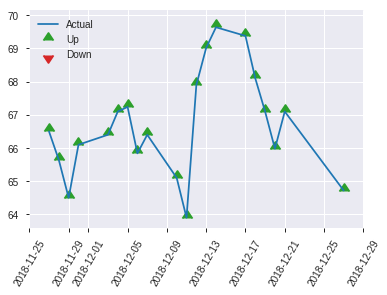


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24967322594300234
RMSE: 0.49967311909187423
LogLoss: 0.7175612312731569
Null degrees of freedom: 248
Residual degrees of freedom: -791
Null deviance: 344.9457142036249
Residual deviance: 357.34549317403184
AIC: 2437.3454931740316
AUC: 0.5641472868217055
pr_auc: 0.5763423362588059
Gini: 0.1282945736434109
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3877160083556633: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    112  0.9333   (112.0/120.0)
1      3    126  0.0233   (3.0/129.0)
Total  11   238  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387716     0.686649  237
max f2                       0.00027695   0.845347  246
max f0point5                 0.483587     0.597884  203
max accuracy                 0.483587     0.570281  203
max precision                0.53613      0.8       14
max recall                   0.00027695   1         246
max specificity              0.555316     0.991667  0
max absolute_mcc             0.483587     0.152758  203
max min_per_class_accuracy   0.501379     0.51938   123
max mean_per_class_accuracy  0.512262     0.565504  74

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 48.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.547734           0.643411  0.643411           0.333333         0.552546  0.333333                    0.552546            0.00775194      0.00775194                 -35.6589  -35.6589
    2        0.0200803                   0.54411            1.93023   1.15814            1                0.544517  0.6                         0.549334            0.0155039       0.0232558                  93.0233   15.814
    3        0.0321285                   0.540538           1.93023   1.44767            1                0.54263   0.75                        0.54682             0.0232558       0.0465116                  93.0233   44.7674
    4        0.0401606                   0.538164           0.965116  1.35116            0.5              0.538917  0.7                         0.54524             0.00775194      0.0542636                  -3.48837  35.1163
    5        0.0522088                   0.536896           1.93023   1.48479            1                0.537462  0.769231                    0.543445            0.0232558       0.0775194                  93.0233   48.4794
    6        0.100402                    0.527823           0.965116  1.23535            0.5              0.532678  0.64                        0.538277            0.0465116       0.124031                   -3.48837  23.5349
    7        0.15261                     0.52387            1.03936   1.1683             0.538462         0.525779  0.605263                    0.534001            0.0542636       0.178295                   3.9356    16.8299
    8        0.200803                    0.518995           1.12597   1.15814            0.583333         0.521226  0.6                         0.530935            0.0542636       0.232558                   12.5969   15.814
    9        0.301205                    0.512216           1.31256   1.20961            0.68             0.515277  0.626667                    0.525716            0.131783        0.364341                   31.2558   20.9612
    10       0.401606                    0.505839           0.849302  1.11953            0.44             0.508954  0.58                        0.521526            0.0852713       0.449612                   -15.0698  11.9535
    11       0.502008                    0.501347           0.694884  1.0346             0.36             0.503104  0.536                       0.517841            0.0697674       0.51938                    -30.5116  3.46047
    12       0.598394                    0.497274           0.88469   1.01046            0.458333         0.499311  0.52349                     0.514856            0.0852713       0.604651                   -11.531   1.04573
    13       0.698795                    0.492194           1.23535   1.04277            0.64             0.49469   0.54023                     0.511959            0.124031        0.728682                   23.5349   4.27693
    14       0.799197                    0.485426           1.23535   1.06696            0.64             0.488852  0.552764                    0.509056            0.124031        0.852713                   23.5349   6.69627
    15       0.899598                    0.469704           0.617674  1.01682            0.32             0.480022  0.526786                    0.505816            0.0620155       0.914729                   -38.2326  1.68189
    16       1                           2.22053e-07        0.849302  1                  0.44             0.322342  0.518072                    0.487394          

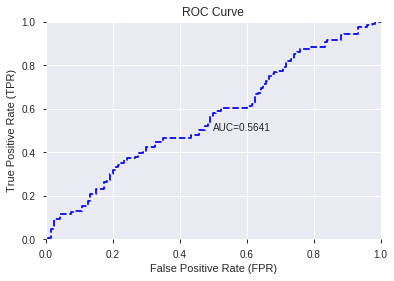

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


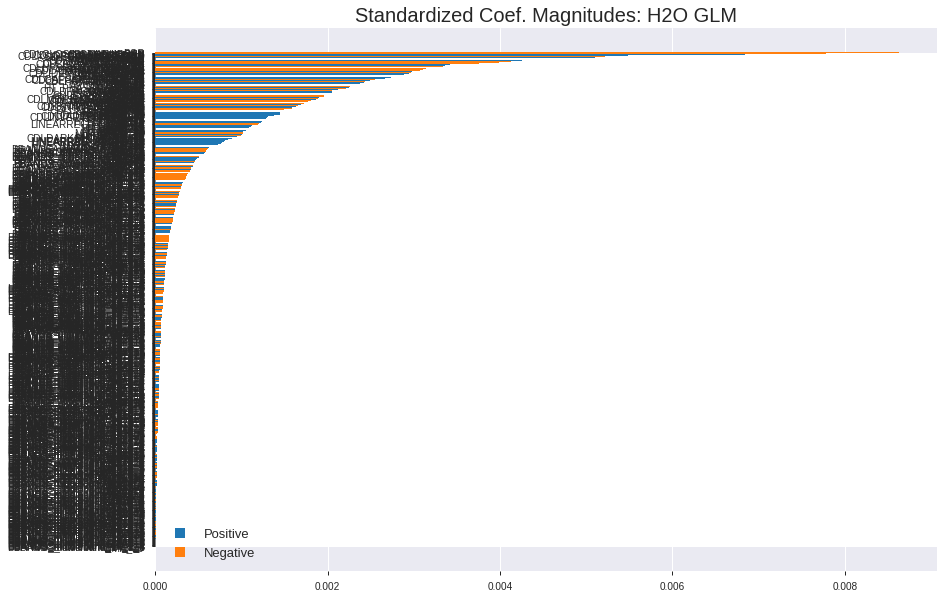

'log_likelihood'
--2019-08-25 12:18:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.0.24
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.0.24|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_121804_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_121804_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

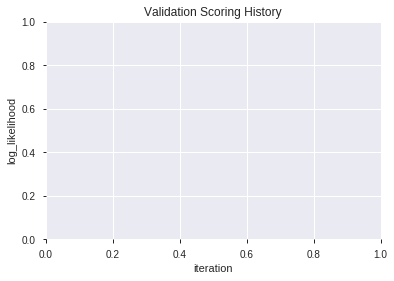

In [0]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [0]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [0]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [0]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_121938_model_1  0.602907  0.680020              0.487500  0.493465  0.243508
1  XGBoost_grid_1_AutoML_20190825_121938_model_6  0.573966  0.694037              0.500000  0.500180  0.250180
2               XGBoost_3_AutoML_20190825_121938  0.559044  0.687350              0.448547  0.497165  0.247173
3  XGBoost_grid_1_AutoML_20190825_121938_model_3  0.557817  0.689069              0.483333  0.497969  0.247973
4  XGBoost_grid_1_AutoML_20190825_121938_model_5  0.555556  0.705563              0.469671  0.505824  0.255858
5               XGBoost_2_AutoML_20190825_121938  0.553359  0.689046              0.461628  0.498018  0.248022
6  XGBoost_grid_1_AutoML_20190825_121938_model_2  0.551744  0.688483              0.448837  0.497728  0.247733
7  XGBoost_grid_1_AutoML_20190825_121938_model_4  0.539599  0.691321              0.469961  0.499063  0.249064
8               XGBoost_1_AutoML_20190825_121938  0.511047  0.705117              0.491376  0.505755  0.255788
9  XGBoost_grid_1_AutoML_20190825_121938_model_7  0.509044  0.714086              0.457752  0.509760  0.259855

variable  relative_importance  scaled_importance  percentage
0                        BOP           178.859344           1.000000    0.040313
1                STOCH_slowd           108.085785           0.604306    0.024362
2                     MFI_12            76.945961           0.430204    0.017343
3          HT_PHASOR_inphase            76.796906           0.429370    0.017309
4                      ROC_8            67.028358           0.374755    0.015108
..                       ...                  ...                ...         ...
196  BBANDS_lowerband_20_0_4             3.738269           0.020901    0.000843
197                   MOM_20             3.641142           0.020358    0.000821
198                    DX_14             3.636367           0.020331    0.000820
199                     DX_8             3.450155           0.019290    0.000778
200                     High             3.370272           0.018843    0.000760

[201 rows x 4 columns]

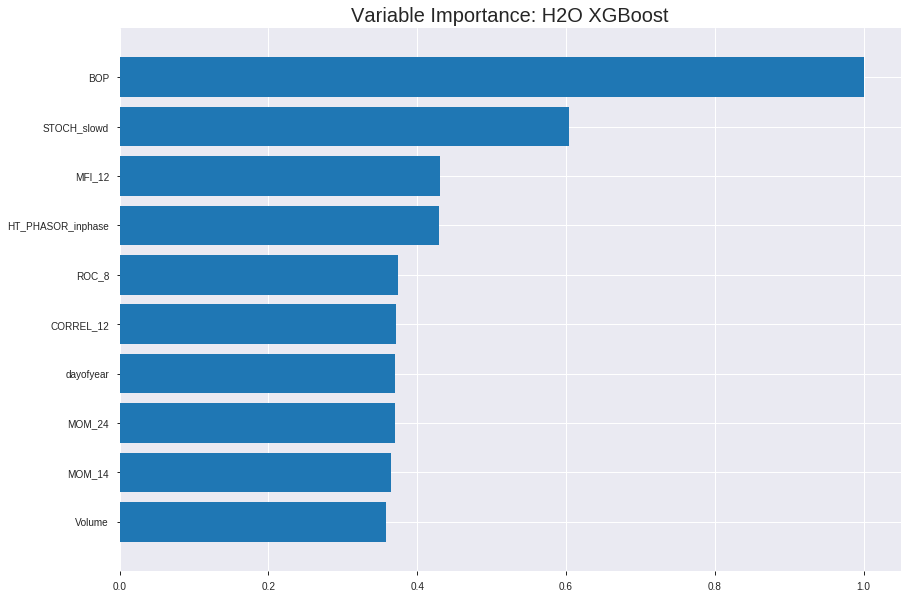

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_121938_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1893162821714324
RMSE: 0.4351049093855784
LogLoss: 0.5689314342394436
Mean Per-Class Error: 0.14381674653149057
AUC: 0.9314053568835557
pr_auc: 0.9352961157716564
Gini: 0.8628107137671115
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4997816350724962: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      721  134  0.1567   (134.0/855.0)
1      119  767  0.1343   (119.0/886.0)
Total  840  901  0.1453   (253.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499782     0.858422  211
max f2                       0.457961     0.902925  256
max f0point5                 0.516104     0.872467  191
max accuracy                 0.508043     0.85583   202
max precision                0.793735     1         0
max recall                   0.389748     1         330
max specificity              0.793735     1         0
max absolute_mcc             0.508043     0.712513  202
max min_per_class_accuracy   0.502077     0.854971  208
max mean_per_class_accuracy  0.508043     0.856183  202

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.730186           1.96501   1.96501            1                0.757108  1                           0.757108            0.020316        0.020316                   96.5011   96.5011
    2        0.0201034                   0.705409           1.96501   1.96501            1                0.718705  1                           0.738455            0.0191874       0.0395034                  96.5011   96.5011
    3        0.0304423                   0.686393           1.96501   1.96501            1                0.692574  1                           0.722873            0.020316        0.0598194                  96.5011   96.5011
    4        0.0402068                   0.676133           1.96501   1.96501            1                0.681623  1                           0.712855            0.0191874       0.0790068                  96.5011   96.5011
    5        0.0505457                   0.66712            1.96501   1.96501            1                0.67126   1                           0.704347            0.020316        0.0993228                  96.5011   96.5011
    6        0.100517                    0.637328           1.96501   1.96501            1                0.652402  1                           0.678523            0.0981941       0.197517                   96.5011   96.5011
    7        0.150488                    0.612471           1.89725   1.94251            0.965517         0.624427  0.98855                     0.66056             0.0948081       0.292325                   89.7252   94.2511
    8        0.20046                     0.598431           1.94242   1.94249            0.988506         0.605199  0.988539                    0.646759            0.0970655       0.389391                   94.2425   94.249
    9        0.300402                    0.563228           1.80691   1.89738            0.91954          0.58101   0.965583                    0.624885            0.180587        0.569977                   80.6907   89.7382
    10       0.400345                    0.531756           1.4907    1.79586            0.758621         0.547398  0.913917                    0.605541            0.148984        0.718962                   49.0698   79.5857
    11       0.500287                    0.502875           1.28742   1.69429            0.655172         0.51705   0.862227                    0.587863            0.128668        0.84763                    28.7421   69.4286
    12       0.60023                     0.475611           0.722763  1.53252            0.367816         0.489985  0.779904                    0.571566            0.0722348       0.919865                   -27.7237  53.2521
    13       0.700172                    0.449647           0.485606  1.38308            0.247126         0.463513  0.703856                    0.556142            0.0485327       0.968397                   -51.4394  38.3084
    14       0.800115                    0.420722           0.24845   1.24136            0.126437         0.435584  0.63173                     0.541083            0.0248307       0.993228                   -75.155   24.1357
    15       0.900057                    0.385019           0.067759  1.11104            0.0344828        0.403704  0.565412                    0.525829            0.00677201      1                          -93.2241  11.104
    16       1                           0.253071           0         1                  0                0.348905  0.508903                    0.508146           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25798774774003347
RMSE: 0.5079249430181919
LogLoss: 0.7096946644414409
Mean Per-Class Error: 0.4478986712304438
AUC: 0.5427611928249673
pr_auc: 0.540669124562576
Gini: 0.08552238564993453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30403846502304077: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      21   220  0.9129   (220.0/241.0)
1      6    251  0.0233   (6.0/257.0)
Total  27   471  0.4538   (226.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304038     0.68956   373
max f2                       0.219294     0.842071  399
max f0point5                 0.340471     0.590189  333
max accuracy                 0.370978     0.560241  295
max precision                0.732685     1         0
max recall                   0.219294     1         399
max specificity              0.732685     1         0
max absolute_mcc             0.304038     0.14078   373
max min_per_class_accuracy   0.421461     0.513619  199
max mean_per_class_accuracy  0.370978     0.552101  295

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 42.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.62706            0.775097  0.775097           0.4              0.664247  0.4                         0.664247            0.0077821       0.0077821                  -22.4903  -22.4903
    2        0.0200803                   0.606269           1.16265   0.968872           0.6              0.616719  0.5                         0.640483            0.0116732       0.0194553                  16.2646   -3.11284
    3        0.0301205                   0.597622           1.55019   1.16265            0.8              0.602597  0.6                         0.627855            0.0155642       0.0350195                  55.0195   16.2646
    4        0.0401606                   0.585934           1.93774   1.35642            1                0.591112  0.7                         0.618669            0.0194553       0.0544747                  93.7743   35.642
    5        0.0502008                   0.571952           0.775097  1.24016            0.4              0.576623  0.64                        0.61026             0.0077821       0.0622568                  -22.4903  24.0156
    6        0.100402                    0.548594           0.852607  1.04638            0.44             0.560975  0.54                        0.585617            0.0428016       0.105058                   -14.7393  4.63813
    7        0.150602                    0.522465           0.930117  1.00763            0.48             0.536019  0.52                        0.569084            0.0466926       0.151751                   -6.98833  0.762646
    8        0.200803                    0.500001           1.24016   1.06576            0.64             0.509686  0.55                        0.554235            0.0622568       0.214008                   24.0156   6.57588
    9        0.301205                    0.46893            0.968872  1.03346            0.5              0.484045  0.533333                    0.530838            0.0972763       0.311284                   -3.11284  3.3463
    10       0.399598                    0.445311           1.14683   1.06138            0.591837         0.4552    0.547739                    0.512214            0.11284         0.424125                   14.6828   6.13769
    11       0.5                         0.419768           0.891362  1.02724            0.46             0.434319  0.53012                     0.496572            0.0894942       0.513619                   -10.8638  2.72374
    12       0.600402                    0.397112           1.08514   1.03692            0.56             0.408917  0.535117                    0.481914            0.108949        0.622568                   8.51362   3.69194
    13       0.698795                    0.37866            1.10728   1.04683            0.571429         0.387624  0.54023                     0.468638            0.108949        0.731518                   10.7282   4.68268
    14       0.799197                    0.358694           1.12389   1.05651            0.58             0.370866  0.545226                    0.456355            0.11284         0.844358                   12.3891   5.65082
    15       0.899598                    0.323403           0.813852  1.02943            0.42             0.341983  0.53125                     0.44359             0.0817121       0.92607                    -18.6148  2.94261
    16       1                           0.219294           0.736342  1                  0.38             0.295165  0.516064                    0.428688        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:19:52  0.011 sec   0                  0.5              0.693147            0.5             0                  1                0.491097                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-25 12:19:53  0.649 sec   5                  0.489256         0.671857            0.789613        0.783532           1.96501          0.294084                         0.499703           0.692553              0.530248          0.545087             1.21109            0.477912
    2019-08-25 12:19:53  0.858 sec   10                 0.479062         0.651955            0.831918        0.830592           1.86159          0.262493                         0.498991           0.691118              0.537223          0.547744             1.16265            0.46988
    2019-08-25 12:19:53  1.061 sec   15                 0.472819         0.639893            0.854675        0.856802           1.96501          0.2556                           0.500225           0.69359               0.543359          0.55101              0.775097           0.453815
    2019-08-25 12:19:53  1.291 sec   20                 0.465683         0.62617             0.865228        0.872231           1.96501          0.231476                         0.50068            0.69446               0.546031          0.551852             1.55019            0.459839
    2019-08-25 12:19:53  1.488 sec   25                 0.459166         0.613774            0.881814        0.88827            1.96501          0.20448                          0.501075           0.695208              0.552174          0.55294              1.55019            0.437751
    2019-08-25 12:19:54  1.685 sec   30                 0.45282          0.601813            0.89779         0.903303           1.96501          0.178633                         0.501869           0.696844              0.547831          0.553826             1.55019            0.449799
    2019-08-25 12:19:54  1.871 sec   35                 0.44853          0.593732            0.905019        0.91067            1.96501          0.17174                          0.50344            0.700068              0.54482           0.549565             1.16265            0.443775
    2019-08-25 12:19:54  2.064 sec   40                 0.443504         0.584415            0.916226        0.92108            1.96501          0.166571                         0.504742           0.702856              0.543851          0.545354             1.55019            0.457831
    2019-08-25 12:19:54  2.274 sec   45                 0.438398         0.575003            0.925825        0.929865           1.96501          0.152211                         0.506206           0.705944              0.541284          0.541058             0.775097           0.441767
    2019-08-25 12:19:54  2.490 sec   50                 0.435105         0.568931            0.931405        0.935296           1.96501          0.145319                         0.507925           0.709695              0.542761          0.540669             0.775097           0.453815

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BOP                      178.85934448242188     1.0                   0.040313427253275365
STOCH_slowd              108.08578491210938     0.6043060552686524    0.02436164819778662
MFI_12                   76.94596099853516      0.4302037515635496    0.017342987642743304
HT_PHASOR_inphase        76.79690551757812      0.4293703845321073    0.017309391761545976
ROC_8                    67.02835845947266      0.37475457965831993   0.015107641484887468
---                      ---                    ---                   ---
BBANDS_lowerband_20_0_4  3.7382686138153076     0.020900605582744383  0.0008425750427093667
MOM_20                   3.641141891479492      0.02035757148733898   0.0008206834772081927
DX_14                    3.636366844177246      0.020330874267151442  0.0008196072207642977
DX_8                     3.4501545429229736     0.019289763992521237  0.0007776364974453555
High                     3.370271921157837      0.0188431414132185    0.0007596316105849642


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5823293172690763)

('F1', 0.6880000000000001)

('auc', 0.6029069767441861)

('logloss', 0.6800201671002525)

('mean_per_class_error', 0.41133720930232553)

('rmse', 0.4934652866839955)

('mse', 0.24350798916211785)

xgboost prediction progress: |████████████████████████████████████████████| 100%


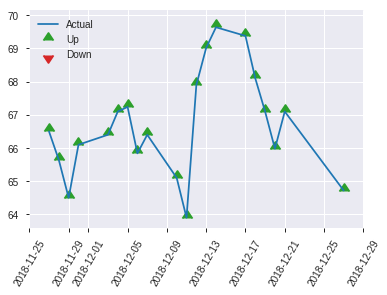


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24350798916211785
RMSE: 0.4934652866839955
LogLoss: 0.6800201671002525
Mean Per-Class Error: 0.41133720930232553
AUC: 0.6029069767441861
pr_auc: 0.610747210164978
Gini: 0.20581395348837228
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3064655065536499: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    117  0.975    (117.0/120.0)
1      0    129  0        (0.0/129.0)
Total  3    246  0.4699   (117.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.306466     0.688     245
max f2                       0.306466     0.846457  245
max f0point5                 0.460765     0.595745  143
max accuracy                 0.482392     0.582329  112
max precision                0.576408     0.772727  21
max recall                   0.306466     1         245
max specificity              0.666591     0.991667  0
max absolute_mcc             0.525945     0.215002  53
max min_per_class_accuracy   0.477014     0.565891  122
max mean_per_class_accuracy  0.525945     0.588663  53

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 47.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.650665           1.28682   1.28682            0.666667         0.661442  0.666667                    0.661442            0.0155039       0.0155039                  28.6822   28.6822
    2        0.0200803                   0.628546           0.965116  1.15814            0.5              0.637303  0.6                         0.651786            0.00775194      0.0232558                  -3.48837  15.814
    3        0.0321285                   0.61722            1.28682   1.2064             0.666667         0.624924  0.625                       0.641713            0.0155039       0.0387597                  28.6822   20.6395
    4        0.0401606                   0.608043           1.93023   1.35116            1                0.610653  0.7                         0.635501            0.0155039       0.0542636                  93.0233   35.1163
    5        0.0522088                   0.603436           0.643411  1.18784            0.333333         0.606059  0.615385                    0.628707            0.00775194      0.0620155                  -35.6589  18.7835
    6        0.100402                    0.564357           1.60853   1.38977            0.833333         0.583214  0.72                        0.60687             0.0775194       0.139535                   60.8527   38.9767
    7        0.15261                     0.547595           1.33631   1.37148            0.692308         0.554995  0.710526                    0.589124            0.0697674       0.209302                   33.6315   37.1481
    8        0.200803                    0.528421           1.44767   1.38977            0.75             0.538273  0.72                        0.57692             0.0697674       0.27907                    44.7674   38.9767
    9        0.301205                    0.512803           0.926512  1.23535            0.48             0.520248  0.64                        0.558029            0.0930233       0.372093                   -7.34884  23.5349
    10       0.401606                    0.492966           1.08093   1.19674            0.56             0.502071  0.62                        0.54404             0.108527        0.48062                    8.09302   19.6744
    11       0.502008                    0.473682           0.849302  1.12726            0.44             0.483189  0.584                       0.53187             0.0852713       0.565891                   -15.0698  12.7256
    12       0.598394                    0.455474           0.88469   1.08818            0.458333         0.464752  0.563758                    0.521059            0.0852713       0.651163                   -11.531   8.81848
    13       0.698795                    0.433706           1.08093   1.08714            0.56             0.44752   0.563218                    0.510493            0.108527        0.75969                    8.09302   8.71425
    14       0.799197                    0.40936            0.926512  1.06696            0.48             0.420781  0.552764                    0.499222            0.0930233       0.852713                   -7.34884  6.69627
    15       0.899598                    0.375155           0.694884  1.02544            0.36             0.392557  0.53125                     0.487318            0.0697674       0.922481                   -30.5116  2.5436
    16       1                           0.274176           0.772093  1                  0.4              0.338972  0.518072                    0.472424           

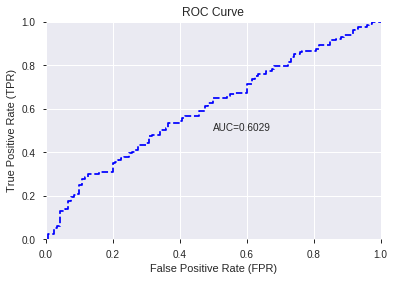

This function is available for GLM models only


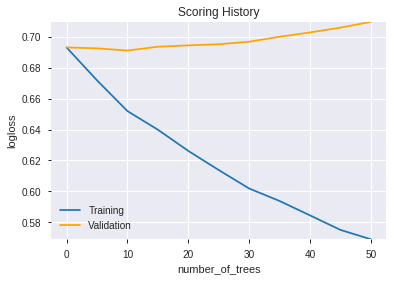

--2019-08-25 12:20:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.138.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.138.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_121938_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_121938_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [0]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_122128_model_3  0.566150  0.796414              0.491667  0.540526  0.292169
1  DeepLearning_grid_1_AutoML_20190825_122128_model_1  0.557752  2.346885              0.491376  0.700674  0.490944
2  DeepLearning_grid_1_AutoML_20190825_122128_model_2  0.557235  0.896710              0.483043  0.575766  0.331507
3               DeepLearning_1_AutoML_20190825_122128  0.554457  0.810600              0.483043  0.539964  0.291561
4  DeepLearning_grid_1_AutoML_20190825_122128_model_5  0.538114  0.691569              0.487500  0.499212  0.249213
5  DeepLearning_grid_1_AutoML_20190825_122128_model_4  0.517765  0.714176              0.487500  0.509688  0.259782
6  DeepLearning_grid_1_AutoML_20190825_122128_model_6  0.504651  0.689215              0.469671  0.498134  0.248138
7  DeepLearning_grid_1_AutoML_20190825_122128_model_8  0.500000  0.693303              0.500000  0.500076  0.250076
8  DeepLearning_grid_1_AutoML_20190825_122128_model_9  0.500000  0.692939              0.500000  0.499895  0.249895
9  DeepLearning_grid_1_AutoML_20190825_122128_model_7  0.450517  0.698405              0.495833  0.502096  0.252101

variable  relative_importance  scaled_importance  percentage
0                CDLPIERCING             1.000000           1.000000    0.048054
1             CDL3BLACKCROWS             0.929233           0.929233    0.044653
2         CDLIDENTICAL3CROWS             0.867730           0.867730    0.041698
3               CDLTHRUSTING             0.805573           0.805573    0.038711
4                        SIN             0.567710           0.567710    0.027281
5                 aroonup_20             0.541309           0.541309    0.026012
6              days_in_month             0.511891           0.511891    0.024598
7                  dayofweek             0.509483           0.509483    0.024483
8                    NATR_24             0.496390           0.496390    0.023853
9    BBANDS_lowerband_30_7_5             0.483349           0.483349    0.023227
10                    RSI_14             0.450554           0.450554    0.021651
11                    ATR_12             0.422160           0.422160    0.020286
12               CDLBELTHOLD             0.416508           0.416508    0.020015
13                  CORREL_8             0.410897           0.410897    0.019745
14         MACDFIX_signal_12             0.410415           0.410415    0.019722
15                ROCR100_24             0.409358           0.409358    0.019671
16                 CORREL_12             0.403993           0.403993    0.019413
17                   ROCP_14             0.385376           0.385376    0.018519
18                 MACD_hist             0.383678           0.383678    0.018437
19                MACDFIX_24             0.373800           0.373800    0.017962
20   BBANDS_lowerband_20_6_5             0.371519           0.371519    0.017853
21              LINEARREG_20             0.362270           0.362270    0.017408
22    BBANDS_lowerband_8_3_2             0.359284           0.359284    0.017265
23   BBANDS_upperband_20_1_3             0.354077           0.354077    0.017015
24   BBANDS_upperband_30_5_5             0.349213           0.349213    0.016781
25    BBANDS_lowerband_8_5_3             0.346598           0.346598    0.016655
26   BBANDS_middleband_8_2_3             0.345083           0.345083    0.016583
27   BBANDS_middleband_8_7_5             0.344734           0.344734    0.016566
28   BBANDS_lowerband_12_4_5             0.344658           0.344658    0.016562
29  BBANDS_middleband_24_5_4             0.342412           0.342412    0.016454
30  BBANDS_middleband_20_3_4             0.340818           0.340818    0.016378
31                    MA_8_6             0.340619           0.340619    0.016368
32   BBANDS_upperband_14_7_3             0.337805           0.337805    0.016233
33   BBANDS_lowerband_14_2_4             0.336525           0.336525    0.016171
34  BBANDS_middleband_30_6_5             0.334202           0.334202    0.016060
35                   MA_24_1             0.332880           0.332880    0.015996
36                       ADD             0.331748           0.331748    0.015942
37   BBANDS_upperband_20_6_2             0.330665           0.330665    0.015890
38                 MAVP_12_7             0.328461           0.328461    0.015784
39                   MA_12_1             0.327142           0.327142    0.015720
40   BBANDS_lowerband_20_2_2             0.326354           0.326354    0.015683
41  BBANDS_middleband_20_1_5             0.324926           0.324926    0.015614
42                   MA_24_6             0.320664           0.320664    0.015409
43   BBANDS_middleband_8_3_3             0.320506           0.320506    0.015401
44    BBANDS_lowerband_8_0_4             0.318966           0.318966    0.015328
45                  MAVP_8_4             0.318764           0.318764    0.015318
46   BBANDS_middleband_8_5_4             0.318553           0.318553    0.015308
47  BBANDS_middleband_20_6_5             0.318393           0.318393    0.015300
48  BBANDS_middleband_14_5_3             0.302629  

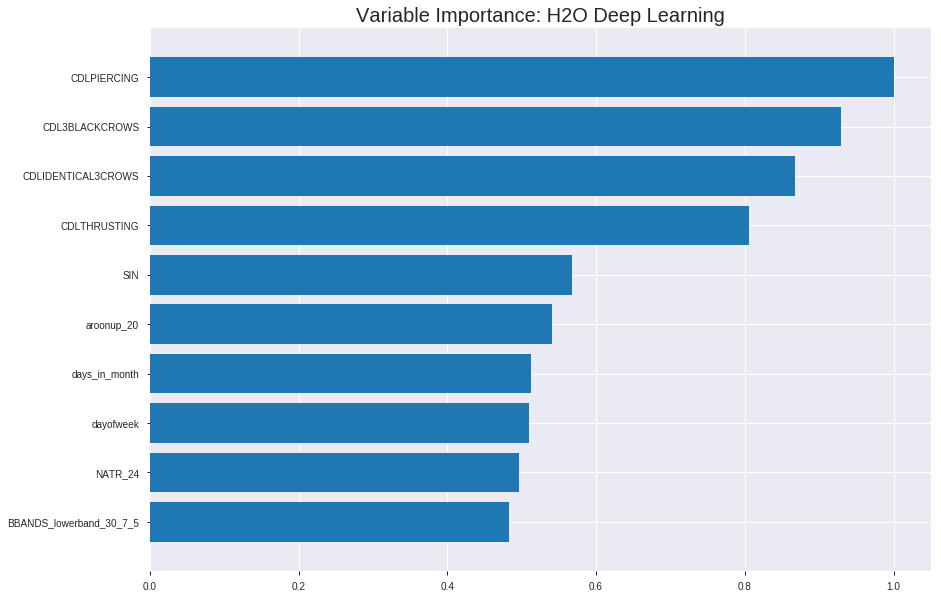

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_122128_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.28928501278091606
RMSE: 0.5378522220656117
LogLoss: 0.7973792764676577
Mean Per-Class Error: 0.4799902314099771
AUC: 0.5140793103903476
pr_auc: 0.5239843088086706
Gini: 0.028158620780695198
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03117752957806293: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    855   1        (855.0/855.0)
1      0    886   0        (0.0/886.0)
Total  0    1741  0.4911   (855.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0311775    0.674534  399
max f2                       0.0311775    0.838221  399
max f0point5                 0.0311775    0.564331  399
max accuracy                 0.481241     0.522688  233
max precision                0.999941     1         0
max recall                   0.0311775    1         399
max specificity              0.999941     1         0
max absolute_mcc             0.877451     0.045395  11
max min_per_class_accuracy   0.561175     0.505643  185
max mean_per_class_accuracy  0.481241     0.52001   233

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 55.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.877607           1.31001   1.31001            0.666667         0.90671   0.666667                    0.90671             0.013544        0.013544                   31.0008   31.0008
    2        0.0201034                   0.865918           1.15589   1.23515            0.588235         0.870405  0.628571                    0.889076            0.0112867       0.0248307                  15.5889   23.515
    3        0.0304423                   0.860536           1.09167   1.18642            0.555556         0.863445  0.603774                    0.880371            0.0112867       0.0361174                  9.16729   18.6422
    4        0.0402068                   0.850797           0.809122  1.09479            0.411765         0.855073  0.557143                    0.874227            0.00790068      0.0440181                  -19.0878  9.4792
    5        0.0505457                   0.843768           0.982506  1.07182            0.5              0.847085  0.545455                    0.868675            0.010158        0.0541761                  -1.74944  7.18243
    6        0.100517                    0.812489           1.01639   1.04426            0.517241         0.827507  0.531429                    0.848209            0.0507901       0.104966                   1.63851   4.42631
    7        0.150488                    0.785609           1.01639   1.03501            0.517241         0.799549  0.526718                    0.832051            0.0507901       0.155756                   1.63851   3.50059
    8        0.20046                     0.760513           1.12932   1.05852            0.574713         0.77216   0.538682                    0.817121            0.0564334       0.21219                    12.9317   5.85161
    9        0.300402                    0.693694           0.903453  1.00693            0.45977          0.726065  0.512428                    0.786827            0.0902935       0.302483                   -9.65465  0.692739
    10       0.400345                    0.622033           1.03897   1.01493            0.528736         0.656796  0.516499                    0.754366            0.103837        0.406321                   3.89715   1.49269
    11       0.500287                    0.558751           1.00509   1.01296            0.511494         0.589523  0.515499                    0.721435            0.100451        0.506772                   0.509198  1.29622
    12       0.60023                     0.507947           1.07285   1.02293            0.545977         0.533479  0.520574                    0.690139            0.107223        0.613995                   7.2851    2.29341
    13       0.700172                    0.454701           1.00509   1.02039            0.511494         0.481662  0.519278                    0.660381            0.100451        0.714447                   0.509198  2.03873
    14       0.800115                    0.375605           0.903453  1.00578            0.45977          0.418644  0.511845                    0.630186            0.0902935       0.80474                    -9.65465  0.578108
    15       0.900057                    0.259854           0.971212  1.00194            0.494253         0.319993  0.509892                    0.595742            0.0970655       0.901806                   -2.87875  0.194258
    16       1                           0.0311775          0.982506  1                  0.5              0.165588  0.508903                    0.552751        



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3597173695572034
RMSE: 0.5997644283860151
LogLoss: 1.027397583114128
Mean Per-Class Error: 0.46747501493453025
AUC: 0.5179133635791208
pr_auc: 0.5102921616821077
Gini: 0.035826727158241534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05763704428745169: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      20   221  0.917    (221.0/241.0)
1      8    249  0.0311   (8.0/257.0)
Total  28   470  0.4598   (229.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.057637     0.685007  375
max f2                       0.00690819   0.842071  399
max f0point5                 0.057637     0.582592  375
max accuracy                 0.0917658    0.542169  329
max precision                0.241624     0.547368  176
max recall                   0.00690819   1         399
max specificity              0.832051     0.995851  0
max absolute_mcc             0.735623     0.113863  16
max min_per_class_accuracy   0.186757     0.497925  220
max mean_per_class_accuracy  0.0917658    0.532525  329

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 24.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.786235           0         0                  0                0.820719   0                           0.820719            0               0                          -100      -100
    2        0.0200803                   0.766482           1.16265   0.581323           0.6              0.773799   0.3                         0.797259            0.0116732       0.0116732                  16.2646   -41.8677
    3        0.0301205                   0.749795           0.387549  0.516732           0.2              0.760148   0.266667                    0.784889            0.00389105      0.0155642                  -61.2451  -48.3268
    4        0.0401606                   0.732472           0.775097  0.581323           0.4              0.738675   0.3                         0.773335            0.0077821       0.0233463                  -22.4903  -41.8677
    5        0.0502008                   0.688048           1.55019   0.775097           0.8              0.711136   0.4                         0.760896            0.0155642       0.0389105                  55.0195   -22.4903
    6        0.100402                    0.545689           1.16265   0.968872           0.6              0.610603   0.5                         0.685749            0.0583658       0.0972763                  16.2646   -3.11284
    7        0.150602                    0.434419           0.930117  0.955953           0.48             0.47119    0.493333                    0.614229            0.0466926       0.143969                   -6.98833  -4.40467
    8        0.200803                    0.361044           1.00763   0.968872           0.52             0.401504   0.5                         0.561048            0.0505837       0.194553                   0.762646  -3.11284
    9        0.301205                    0.277809           1.12389   1.02054            0.58             0.316662   0.526667                    0.479586            0.11284         0.307393                   12.3891   2.05447
    10       0.399598                    0.234241           1.02819   1.02243            0.530612         0.254374   0.527638                    0.424132            0.101167        0.40856                    2.81903   2.24273
    11       0.5                         0.186161           0.891362  0.996109           0.46             0.210218   0.514056                    0.381177            0.0894942       0.498054                   -10.8638  -0.389105
    12       0.600402                    0.150692           1.24016   1.03692            0.64             0.168514   0.535117                    0.345615            0.124514        0.622568                   24.0156   3.69194
    13       0.698795                    0.118772           0.988644  1.03012            0.510204         0.133885   0.531609                    0.315802            0.0972763       0.719844                   -1.13555  3.01221
    14       0.799197                    0.0924373          1.08514   1.03703            0.56             0.10472    0.535176                    0.289284            0.108949        0.828794                   8.51362   3.70334
    15       0.899598                    0.0641411          0.852607  1.01645            0.44             0.0788917  0.524554                    0.265803            0.0856031       0.914397                   -14.7393  1.64501
    16       1                           0.00690819         0.852607  1                  0.44             0.0488051  0.516064             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:23:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:23:05  1 min 35.724 sec  4375 obs/sec      10        1             17410      0.575412         0.961752            -0.324815      0.502094        0.508008           0.982506         0.491097                         0.672056           1.72887               -0.808506        0.531274          0.522217             0.387549           0.461847
    2019-08-25 12:23:11  1 min 41.592 sec  7141 obs/sec      40        4             69640      0.537852         0.797379            -0.157507      0.514079        0.523984           1.31001          0.491097                         0.599764           1.0274                -0.440356        0.517913          0.510292             0                  0.459839
    2019-08-25 12:23:16  1 min 47.245 sec  9101 obs/sec      80        8             139280     0.512889         0.734536            -0.0525557     0.554232        0.563814           1.09167          0.491097                         0.636402           1.27009               -0.621703        0.524073          0.513995             0.387549           0.463855
    2019-08-25 12:23:22  1 min 53.240 sec  10676 obs/sec     130       13            226330     0.510673         0.743797            -0.0434766     0.571294        0.583588           1.41917          0.489374                         0.640912           1.3718                -0.644772        0.527221          0.520227             0.775097           0.465863
    2019-08-25 12:23:28  1 min 58.680 sec  11806 obs/sec     180       18            313380     0.497522         0.709189            0.00957245     0.603452        0.614379           1.52834          0.491097                         0.614852           1.15747               -0.513735        0.529643          0.518484             0.775097           0.483936
    2019-08-25 12:23:33  2 min  3.732 sec  12714 obs/sec     230       23            400430     0.492241         0.714354            0.0304875      0.630382        0.639807           1.63751          0.491097                         0.602406           1.11989               -0.453071        0.53267           0.52026              0.775097           0.455823
    2019-08-25 12:23:39  2 min  9.591 sec  13548 obs/sec     290       29            504890     0.484336         0.707695            0.0613765      0.65418         0.661662           1.63751          0.462952                         0.587517           1.03065               -0.382132        0.533219          0.536099             0.775097           0.463855
    2019-08-25 12:23:44  2 min 15.118 sec  14269 obs/sec     350       35            609350     0.47951          0.703785            0.0799901      0.676078        0.691978           1.63751          0.446295                         0.651284           1.56491               -0.698436        0.534269          0.527144             0.775097           0.451807
    2019-08-25 12:23:49

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
CDLPIERCING               1.0                    1.0                  0.04805372936398408
CDL3BLACKCROWS            0.9292327165603638     0.9292327165603638   0.04465309747775145
CDLIDENTICAL3CROWS        0.867730438709259      0.867730438709259    0.04169768366262591
CDLTHRUSTING              0.8055729269981384     0.8055729269981384   0.03871078341692105
SIN                       0.5677098631858826     0.5677098631858826   0.02728057612279883
---                       ---                    ---                  ---
MAVP_8_4                  0.3187636733055115     0.3187636733055115   0.015317783288092487
BBANDS_middleband_8_5_4   0.3185531795024872     0.3185531795024872   0.015307668275849161
BBANDS_middleband_20_6_5  0.3183932602405548     0.3183932602405548   0.015299983558916175
BBANDS_middleband_14_5_3  0.30262869596481323    0.30262869596481323  0.014542437453668558
BBANDS_lowerband_14_3_3   0.3001658320426941     0.3001658320426941   0.014424087657294724


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5742971887550201)

('F1', 0.6861702127659575)

('auc', 0.5661498708010336)

('logloss', 0.7964138703927278)

('mean_per_class_error', 0.42800387596899225)

('rmse', 0.5405262044763661)

('mse', 0.2921685777256264)

deeplearning prediction progress: |███████████████████████████████████████| 100%


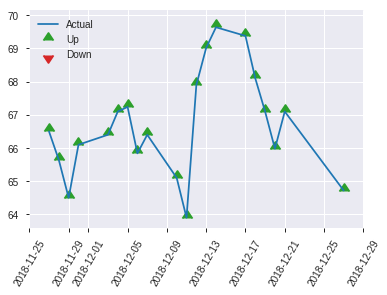


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2921685777256264
RMSE: 0.5405262044763661
LogLoss: 0.7964138703927278
Mean Per-Class Error: 0.42800387596899225
AUC: 0.5661498708010336
pr_auc: 0.5642142403947111
Gini: 0.13229974160206726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.044442152247240005: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    118  0.9833   (118.0/120.0)
1      0    129  0        (0.0/129.0)
Total  2    247  0.4739   (118.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0444422    0.68617   246
max f2                       0.0444422    0.845347  246
max f0point5                 0.286525     0.591631  140
max accuracy                 0.286525     0.574297  140
max precision                0.591378     0.777778  8
max recall                   0.0444422    1         246
max specificity              0.738577     0.991667  0
max absolute_mcc             0.286525     0.145179  140
max min_per_class_accuracy   0.309977     0.550388  123
max mean_per_class_accuracy  0.286525     0.571996  140

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 31.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.682507           1.28682   1.28682            0.666667         0.718043  0.666667                    0.718043            0.0155039       0.0155039                  28.6822   28.6822
    2        0.0200803                   0.654979           0.965116  1.15814            0.5              0.670487  0.6                         0.69902             0.00775194      0.0232558                  -3.48837  15.814
    3        0.0321285                   0.597433           1.93023   1.44767            1                0.628329  0.75                        0.672511            0.0232558       0.0465116                  93.0233   44.7674
    4        0.0401606                   0.540869           0.965116  1.35116            0.5              0.582173  0.7                         0.654443            0.00775194      0.0542636                  -3.48837  35.1163
    5        0.0522088                   0.509589           0.643411  1.18784            0.333333         0.522629  0.615385                    0.624024            0.00775194      0.0620155                  -35.6589  18.7835
    6        0.100402                    0.451378           0.804264  1.00372            0.416667         0.4701    0.52                        0.550141            0.0387597       0.100775                   -19.5736  0.372093
    7        0.15261                     0.424735           1.33631   1.1175             0.692308         0.440518  0.578947                    0.512638            0.0697674       0.170543                   33.6315   11.7503
    8        0.200803                    0.397423           1.12597   1.11953            0.583333         0.410196  0.58                        0.488052            0.0542636       0.224806                   12.5969   11.9535
    9        0.301205                    0.358876           1.15814   1.1324             0.6              0.376169  0.586667                    0.450757            0.116279        0.341085                   15.814    13.2403
    10       0.401606                    0.336795           1.00372   1.10023            0.52             0.347478  0.57                        0.424937            0.100775        0.44186                    0.372093  10.0233
    11       0.502008                    0.309124           1.08093   1.09637            0.56             0.323417  0.568                       0.404633            0.108527        0.550388                   8.09302   9.63721
    12       0.598394                    0.274074           1.12597   1.10114            0.583333         0.291387  0.57047                     0.386392            0.108527        0.658915                   12.5969   10.1139
    13       0.698795                    0.243255           0.849302  1.06496            0.44             0.261335  0.551724                    0.368424            0.0852713       0.744186                   -15.0698  6.49559
    14       0.799197                    0.217913           0.849302  1.03786            0.44             0.227898  0.537688                    0.35077             0.0852713       0.829457                   -15.0698  3.78637
    15       0.899598                    0.171959           0.849302  1.01682            0.44             0.199388  0.526786                    0.333875            0.0852713       0.914729                   -15.0698  1.68189
    16       1                           0.0351746          0.849302  1                  0.44             0.13344   0.518072                    0.313751         

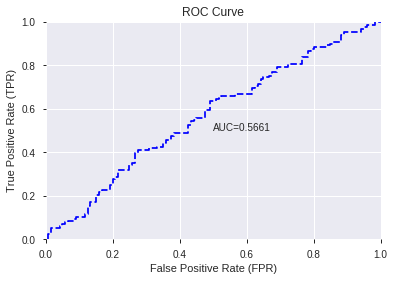

This function is available for GLM models only


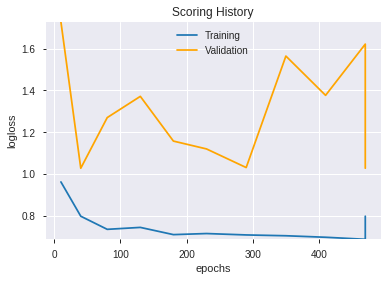

--2019-08-25 12:31:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.144
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.144|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_122128_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_122128_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLPIERCING',
 'CDL3BLACKCROWS',
 'CDLIDENTICAL3CROWS',
 'CDLTHRUSTING',
 'SIN',
 'aroonup_20',
 'days_in_month',
 'dayofweek',
 'NATR_24',
 'BBANDS_lowerband_30_7_5',
 'RSI_14',
 'ATR_12',
 'CDLBELTHOLD',
 'CORREL_8',
 'MACDFIX_signal_12',
 'ROCR100_24',
 'CORREL_12',
 'ROCP_14',
 'MACD_hist',
 'MACDFIX_24',
 'BBANDS_lowerband_20_6_5',
 'LINEARREG_20',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_upperband_20_1_3',
 'BBANDS_upperband_30_5_5',
 'BBANDS_lowerband_8_5_3',
 'BBANDS_middleband_8_2_3',
 'BBANDS_middleband_8_7_5',
 'BBANDS_lowerband_12_4_5',
 'BBANDS_middleband_24_5_4',
 'BBANDS_middleband_20_3_4',
 'MA_8_6',
 'BBANDS_upperband_14_7_3',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_middleband_30_6_5',
 'MA_24_1',
 'ADD',
 'BBANDS_upperband_20_6_2',
 'MAVP_12_7',
 'MA_12_1',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_middleband_20_1_5',
 'MA_24_6',
 'BBANDS_middleband_8_3_3',
 'BBANDS_lowerband_8_0_4',
 'MAVP_8_4',
 'BBANDS_middleband_8_5_4',
 'BBANDS_middleband_20_6_5',
 'BBANDS_middleband_14_5_3

In [0]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_123232_model_1  0.492183  0.697501              0.491667  0.502145  0.252149

variable  relative_importance  scaled_importance  percentage
0                 aroonup_20             0.082624           1.000000    0.065800
1    BBANDS_lowerband_30_7_5             0.076631           0.927462    0.061027
2              days_in_month             0.070833           0.857295    0.056410
3                        SIN             0.066972           0.810568    0.053335
4         CDLIDENTICAL3CROWS             0.066260           0.801946    0.052768
5                     ATR_12             0.063844           0.772711    0.050844
6                   CORREL_8             0.062480           0.756196    0.049758
7                CDLBELTHOLD             0.060484           0.732044    0.048168
8                 ROCR100_24             0.052606           0.636696    0.041895
9   BBANDS_middleband_30_6_5             0.045229           0.547409    0.036020
10   BBANDS_upperband_30_5_5             0.044271           0.535808    0.035256
11                 CORREL_12             0.042463           0.513932    0.033817
12                  MAVP_8_4             0.032305           0.390992    0.025727
13   BBANDS_lowerband_14_2_4             0.028315           0.342694    0.022549
14                   MA_24_6             0.026327           0.318642    0.020967
15   BBANDS_lowerband_20_6_5             0.025653           0.310480    0.020430
16            CDL3BLACKCROWS             0.024634           0.298148    0.019618
17  BBANDS_middleband_20_6_5             0.024626           0.298044    0.019611
18                       ADD             0.024465           0.296105    0.019484
19   BBANDS_upperband_20_6_2             0.024175           0.292586    0.019252
20                 dayofweek             0.024078           0.291414    0.019175
21               CDLPIERCING             0.020151           0.243887    0.016048
22   BBANDS_lowerband_12_4_5             0.019884           0.240660    0.015835
23                    RSI_14             0.018960           0.229470    0.015099
24                   ROCP_14             0.018654           0.225764    0.014855
25   BBANDS_lowerband_14_3_3             0.018432           0.223086    0.014679
26              LINEARREG_20             0.017991           0.217752    0.014328
27   BBANDS_middleband_8_5_4             0.017866           0.216232    0.014228
28         MACDFIX_signal_12             0.017119           0.207198    0.013634
29    BBANDS_lowerband_8_0_4             0.015854           0.191880    0.012626
30   BBANDS_upperband_14_7_3             0.015621           0.189063    0.012440
31                   NATR_24             0.014300           0.173068    0.011388
32    BBANDS_lowerband_8_3_2             0.012251           0.148271    0.009756
33                MACDFIX_24             0.011857           0.143500    0.009442
34              CDLTHRUSTING             0.009256           0.112027    0.007371
35                    MA_8_6             0.009065           0.109720    0.007220
36   BBANDS_middleband_8_2_3             0.009034           0.109343    0.007195
37                 MACD_hist             0.009013           0.109090    0.007178
38                   MA_12_1             0.007071           0.085584    0.005631
39                   MA_24_1             0.005550           0.067169    0.004420
40  BBANDS_middleband_14_5_3             0.005468           0.066174    0.004354
41    BBANDS_lowerband_8_5_3             0.004114           0.049796    0.003277
42   BBANDS_middleband_8_7_5             0.002525           0.030555    0.002011
43   BBANDS_middleband_8_3_3             0.002022           0.024469    0.001610
44                 MAVP_12_7             0.001675           0.020278    0.001334
45  BBANDS_middleband_20_1_5             0.001560           0.018879    0.001242
46  BBANDS_middleband_20_3_4             0.000426           0.005150    0.000339
47  BBANDS_middleband_24_5_4             0.000327           0.003961    0.000261
48   BBANDS_upperband_20_1_3             0.000221  

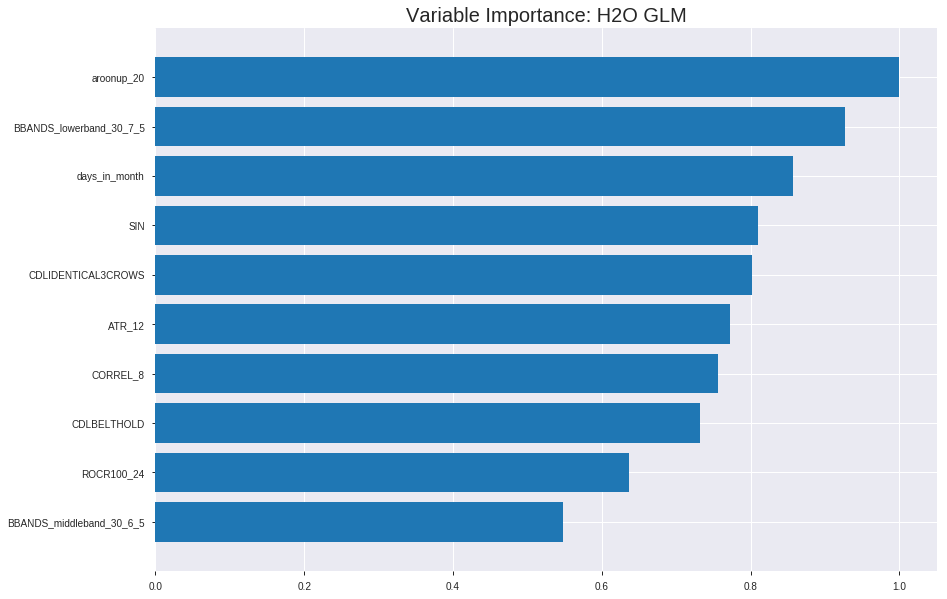

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_123232_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24754442563506354
RMSE: 0.4975383659930795
LogLoss: 0.6881396160810558
Null degrees of freedom: 1740
Residual degrees of freedom: 1690
Null deviance: 2412.986471918777
Residual deviance: 2396.1021431942363
AIC: 2498.1021431942363
AUC: 0.554692223410294
pr_auc: 0.5639039933967774
Gini: 0.10938444682058801
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4287133812317736: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   830   0.9708   (830.0/855.0)
1      11   875   0.0124   (11.0/886.0)
Total  36   1705  0.4831   (841.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.428713     0.675415  372
max f2                       0.314889     0.838221  399
max f0point5                 0.428713     0.567739  372
max accuracy                 0.517638     0.548535  168
max precision                0.937221     1         0
max recall                   0.314889     1         399
max specificity              0.937221     1         0
max absolute_mcc             0.517638     0.10178   168
max min_per_class_accuracy   0.508348     0.536842  194
max mean_per_class_accuracy  0.517638     0.550111  168

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.605674           1.41917   1.41917            0.722222         0.632648  0.722222                    0.632648            0.0146727       0.0146727                  41.9175   41.9175
    2        0.0201034                   0.592284           1.0403    1.23515            0.529412         0.599113  0.628571                    0.61636             0.010158        0.0248307                  4.03001   23.515
    3        0.0304423                   0.585846           1.09167   1.18642            0.555556         0.588018  0.603774                    0.606734            0.0112867       0.0361174                  9.16729   18.6422
    4        0.0402068                   0.582985           1.50266   1.26322            0.764706         0.584304  0.642857                    0.601287            0.0146727       0.0507901                  50.2656   26.3222
    5        0.0505457                   0.578173           1.41917   1.29512            0.722222         0.580441  0.659091                    0.597023            0.0146727       0.0654628                  41.9175   29.5121
    6        0.100517                    0.561114           1.21966   1.25761            0.62069          0.569065  0.64                        0.583124            0.0609481       0.126411                   21.9662   25.7607
    7        0.150488                    0.55096            1.08414   1.20001            0.551724         0.555419  0.610687                    0.573924            0.0541761       0.180587                   8.41442   20.0007
    8        0.20046                     0.543203           1.12932   1.18239            0.574713         0.546864  0.601719                    0.567179            0.0564334       0.23702                    12.9317   18.2385
    9        0.300402                    0.529715           1.05026   1.13843            0.534483         0.536103  0.57935                     0.55684             0.104966        0.341986                   5.02647   13.8429
    10       0.400345                    0.518602           1.06156   1.11924            0.54023          0.524152  0.569584                    0.54868             0.106095        0.448081                   6.15578   11.9239
    11       0.500287                    0.508296           0.89216   1.07388            0.454023         0.51302   0.546498                    0.541556            0.0891648       0.537246                   -10.784   7.38753
    12       0.60023                     0.498479           0.903453  1.0455             0.45977          0.503585  0.532057                    0.535234            0.0902935       0.62754                    -9.65465  4.54988
    13       0.700172                    0.486471           0.971212  1.0349             0.494253         0.492277  0.526661                    0.529102            0.0970655       0.724605                   -2.87875  3.48952
    14       0.800115                    0.475072           0.914747  1.01989            0.465517         0.481071  0.519024                    0.523102            0.0914221       0.816027                   -8.52534  1.98874
    15       0.900057                    0.457593           0.914747  1.00821            0.465517         0.466913  0.513082                    0.516863            0.0914221       0.907449                   -8.52534  0.821256
    16       1                           0.314889           0.92604   1                  0.471264         0.437189  0.508903                    0.5089           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24815336575961
RMSE: 0.49814994304888766
LogLoss: 0.6894150924761766
Null degrees of freedom: 497
Residual degrees of freedom: 447
Null deviance: 689.962659370588
Residual deviance: 686.6574321062719
AIC: 788.6574321062719
AUC: 0.5476532605712255
pr_auc: 0.5449065032100651
Gini: 0.09530652114245108
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42327977534819194: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   228  0.9461   (228.0/241.0)
1      3    254  0.0117   (3.0/257.0)
Total  16   482  0.4639   (231.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.42328      0.687415  383
max f2                       0.408208     0.844839  394
max f0point5                 0.462142     0.58647   308
max accuracy                 0.469705     0.556225  288
max precision                0.618639     1         0
max recall                   0.408208     1         394
max specificity              0.618639     1         0
max absolute_mcc             0.43339      0.123035  372
max min_per_class_accuracy   0.493429     0.536965  205
max mean_per_class_accuracy  0.501273     0.554911  172

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 49.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.582388           1.16265   1.16265            0.6              0.597887  0.6                         0.597887            0.0116732       0.0116732                  16.2646   16.2646
    2        0.0200803                   0.578697           1.16265   1.16265            0.6              0.58049   0.6                         0.589189            0.0116732       0.0233463                  16.2646   16.2646
    3        0.0301205                   0.570399           1.16265   1.16265            0.6              0.576877  0.6                         0.585085            0.0116732       0.0350195                  16.2646   16.2646
    4        0.0401606                   0.562668           1.55019   1.25953            0.8              0.566719  0.65                        0.580493            0.0155642       0.0505837                  55.0195   25.9533
    5        0.0502008                   0.559742           0.775097  1.16265            0.4              0.560969  0.6                         0.576588            0.0077821       0.0583658                  -22.4903  16.2646
    6        0.100402                    0.545146           0.852607  1.00763            0.44             0.55253   0.52                        0.564559            0.0428016       0.101167                   -14.7393  0.762646
    7        0.150602                    0.53547            0.697588  0.90428            0.36             0.540753  0.466667                    0.556624            0.0350195       0.136187                   -30.2412  -9.57198
    8        0.200803                    0.52619            1.39518   1.027              0.72             0.531284  0.53                        0.550289            0.0700389       0.206226                   39.5175   2.70039
    9        0.301205                    0.513654           1.2014    1.08514            0.62             0.519728  0.56                        0.540102            0.120623        0.326848                   20.1401   8.51362
    10       0.399598                    0.503813           1.22592   1.1198             0.632653         0.508897  0.577889                    0.532418            0.120623        0.447471                   22.5919   11.9801
    11       0.5                         0.493156           0.891362  1.07393            0.46             0.498062  0.554217                    0.525519            0.0894942       0.536965                   -10.8638  7.393
    12       0.600402                    0.4857             0.930117  1.04988            0.48             0.489271  0.541806                    0.519458            0.0933852       0.63035                    -6.98833  4.98809
    13       0.698795                    0.474951           0.988644  1.04126            0.510204         0.479842  0.537356                    0.51388             0.0972763       0.727626                   -1.13555  4.12586
    14       0.799197                    0.460603           1.12389   1.05164            0.58             0.468326  0.542714                    0.508157            0.11284         0.840467                   12.3891   5.16395
    15       0.899598                    0.444389           0.697588  1.01212            0.36             0.450798  0.522321                    0.501755            0.0700389       0.910506                   -30.2412  1.21248
    16       1                           0.38825            0.891362  1                  0.46             0.42718   0.516064                    0.494268         


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 12:32:32  0.000 sec   2            2.5       51            1.38411           1.38494
    2019-08-25 12:32:32  0.015 sec   4            1.6       51            1.38339           1.38469
    2019-08-25 12:32:32  0.032 sec   6            0.96      51            1.38253           1.3843
    2019-08-25 12:32:32  0.044 sec   8            0.6       51            1.38155           1.38374
    2019-08-25 12:32:32  0.063 sec   10           0.37      51            1.38051           1.38299
    2019-08-25 12:32:32  0.083 sec   12           0.23      51            1.37949           1.3821
    2019-08-25 12:32:32  0.102 sec   14           0.14      51            1.37858           1.38118
    2019-08-25 12:32:32  0.121 sec   16           0.089     51            1.37782           1.38031
    2019-08-25 12:32:32  0.132 sec   17           0.055     51            1.37722           1.37956
    2019-08-25 12:32:32  0.143 sec   18           0.034     51            1.37672           1.37903
    2019-08-25 12:32:32  0.151 sec   19           0.021     51            1.37628           1.37883
    2019-08-25 12:32:32  0.161 sec   20           0.013     51            1.37584           1.37912
    2019-08-25 12:32:32  0.173 sec   21           0.0082    51            1.37537           1.37999
    2019-08-25 12:32:32  0.182 sec   22           0.0051    51            1.37484           1.38142
    2019-08-25 12:32:32  0.190 sec   23           0.0032    51            1.37426           1.38329
    2019-08-25 12:32:32  0.200 sec   24           0.002     51            1.37356           1.38566

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5341365461847389)

('F1', 0.6861702127659575)

('auc', 0.4921834625322997)

('logloss', 0.6975014890906686)

('mean_per_class_error', 0.47228682170542635)

('rmse', 0.5021445757072438)

('mse', 0.2521491749122079)

glm prediction progress: |████████████████████████████████████████████████| 100%


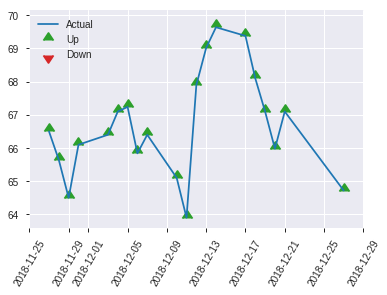


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2521491749122079
RMSE: 0.5021445757072438
LogLoss: 0.6975014890906686
Null degrees of freedom: 248
Residual degrees of freedom: 198
Null deviance: 344.9457142036249
Residual deviance: 347.35574156715296
AIC: 449.35574156715296
AUC: 0.4921834625322997
pr_auc: 0.49334999627566917
Gini: -0.01563307493540056
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4112742704746789: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    118  0.9833   (118.0/120.0)
1      0    129  0        (0.0/129.0)
Total  2    247  0.4739   (118.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411274     0.68617   246
max f2                       0.411274     0.845347  246
max f0point5                 0.411274     0.57744   246
max accuracy                 0.49079      0.534137  168
max precision                0.523468     0.554348  91
max recall                   0.411274     1         246
max specificity              0.608549     0.991667  0
max absolute_mcc             0.590434     0.176338  6
max min_per_class_accuracy   0.509889     0.48062   122
max mean_per_class_accuracy  0.49079      0.527713  168

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 51.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.595949           0         0                  0                0.604414  0                           0.604414            0               0                          -100      -100
    2        0.0200803                   0.591142           0         0                  0                0.592155  0                           0.59951             0               0                          -100      -100
    3        0.0321285                   0.587755           0.643411  0.241279           0.333333         0.590437  0.125                       0.596108            0.00775194      0.00775194                 -35.6589  -75.8721
    4        0.0401606                   0.583023           0.965116  0.386047           0.5              0.584443  0.2                         0.593775            0.00775194      0.0155039                  -3.48837  -61.3953
    5        0.0522088                   0.577443           1.28682   0.593918           0.666667         0.580529  0.307692                    0.590718            0.0155039       0.0310078                  28.6822   -40.6082
    6        0.100402                    0.554122           0.965116  0.772093           0.5              0.564178  0.4                         0.577979            0.0465116       0.0775194                  -3.48837  -22.7907
    7        0.15261                     0.546338           1.18784   0.914321           0.615385         0.550041  0.473684                    0.568421            0.0620155       0.139535                   18.7835   -8.56793
    8        0.200803                    0.540132           0.965116  0.926512           0.5              0.542866  0.48                        0.562288            0.0465116       0.186047                   -3.48837  -7.34884
    9        0.301205                    0.528571           1.23535   1.02946            0.64             0.534232  0.533333                    0.552936            0.124031        0.310078                   23.5349   2.94574
    10       0.401606                    0.520928           0.926512  1.00372            0.48             0.524412  0.52                        0.545805            0.0930233       0.403101                   -7.34884  0.372093
    11       0.502008                    0.508638           0.772093  0.957395           0.4              0.515394  0.496                       0.539723            0.0775194       0.48062                    -22.7907  -4.26047
    12       0.598394                    0.501261           1.28682   1.01046            0.666667         0.504833  0.52349                     0.534103            0.124031        0.604651                   28.6822   1.04573
    13       0.698795                    0.489486           1.08093   1.02058            0.56             0.49497   0.528736                    0.52848             0.108527        0.713178                   8.09302   2.05827
    14       0.799197                    0.479708           0.849302  0.999065           0.44             0.48519   0.517588                    0.523042            0.0852713       0.79845                    -15.0698  -0.0934907
    15       0.899598                    0.466538           0.926512  0.990968           0.48             0.472199  0.513393                    0.517368            0.0930233       0.891473                   -7.34884  -0.903239
    16       1                           0.375644           1.08093   1                  0.56             0.443971  0.518072                    0.509998  

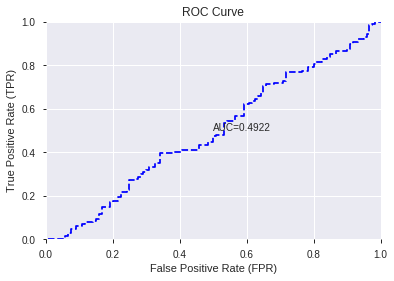

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


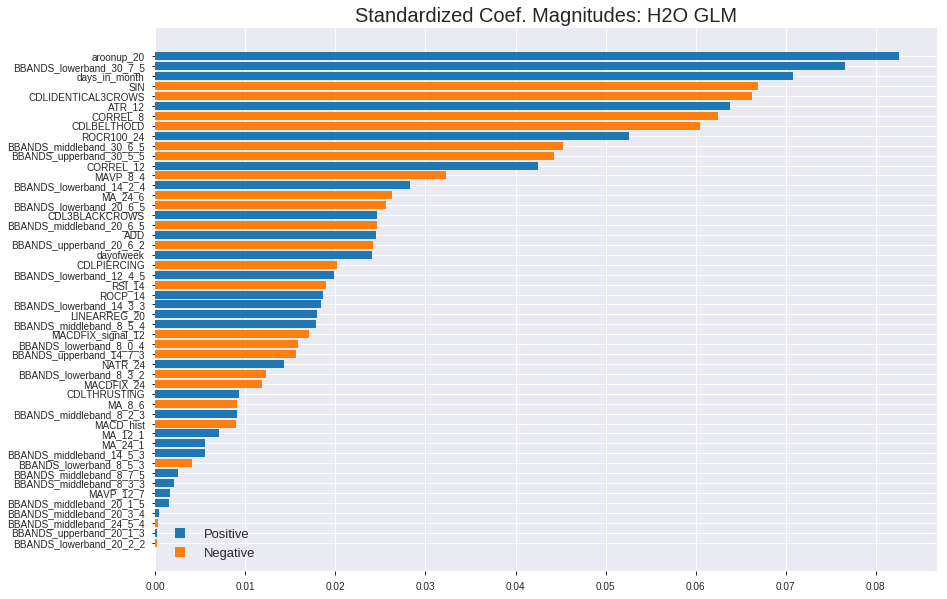

'log_likelihood'
--2019-08-25 12:32:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_123232_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_123232_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['aroonup_20',
 'BBANDS_lowerband_30_7_5',
 'days_in_month',
 'SIN',
 'CDLIDENTICAL3CROWS',
 'ATR_12',
 'CORREL_8',
 'CDLBELTHOLD',
 'ROCR100_24',
 'BBANDS_middleband_30_6_5',
 'BBANDS_upperband_30_5_5',
 'CORREL_12',
 'MAVP_8_4',
 'BBANDS_lowerband_14_2_4',
 'MA_24_6',
 'BBANDS_lowerband_20_6_5',
 'CDL3BLACKCROWS',
 'BBANDS_middleband_20_6_5',
 'ADD',
 'BBANDS_upperband_20_6_2',
 'dayofweek',
 'CDLPIERCING',
 'BBANDS_lowerband_12_4_5',
 'RSI_14',
 'ROCP_14',
 'BBANDS_lowerband_14_3_3',
 'LINEARREG_20',
 'BBANDS_middleband_8_5_4',
 'MACDFIX_signal_12',
 'BBANDS_lowerband_8_0_4',
 'BBANDS_upperband_14_7_3',
 'NATR_24',
 'BBANDS_lowerband_8_3_2',
 'MACDFIX_24',
 'CDLTHRUSTING',
 'MA_8_6',
 'BBANDS_middleband_8_2_3',
 'MACD_hist',
 'MA_12_1',
 'MA_24_1',
 'BBANDS_middleband_14_5_3',
 'BBANDS_lowerband_8_5_3',
 'BBANDS_middleband_8_7_5',
 'BBANDS_middleband_8_3_3',
 'MAVP_12_7',
 'BBANDS_middleband_20_1_5',
 'BBANDS_middleband_20_3_4',
 'BBANDS_middleband_24_5_4',
 'BBANDS_upperband_20_1_3

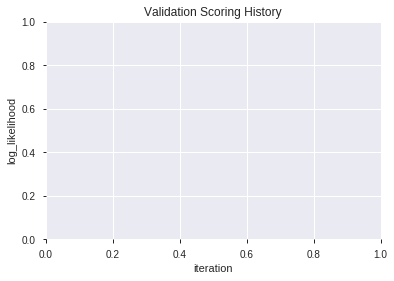

In [0]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_123338_model_1  0.567668  0.700861              0.491667  0.503553  0.253566
1  XGBoost_grid_1_AutoML_20190825_123338_model_5  0.527067  0.747663              0.500000  0.522452  0.272956
2               XGBoost_2_AutoML_20190825_123338  0.514341  0.705520              0.500000  0.505966  0.256002
3  XGBoost_grid_1_AutoML_20190825_123338_model_6  0.514341  0.715213              0.500000  0.510533  0.260644
4               XGBoost_3_AutoML_20190825_123338  0.507235  0.716207              0.483333  0.511103  0.261226
5  XGBoost_grid_1_AutoML_20190825_123338_model_7  0.503165  0.722134              0.495833  0.513546  0.263729
6  XGBoost_grid_1_AutoML_20190825_123338_model_2  0.502132  0.699733              0.491085  0.503241  0.253252
7  XGBoost_grid_1_AutoML_20190825_123338_model_3  0.499031  0.741702              0.500000  0.522167  0.272658
8  XGBoost_grid_1_AutoML_20190825_123338_model_4  0.498966  0.703469              0.486628  0.505032  0.255058
9               XGBoost_1_AutoML_20190825_123338  0.491731  0.716718              0.495833  0.511132  0.261256

variable  relative_importance  scaled_importance  percentage
0                    ROCP_14           272.747528           1.000000    0.090472
1                        SIN           258.648529           0.948308    0.085795
2                 ROCR100_24           249.445297           0.914565    0.082742
3                  MACD_hist           221.609833           0.812509    0.073509
4          MACDFIX_signal_12           219.948334           0.806417    0.072958
5                     RSI_14           207.611282           0.761185    0.068866
6                   CORREL_8           165.347519           0.606229    0.054847
7    BBANDS_lowerband_30_7_5           145.044693           0.531791    0.048112
8                  CORREL_12           143.958069           0.527807    0.047752
9                 MACDFIX_24           137.793381           0.505205    0.045707
10                    ATR_12           108.537323           0.397941    0.036002
11   BBANDS_upperband_30_5_5            93.874405           0.344181    0.031139
12                   NATR_24            63.169411           0.231604    0.020954
13                aroonup_20            60.769970           0.222807    0.020158
14    BBANDS_lowerband_8_0_4            55.476704           0.203399    0.018402
15   BBANDS_lowerband_12_4_5            53.481682           0.196085    0.017740
16   BBANDS_lowerband_20_6_5            49.437206           0.181256    0.016399
17   BBANDS_upperband_14_7_3            42.087879           0.154311    0.013961
18  BBANDS_middleband_20_3_4            38.595730           0.141507    0.012802
19   BBANDS_lowerband_20_2_2            37.867840           0.138838    0.012561
20   BBANDS_lowerband_14_2_4            37.138977           0.136166    0.012319
21   BBANDS_lowerband_14_3_3            36.472782           0.133724    0.012098
22                 dayofweek            32.758301           0.120105    0.010866
23   BBANDS_middleband_8_5_4            24.118919           0.088429    0.008000
24  BBANDS_middleband_24_5_4            23.916618           0.087688    0.007933
25                    MA_8_6            22.157179           0.081237    0.007350
26             days_in_month            21.443756           0.078621    0.007113
27                  MAVP_8_4            20.977148           0.076910    0.006958
28  BBANDS_middleband_20_6_5            19.856243           0.072801    0.006586
29  BBANDS_middleband_14_5_3            18.693668           0.068538    0.006201
30                   MA_12_1            16.841379           0.061747    0.005586
31    BBANDS_lowerband_8_5_3            14.908998           0.054662    0.004945
32    BBANDS_lowerband_8_3_2            13.684303           0.050172    0.004539
33  BBANDS_middleband_20_1_5            12.880215           0.047224    0.004272
34   BBANDS_middleband_8_3_3            12.596866           0.046185    0.004178
35   BBANDS_middleband_8_2_3            12.427943           0.045566    0.004122
36   BBANDS_upperband_20_6_2            12.417113           0.045526    0.004119
37               CDLBELTHOLD             8.663095           0.031762    0.002874
38              LINEARREG_20             7.781378           0.028530    0.002581
39                       ADD             7.648269           0.028042    0.002537
40   BBANDS_middleband_8_7_5             7.166455           0.026275    0.002377
41                   MA_24_1             4.718538           0.017300    0.001565

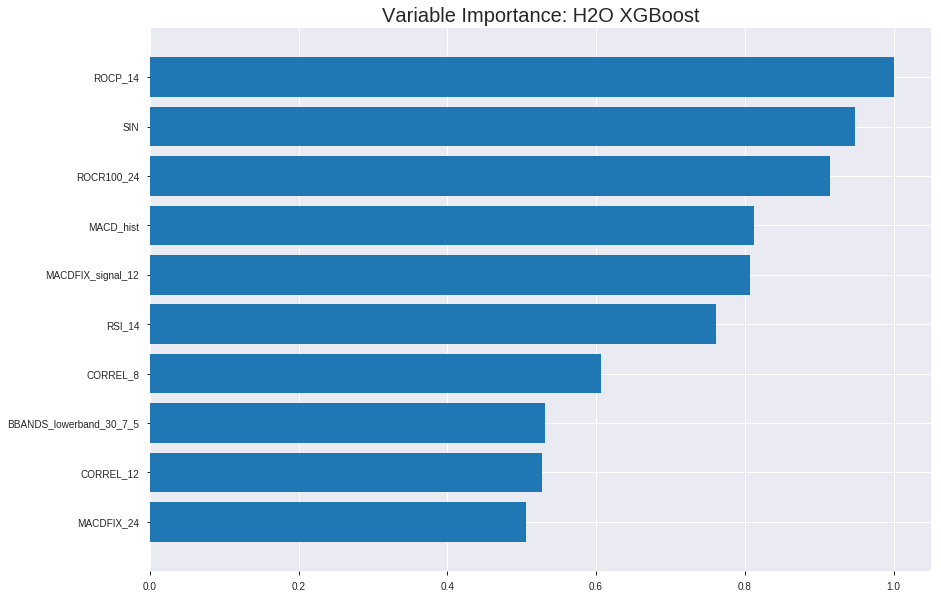

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_123338_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2086450951300134
RMSE: 0.4567768548536729
LogLoss: 0.6087390864899068
Mean Per-Class Error: 0.23208321782635677
AUC: 0.8461282061436511
pr_auc: 0.8448339480431777
Gini: 0.6922564122873023
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49680901169776914: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      593  262  0.3064   (262.0/855.0)
1      150  736  0.1693   (150.0/886.0)
Total  743  998  0.2366   (412.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.496809     0.781316  212
max f2                       0.441807     0.869256  280
max f0point5                 0.515601     0.776506  188
max accuracy                 0.511882     0.767949  193
max precision                0.782923     1         0
max recall                   0.36636      1         355
max specificity              0.782923     1         0
max absolute_mcc             0.511882     0.535795  193
max min_per_class_accuracy   0.511882     0.766082  193
max mean_per_class_accuracy  0.511882     0.767917  193

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.691075           1.96501   1.96501            1                0.713743  1                           0.713743            0.020316        0.020316                   96.5011   96.5011
    2        0.0201034                   0.674561           1.96501   1.96501            1                0.683426  1                           0.699017            0.0191874       0.0395034                  96.5011   96.5011
    3        0.0304423                   0.660899           1.96501   1.96501            1                0.668453  1                           0.688637            0.020316        0.0598194                  96.5011   96.5011
    4        0.0407812                   0.653433           1.74668   1.90966            0.888889         0.656408  0.971831                    0.680466            0.0180587       0.0778781                  74.6677   90.9659
    5        0.0505457                   0.641349           1.84942   1.89802            0.941176         0.645609  0.965909                    0.673732            0.0180587       0.0959368                  84.9422   89.8022
    6        0.100517                    0.608866           1.80691   1.85272            0.91954          0.624534  0.942857                    0.649274            0.0902935       0.18623                    80.6907   85.2725
    7        0.150488                    0.592609           1.82949   1.84501            0.931034         0.600585  0.938931                    0.633106            0.0914221       0.277652                   82.9493   84.5011
    8        0.20046                     0.577049           1.6488    1.7961             0.83908          0.58439   0.91404                     0.620962            0.0823928       0.360045                   64.8803   79.6099
    9        0.300402                    0.550695           1.54716   1.71328            0.787356         0.563504  0.871893                    0.601846            0.154628        0.514673                   54.7164   71.3279
    10       0.400345                    0.530288           1.27613   1.60415            0.649425         0.540673  0.816356                    0.586575            0.12754         0.642212                   27.6128   60.4148
    11       0.500287                    0.512927           1.18578   1.52057            0.603448         0.521623  0.773823                    0.573599            0.11851         0.760722                   18.5783   52.0571
    12       0.60023                     0.491012           0.846988  1.40841            0.431034         0.501156  0.716746                    0.561537            0.0846501       0.845372                   -15.3012  40.8415
    13       0.700172                    0.466698           0.801815  1.32183            0.408046         0.479683  0.672683                    0.549853            0.0801354       0.925508                   -19.8185  32.1829
    14       0.800115                    0.437732           0.406554  1.2075             0.206897         0.453007  0.614501                    0.537756            0.0406321       0.96614                    -59.3446  20.7502
    15       0.900057                    0.400415           0.271036  1.10352            0.137931         0.421356  0.561583                    0.524831            0.027088        0.993228                   -72.8964  10.3516
    16       1                           0.251351           0.067759  1                  0.0344828        0.358698  0.508903                    0.508227         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2645951923002176
RMSE: 0.514388172784151
LogLoss: 0.7232714092867941
Mean Per-Class Error: 0.4825064178116474
AUC: 0.4831603080549591
pr_auc: 0.4988568034222934
Gini: -0.03367938389008185
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2533554136753082: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    240  0.9959   (240.0/241.0)
1      0    257  0        (0.0/257.0)
Total  1    497  0.4819   (240.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.253355     0.681698   398
max f2                       0.253355     0.842623   398
max f0point5                 0.315581     0.576122   378
max accuracy                 0.350033     0.53012    353
max precision                0.670576     1          0
max recall                   0.253355     1          398
max specificity              0.670576     1          0
max absolute_mcc             0.562919     0.0859698  40
max min_per_class_accuracy   0.435427     0.489627   206
max mean_per_class_accuracy  0.350033     0.517494   353

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 44.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.63476            1.55019   1.55019            0.8              0.6517    0.8                         0.6517              0.0155642       0.0155642                  55.0195   55.0195
    2        0.0200803                   0.629104           0.387549  0.968872           0.2              0.632793  0.5                         0.642246            0.00389105      0.0194553                  -61.2451  -3.11284
    3        0.0321285                   0.619147           0.322957  0.726654           0.166667         0.623431  0.375                       0.635191            0.00389105      0.0233463                  -67.7043  -27.3346
    4        0.0401606                   0.605512           1.45331   0.871984           0.75             0.611271  0.45                        0.630407            0.0116732       0.0350195                  45.3307   -12.8016
    5        0.0502008                   0.592943           1.16265   0.930117           0.6              0.601392  0.48                        0.624604            0.0116732       0.0466926                  16.2646   -6.98833
    6        0.100402                    0.558885           0.697588  0.813852           0.36             0.573671  0.42                        0.599138            0.0350195       0.0817121                  -30.2412  -18.6148
    7        0.150602                    0.520828           1.24016   0.955953           0.64             0.538459  0.493333                    0.578912            0.0622568       0.143969                   24.0156   -4.40467
    8        0.200803                    0.504967           0.775097  0.910739           0.4              0.511665  0.47                        0.5621              0.0389105       0.182879                   -22.4903  -8.92607
    9        0.301205                    0.477557           1.08514   0.968872           0.56             0.490054  0.5                         0.538085            0.108949        0.291829                   8.51362   -3.11284
    10       0.399598                    0.457745           0.870007  0.944528           0.44898          0.468006  0.487437                    0.520829            0.0856031       0.377432                   -12.9993  -5.54719
    11       0.5                         0.435332           1.12389   0.980545           0.58             0.446059  0.506024                    0.505815            0.11284         0.490272                   12.3891   -1.94553
    12       0.600402                    0.409064           0.852607  0.95915            0.44             0.421701  0.494983                    0.491749            0.0856031       0.575875                   -14.7393  -4.08495
    13       0.698795                    0.386763           1.14683   0.985576           0.591837         0.3991    0.508621                    0.478704            0.11284         0.688716                   14.6828   -1.44237
    14       0.799197                    0.370704           1.12389   1.00295            0.58             0.378232  0.517588                    0.466082            0.11284         0.801556                   12.3891   0.295251
    15       0.899598                    0.346746           1.08514   1.01212            0.56             0.360279  0.522321                    0.454273            0.108949        0.910506                   8.51362   1.21248
    16       1                           0.217172           0.891362  1                  0.46             0.314085  0.516064                    0.44


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:33:42  0.017 sec   0                  0.5              0.693147            0.5             0                  1                0.491097                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-25 12:33:42  0.087 sec   5                  0.49193          0.677097            0.71518         0.711269           1.85584          0.402642                         0.502491           0.698162              0.488957          0.499927             1.10728            0.473896
    2019-08-25 12:33:42  0.129 sec   10                 0.485493         0.664403            0.752948        0.753252           1.96501          0.342906                         0.502694           0.698586              0.496957          0.505461             0.968872           0.46988
    2019-08-25 12:33:42  0.177 sec   15                 0.48042          0.654466            0.775767        0.773777           1.96501          0.325101                         0.504438           0.702171              0.49983           0.505056             0.553641           0.475904
    2019-08-25 12:33:42  0.224 sec   20                 0.476158         0.646152            0.795339        0.789697           1.85584          0.299828                         0.506087           0.705548              0.491104          0.500999             0.553641           0.457831
    2019-08-25 12:33:42  0.274 sec   25                 0.472634         0.639301            0.803135        0.797824           1.96501          0.290063                         0.506801           0.707019              0.485849          0.50118              1.16265            0.467871
    2019-08-25 12:33:42  0.322 sec   30                 0.469887         0.633953            0.812791        0.80658            1.96501          0.275704                         0.508969           0.71155               0.484726          0.501                1.16265            0.465863
    2019-08-25 12:33:42  0.384 sec   35                 0.466461         0.627348            0.823146        0.816669           1.96501          0.274555                         0.508797           0.711194              0.487253          0.501924             1.55019            0.463855
    2019-08-25 12:33:42  0.442 sec   40                 0.463276         0.621211            0.830324        0.8258             1.96501          0.266513                         0.510714           0.715295              0.488989          0.501776             1.16265            0.463855
    2019-08-25 12:33:42  0.506 sec   45                 0.460054         0.615024            0.837698        0.835463           1.96501          0.261918                         0.512427           0.719007              0.484282          0.496628             1.16265            0.475904
    2019-08-25 12:33:42  0.550 sec   50                 0.456777         0.608739            0.846128        0.844834           1.96501          0.236646                         0.514388           0.723271              0.48316           0.498857             1.55019            0.481928

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
ROCP_14                  272.7475280761719      1.0                   0.09047190431368451
SIN                      258.6485290527344      0.9483075094286465    0.08579518625297698
ROCR100_24               249.44529724121094     0.9145648321752959    0.08274242198522432
MACD_hist                221.60983276367188     0.8125090420683172    0.07350924030800828
MACDFIX_signal_12        219.94833374023438     0.8064173314113705    0.07295811164434633
---                      ---                    ---                   ---
CDLBELTHOLD              8.663095474243164      0.03176232443002661   0.002873597976613572
LINEARREG_20             7.781377792358398      0.028529599689663347  0.002581127213230946
ADD                      7.648268699645996      0.02804156926221534   0.002536974171096703
BBANDS_middleband_8_7_5  7.166455268859863      0.026275051214610618  0.002377153919325412
MA_24_1                  4.718538284301758      0.017300022176494238  0.0015651659509764069


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5742971887550201)

('F1', 0.6861702127659575)

('auc', 0.5676679586563308)

('logloss', 0.7008607275837095)

('mean_per_class_error', 0.42771317829457356)

('rmse', 0.5035529812446675)

('mse', 0.2535656049203925)

xgboost prediction progress: |████████████████████████████████████████████| 100%


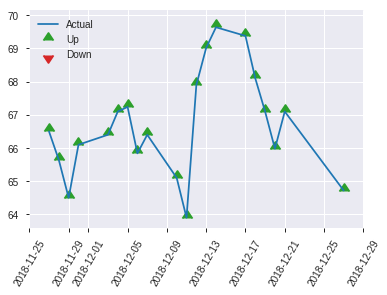


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2535656049203925
RMSE: 0.5035529812446675
LogLoss: 0.7008607275837095
Mean Per-Class Error: 0.42771317829457356
AUC: 0.5676679586563308
pr_auc: 0.5755841467680878
Gini: 0.1353359173126616
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28197720646858215: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    118  0.9833   (118.0/120.0)
1      0    129  0        (0.0/129.0)
Total  2    247  0.4739   (118.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.281977     0.68617   245
max f2                       0.281977     0.845347  245
max f0point5                 0.413269     0.591241  137
max accuracy                 0.413269     0.574297  137
max precision                0.653278     1         0
max recall                   0.281977     1         245
max specificity              0.653278     1         0
max absolute_mcc             0.506255     0.181447  43
max min_per_class_accuracy   0.423428     0.55      123
max mean_per_class_accuracy  0.413269     0.572287  137

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 42.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.601673           0.643411  0.643411           0.333333         0.624876  0.333333                    0.624876            0.00775194      0.00775194                 -35.6589  -35.6589
    2        0.0200803                   0.594487           1.93023   1.15814            1                0.600063  0.6                         0.614951            0.0155039       0.0232558                  93.0233   15.814
    3        0.0321285                   0.583342           1.28682   1.2064             0.666667         0.590129  0.625                       0.605643            0.0155039       0.0387597                  28.6822   20.6395
    4        0.0401606                   0.576089           0         0.965116           0                0.581562  0.5                         0.600827            0               0.0387597                  -100      -3.48837
    5        0.0522088                   0.565651           1.93023   1.18784            1                0.573315  0.615385                    0.594478            0.0232558       0.0620155                  93.0233   18.7835
    6        0.100402                    0.54381            1.44767   1.31256            0.75             0.552578  0.68                        0.574366            0.0697674       0.131783                   44.7674   31.2558
    7        0.15261                     0.520974           1.33631   1.32069            0.692308         0.534729  0.684211                    0.560806            0.0697674       0.20155                    33.6315   32.0685
    8        0.200803                    0.493321           1.28682   1.31256            0.666667         0.506257  0.68                        0.547714            0.0620155       0.263566                   28.6822   31.2558
    9        0.301205                    0.464265           0.694884  1.10667            0.36             0.47766   0.573333                    0.524363            0.0697674       0.333333                   -30.5116  10.6667
    10       0.401606                    0.437336           1.00372   1.08093            0.52             0.452471  0.56                        0.50639             0.100775        0.434109                   0.372093  8.09302
    11       0.502008                    0.423428           1.15814   1.09637            0.6              0.429181  0.568                       0.490948            0.116279        0.550388                   15.814    9.63721
    12       0.598394                    0.404492           1.04554   1.08818            0.541667         0.41474   0.563758                    0.478673            0.100775        0.651163                   4.55426   8.81848
    13       0.698795                    0.382837           0.926512  1.06496            0.48             0.393241  0.551724                    0.466398            0.0930233       0.744186                   -7.34884  6.49559
    14       0.799197                    0.365714           0.772093  1.02816            0.4              0.374665  0.532663                    0.454874            0.0775194       0.821705                   -22.7907  2.81641
    15       0.899598                    0.330201           0.926512  1.01682            0.48             0.351576  0.526786                    0.443345            0.0930233       0.914729                   -7.34884  1.68189
    16       1                           0.272401           0.849302  1                  0.44             0.308972  0.518072                    0.429854        

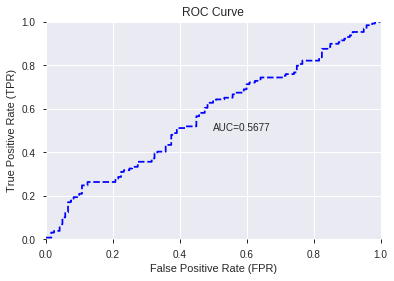

This function is available for GLM models only


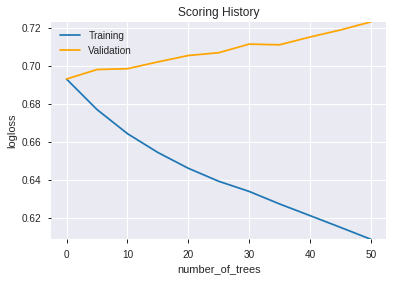

--2019-08-25 12:33:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.0.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.0.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_123338_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_123338_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['ROCP_14',
 'SIN',
 'ROCR100_24',
 'MACD_hist',
 'MACDFIX_signal_12',
 'RSI_14',
 'CORREL_8',
 'BBANDS_lowerband_30_7_5',
 'CORREL_12',
 'MACDFIX_24',
 'ATR_12',
 'BBANDS_upperband_30_5_5',
 'NATR_24',
 'aroonup_20',
 'BBANDS_lowerband_8_0_4',
 'BBANDS_lowerband_12_4_5',
 'BBANDS_lowerband_20_6_5',
 'BBANDS_upperband_14_7_3',
 'BBANDS_middleband_20_3_4',
 'BBANDS_lowerband_20_2_2',
 'BBANDS_lowerband_14_2_4',
 'BBANDS_lowerband_14_3_3',
 'dayofweek',
 'BBANDS_middleband_8_5_4',
 'BBANDS_middleband_24_5_4',
 'MA_8_6',
 'days_in_month',
 'MAVP_8_4',
 'BBANDS_middleband_20_6_5',
 'BBANDS_middleband_14_5_3',
 'MA_12_1',
 'BBANDS_lowerband_8_5_3',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_middleband_20_1_5',
 'BBANDS_middleband_8_3_3',
 'BBANDS_middleband_8_2_3',
 'BBANDS_upperband_20_6_2',
 'CDLBELTHOLD',
 'LINEARREG_20',
 'ADD',
 'BBANDS_middleband_8_7_5',
 'MA_24_1']

In [0]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [0]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [0]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [0]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [0]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [0]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [0]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [0]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [901 938] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_123456_model_4  0.587274  2.411160              0.452132  0.644044  0.414793
1  DeepLearning_grid_1_AutoML_20190825_123456_model_3  0.581912  1.430690              0.478295  0.586790  0.344322
2  DeepLearning_grid_1_AutoML_20190825_123456_model_6  0.564503  0.691918              0.474128  0.499385  0.249386
3  DeepLearning_grid_1_AutoML_20190825_123456_model_1  0.559335  4.090564              0.439922  0.653669  0.427284
4               DeepLearning_1_AutoML_20190825_123456  0.546932  0.692487              0.500000  0.499670  0.249670
5  DeepLearning_grid_1_AutoML_20190825_123456_model_2  0.520736  0.892169              0.500000  0.519213  0.269582
6  DeepLearning_grid_1_AutoML_20190825_123456_model_8  0.500000  0.692558              0.500000  0.499705  0.249705
7  DeepLearning_grid_1_AutoML_20190825_123456_model_5  0.500000  0.692523              0.500000  0.499688  0.249688
8  DeepLearning_grid_1_AutoML_20190825_123456_model_9  0.500000  0.692541              0.500000  0.499697  0.249697
9  DeepLearning_grid_1_AutoML_20190825_123456_model_7  0.491150  0.996824              0.495833  0.509379  0.259467

variable  relative_importance  scaled_importance  percentage
0               CDLHIKKAKEMOD             1.000000           1.000000    0.003438
1                   CDLONNECK             0.987713           0.987713    0.003396
2          CDLIDENTICAL3CROWS             0.980061           0.980061    0.003369
3            CDLABANDONEDBABY             0.969846           0.969846    0.003334
4                   CDL2CROWS             0.968010           0.968010    0.003328
...                       ...                  ...                ...         ...
1040                  MA_12_2             0.235718           0.235718    0.000810
1041  BBANDS_upperband_12_4_2             0.235292           0.235292    0.000809
1042  BBANDS_upperband_14_1_5             0.234592           0.234592    0.000806
1043  BBANDS_upperband_24_6_4             0.233963           0.233963    0.000804
1044  BBANDS_upperband_20_7_2             0.229079           0.229079    0.000788

[1045 rows x 4 columns]

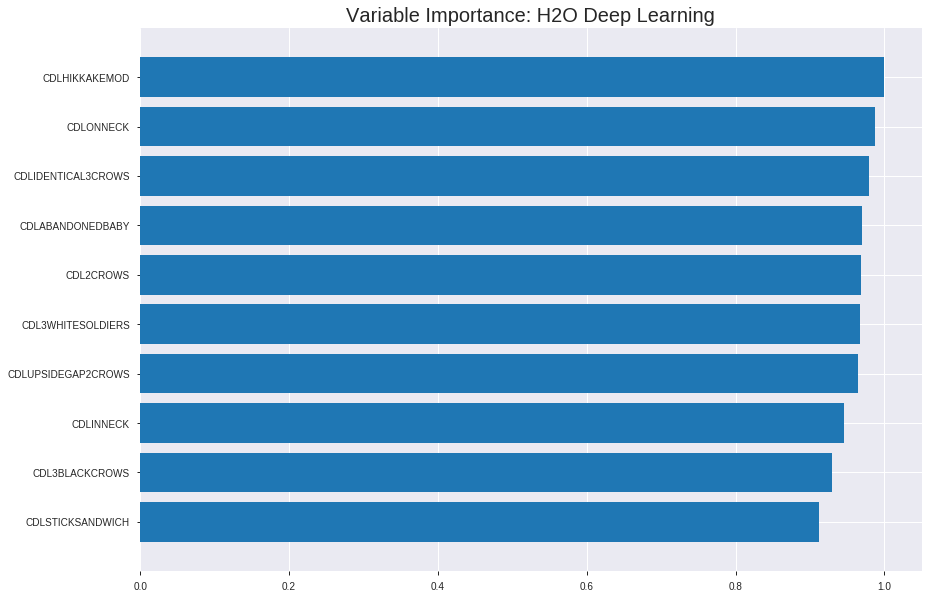

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_123456_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2517154491713371
RMSE: 0.5017125164587157
LogLoss: 0.7778571575121515
Mean Per-Class Error: 0.3485168904201814
AUC: 0.7072023550222434
pr_auc: 0.6919046942128444
Gini: 0.41440471004448676
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2414002903846025: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      200  655   0.7661   (655.0/855.0)
1      40   846   0.0451   (40.0/886.0)
Total  240  1501  0.3992   (695.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.2414       0.70884   319
max f2                       0.126195     0.848637  361
max f0point5                 0.751382     0.659367  124
max accuracy                 0.751382     0.650775  124
max precision                0.988069     0.873786  9
max recall                   0.0071381    1         395
max specificity              0.999649     0.997661  0
max absolute_mcc             0.751382     0.303753  124
max min_per_class_accuracy   0.709686     0.637698  142
max mean_per_class_accuracy  0.751382     0.651483  124

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 64.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.998411           1.63751   1.63751            0.833333         0.999427   0.833333                    0.999427            0.01693         0.01693                    63.7509   63.7509
    2        0.0201034                   0.995678           1.50266   1.57201            0.764706         0.997003   0.8                         0.99825             0.0146727       0.0316027                  50.2656   57.2009
    3        0.0304423                   0.993542           1.52834   1.55718            0.777778         0.994622   0.792453                    0.997018            0.0158014       0.0474041                  52.8342   55.7179
    4        0.0402068                   0.991501           1.96501   1.65622            1                0.992424   0.842857                    0.995902            0.0191874       0.0665914                  96.5011   65.6224
    5        0.0505457                   0.989419           1.85584   1.69706            0.944444         0.990509   0.863636                    0.994799            0.0191874       0.0857788                  85.5844   69.7055
    6        0.100517                    0.979198           1.58104   1.63938            0.804598         0.984392   0.834286                    0.989625            0.0790068       0.164786                   58.1044   63.9381
    7        0.150488                    0.965942           1.55846   1.61251            0.793103         0.972428   0.820611                    0.983915            0.0778781       0.242664                   55.8457   61.2509
    8        0.20046                     0.948173           1.21966   1.51458            0.62069          0.957808   0.770774                    0.977407            0.0609481       0.303612                   21.9662   51.4579
    9        0.300402                    0.887719           1.19708   1.40895            0.609195         0.919361   0.717017                    0.958095            0.119639        0.423251                   19.7076   40.8947
    10       0.400345                    0.808631           1.11802   1.33632            0.568966         0.850165   0.680057                    0.931151            0.111738        0.534989                   11.8024   33.632
    11       0.500287                    0.71011            1.01639   1.27241            0.517241         0.760044   0.647532                    0.896969            0.10158         0.636569                   1.63851   27.2407
    12       0.60023                     0.598842           1.07285   1.23918            0.545977         0.654296   0.630622                    0.856562            0.107223        0.743792                   7.2851    23.9179
    13       0.700172                    0.463156           0.779229  1.17353            0.396552         0.533187   0.597211                    0.810404            0.0778781       0.82167                    -22.0771  17.3526
    14       0.800115                    0.328318           0.846988  1.13274            0.431034         0.396987   0.576454                    0.758764            0.0846501       0.906321                   -15.3012  13.2738
    15       0.900057                    0.191668           0.666297  1.08094            0.33908          0.255603   0.550096                    0.702893            0.0665914       0.972912                   -33.3703  8.09443
    16       1                           0.000231857        0.271036  1                  0.137931         0.0896901  0.508903                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.46292092753380576
RMSE: 0.6803829271328065
LogLoss: 9.462364008604554
Mean Per-Class Error: 0.4812551463583964
AUC: 0.49220175339457833
pr_auc: 0.24586267697718514
Gini: -0.015596493210843332
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.762212385218602: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    239  0.9917   (239.0/241.0)
1      0    257  0        (0.0/257.0)
Total  2    496  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.762212     0.682603   240
max f2                       0.762212     0.843176   240
max f0point5                 0.762212     0.573405   240
max accuracy                 0.999373     0.52008    14
max precision                0.999373     0.533333   14
max recall                   0.762212     1          240
max specificity              1            0.489627   0
max absolute_mcc             0.762212     0.0655741  240
max min_per_class_accuracy   1            0.489627   0
max mean_per_class_accuracy  0.999373     0.518745   14

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 97.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.508032                    1                  1.00334   1.00334            0.517787         1         0.517787                    1                   0.509728        0.509728                   0.333738  0.333738
    2        0.600402                    0.995696           0.884622  0.985073           0.456522         0.998762  0.508361                    0.99981             0.0817121       0.59144                    -11.5378  -1.49265
    3        0.698795                    0.97699            0.909553  0.97444            0.469388         0.985963  0.502874                    0.99786             0.0894942       0.680934                   -9.04471  -2.55602
    4        0.799197                    0.950857           0.968872  0.97374            0.5              0.966502  0.502513                    0.99392             0.0972763       0.77821                    -3.11284  -2.62597
    5        0.899598                    0.909779           1.12389   0.990498           0.58             0.934055  0.511161                    0.987239            0.11284         0.891051                   12.3891   -0.950181
    6        1                           0.690267           1.08514   1                  0.56             0.858073  0.516064                    0.974271            0.108949        1                          8.51362   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 12:42:26  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 12:42:31  7.897 sec         137 obs/sec       0.389431  1             678        0.679513         3.29174             -0.847535      0.516274        0.451724           1.41917          0.491097                         0.718368           12.8987               -1.06634         0.51068           0.523229             0.387549           0.483936
    2019-08-25 12:43:00  36.450 sec        155 obs/sec       2.75359   7             4794       0.615152         2.07491             -0.514128      0.534713        0.432911           0.764171         0.489948                         0.673735           9.58631               -0.817552        0.497231          0.504276             0.775097           0.483936
    2019-08-25 12:43:27  1 min  3.557 sec  162 obs/sec       5.14187   13            8952       0.629512         2.19225             -0.585645      0.545601        0.542492           1.20084          0.491097                         0.718372           12.8708               -1.06637         0.506692          0.529286             1.16265            0.483936
    2019-08-25 12:43:56  1 min 32.487 sec  170 obs/sec       7.99138   20            13913      0.543718         0.890851            -0.18289       0.637974        0.616081           1.96501          0.409535                         0.662702           10.0461               -0.75851         0.514151          0.532871             0.775097           0.483936
    2019-08-25 12:44:23  1 min 59.608 sec  177 obs/sec       10.7766   27            18762      0.557617         1.04366             -0.244141      0.626367        0.599853           1.52834          0.390006                         0.678937           9.49451               -0.845729        0.496674          0.247296             1.00334            0.47992
    2019-08-25 12:44:53  2 min 28.839 sec  183 obs/sec       13.9294   35            24251      0.561177         1.17085             -0.26008       0.633044        0.657234           1.96501          0.491097                         0.653409           9.87645               -0.709539        0.512311          0.53052              0.387549           0.483936
    2019-08-25 12:45:21  2 min 57.801 sec  188 obs/sec       17.1482   43            29855      0.557923         1.22495             -0.245507      0.652486        0.587971           1.20084          0.387708                         0.694639           10.5613               -0.932086        0.485219          0.231088             1.00672            0.46988
    2019-08-25 12:45:50  3 min 25.958 sec  191 obs/sec       20.2573   51            35268      0.461017         0.618263            0.149582       0.744279        0.740083           1.96501          0.364159                         0.675309           9.87804               -0.826056        0.484315          0.492882             0.775097           0.483936
    2019-08-25 12:46:18  

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLHIKKAKEMOD            1.0                    1.0                  0.0034378554657237613
CDLONNECK                0.987713098526001      0.987713098526001    0.0033956148743345643
CDLIDENTICAL3CROWS       0.9800608158111572     0.9800608158111572   0.0033693074323780754
CDLABANDONEDBABY         0.9698461294174194     0.9698461294174194   0.00333419081692871
CDL2CROWS                0.9680101871490479     0.9680101871490479   0.003327879112766635
---                      ---                    ---                  ---
MA_12_2                  0.23571787774562836    0.23571787774562836  0.0008103639943766137
BBANDS_upperband_12_4_2  0.23529216647148132    0.23529216647148132  0.0008089004605459672
BBANDS_upperband_14_1_5  0.23459160327911377    0.23459160327911377  0.0008064920255460015
BBANDS_upperband_24_6_4  0.23396256566047668    0.23396256566047668  0.0008043294851306242
BBANDS_upperband_20_7_2  0.22907871007919312    0.22907871007919312  0.000787539495526703


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5943775100401606)

('F1', 0.6912181303116147)

('auc', 0.5872739018087856)

('logloss', 2.4111598143292596)

('mean_per_class_error', 0.4119186046511627)

('rmse', 0.6440439821874527)

('mse', 0.41479265099187196)

deeplearning prediction progress: |███████████████████████████████████████| 100%


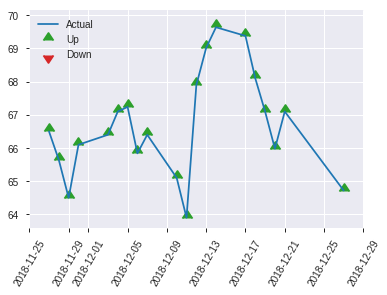


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.41479265099187196
RMSE: 0.6440439821874527
LogLoss: 2.4111598143292596
Mean Per-Class Error: 0.4119186046511627
AUC: 0.5872739018087856
pr_auc: 0.5460316244137846
Gini: 0.17454780361757116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8669509052429466: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      18   102  0.85     (102.0/120.0)
1      7    122  0.0543   (7.0/129.0)
Total  25   224  0.4378   (109.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.866951     0.691218  211
max f2                       0.706471     0.844241  235
max f0point5                 0.922194     0.612245  163
max accuracy                 0.923952     0.594378  159
max precision                0.968499     0.623377  64
max recall                   0.706471     1         235
max specificity              1            0.933333  0
max absolute_mcc             0.922194     0.191027  163
max min_per_class_accuracy   0.945569     0.558333  113
max mean_per_class_accuracy  0.940361     0.588081  128

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 93.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0321285                   1                  0.723837  0.723837           0.375            1         0.375                       1                   0.0232558       0.0232558                  -27.6163  -27.6163
    2        0.0321285                   1                  0         0.723837           0                0         0.375                       1                   0               0.0232558                  -100      -27.6163
    3        0.0401606                   1                  0         0.57907            0                1         0.3                         1                   0               0.0232558                  -100      -42.093
    4        0.0522088                   1                  0.643411  0.593918           0.333333         1         0.307692                    1                   0.00775194      0.0310078                  -35.6589  -40.6082
    5        0.100402                    0.996758           1.44767   1.00372            0.75             0.999209  0.52                        0.99962             0.0697674       0.100775                   44.7674   0.372093
    6        0.15261                     0.989994           1.18784   1.06671            0.615385         0.993123  0.552632                    0.997398            0.0620155       0.162791                   18.7835   6.67075
    7        0.200803                    0.982175           1.28682   1.11953            0.666667         0.985402  0.58                        0.994519            0.0620155       0.224806                   28.6822   11.9535
    8        0.301205                    0.968984           1.31256   1.18388            0.68             0.975072  0.613333                    0.988036            0.131783        0.356589                   31.2558   18.3876
    9        0.401606                    0.956448           0.926512  1.11953            0.48             0.963302  0.58                        0.981853            0.0930233       0.449612                   -7.34884  11.9535
    10       0.502008                    0.94568            1.08093   1.11181            0.56             0.950889  0.576                       0.97566             0.108527        0.55814                    8.09302   11.1814
    11       0.598394                    0.935478           1.12597   1.11409            0.583333         0.941319  0.577181                    0.970129            0.108527        0.666667                   12.5969   11.4094
    12       0.698795                    0.922459           1.15814   1.12042            0.6              0.929974  0.58046                     0.964359            0.116279        0.782946                   15.814    12.0422
    13       0.799197                    0.897919           0.694884  1.06696            0.36             0.910862  0.552764                    0.957639            0.0697674       0.852713                   -30.5116  6.69627
    14       0.899598                    0.866576           0.926512  1.05129            0.48             0.881743  0.544643                    0.949168            0.0930233       0.945736                   -7.34884  5.12874
    15       1                           0.18871            0.540465  1                  0.28             0.776813  0.518072                    0.931863            0.0542636       1                          -45.9535  0

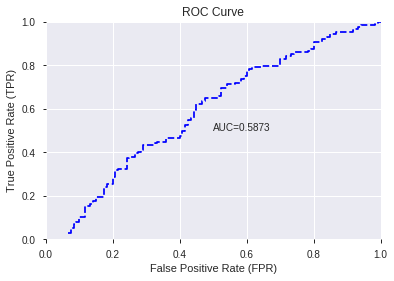

This function is available for GLM models only


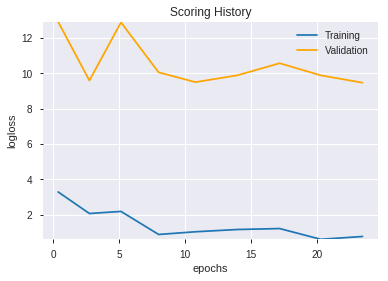

--2019-08-25 13:09:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_123456_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_123456_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLHIKKAKEMOD',
 'CDLONNECK',
 'CDLIDENTICAL3CROWS',
 'CDLABANDONEDBABY',
 'CDL2CROWS',
 'CDL3WHITESOLDIERS',
 'CDLUPSIDEGAP2CROWS',
 'CDLINNECK',
 'CDL3BLACKCROWS',
 'CDLSTICKSANDWICH',
 'CDLADVANCEBLOCK',
 'CDLMORNINGDOJISTAR',
 'CDLPIERCING',
 'CDLGAPSIDESIDEWHITE',
 'CDLEVENINGDOJISTAR',
 'CDLUNIQUE3RIVER',
 'CDL3LINESTRIKE',
 'CDLLADDERBOTTOM',
 'CDLMORNINGSTAR',
 'SINH',
 'COSH',
 'EXP',
 'CDLSEPARATINGLINES',
 'CDLTHRUSTING',
 'is_quarter_end',
 'is_quarter_start',
 'CDLTASUKIGAP',
 'CDLXSIDEGAP3METHODS',
 'CDLEVENINGSTAR',
 'TAN',
 'CDLINVERTEDHAMMER',
 'CDLDARKCLOUDCOVER',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'TANH',
 'CDLGRAVESTONEDOJI',
 'CDLHOMINGPIGEON',
 'is_month_start',
 'is_month_end',
 'CDLHAMMER',
 'CDL3INSIDE',
 'CDLTAKURI',
 'weekday_name',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'BOP',
 'Volume',
 'CDLRICKSHAWMAN',
 'weekday',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'COS',
 'CDLHARAMICROSS',
 'day',
 'aroonup_8',
 'CDLDOJISTAR',
 'CORREL_8',
 'ATAN',
 'days_in_mon

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_130958_model_1  0.564147  0.717561              0.478295  0.499673  0.249673

variable  relative_importance  scaled_importance  percentage
0                          BOP             0.008632           1.000000    0.016149
1                 CDLTASUKIGAP             0.007989           0.925456    0.014945
2           CDLCLOSINGMARUBOZU             0.007781           0.901355    0.014556
3                 CDLSHORTLINE             0.007147           0.827956    0.013371
4                 weekday_name             0.006842           0.792600    0.012800
...                        ...                  ...                ...         ...
1040  BBANDS_middleband_14_1_3             0.000000           0.000000    0.000000
1041  BBANDS_middleband_14_1_4             0.000000           0.000000    0.000000
1042  BBANDS_middleband_14_1_5             0.000000           0.000000    0.000000
1043   BBANDS_lowerband_14_2_3             0.000000           0.000000    0.000000
1044                    WMA_20             0.000000           0.000000    0.000000

[1045 rows x 4 columns]

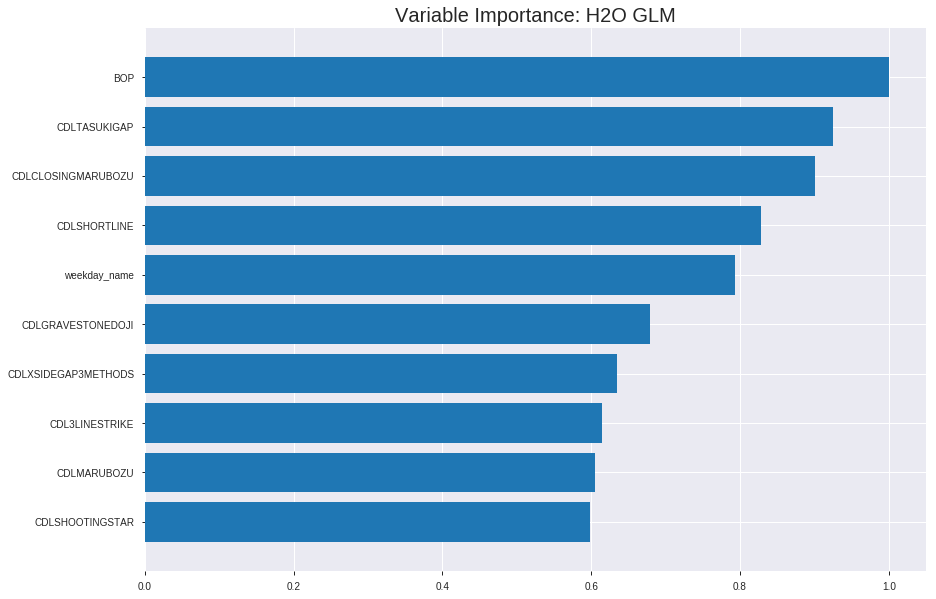

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_130958_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24684789542528035
RMSE: 0.4968378965269058
LogLoss: 0.6868307383552573
Null degrees of freedom: 1740
Residual degrees of freedom: 701
Null deviance: 2412.986471918777
Residual deviance: 2391.544630953006
AIC: 4471.544630953006
AUC: 0.5902056684223727
pr_auc: 0.5857638442019766
Gini: 0.1804113368447453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4752258400572335: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      67   788   0.9216   (788.0/855.0)
1      30   856   0.0339   (30.0/886.0)
Total  97   1644  0.4698   (818.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475226     0.67668   353
max f2                       0.454714     0.839015  394
max f0point5                 0.499989     0.581839  246
max accuracy                 0.508942     0.574383  203
max precision                0.578625     1         0
max recall                   0.454714     1         394
max specificity              0.578625     1         0
max absolute_mcc             0.508942     0.149225  203
max min_per_class_accuracy   0.508305     0.567251  206
max mean_per_class_accuracy  0.508942     0.574606  203

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.557732           1.52834   1.52834            0.777778         0.563419  0.777778                    0.563419            0.0158014       0.0158014                  52.8342   52.8342
    2        0.0201034                   0.552552           1.27148   1.40358            0.647059         0.555161  0.714286                    0.559408            0.0124153       0.0282167                  27.1478   40.3579
    3        0.0304423                   0.548808           0.764171  1.18642            0.388889         0.550272  0.603774                    0.556305            0.00790068      0.0361174                  -23.5829  18.6422
    4        0.0402068                   0.546941           1.50266   1.26322            0.764706         0.547777  0.642857                    0.554234            0.0146727       0.0507901                  50.2656   26.3222
    5        0.0505457                   0.545143           1.09167   1.22813            0.555556         0.546022  0.625                       0.552554            0.0112867       0.0620767                  9.16729   22.8132
    6        0.100517                    0.538301           1.31001   1.26884            0.666667         0.541238  0.645714                    0.546929            0.0654628       0.12754                    31.0008   26.8836
    7        0.150488                    0.533591           1.24225   1.26001            0.632184         0.535922  0.641221                    0.543274            0.0620767       0.189616                   24.2249   26.0007
    8        0.20046                     0.52966            1.17449   1.23869            0.597701         0.531711  0.630372                    0.540391            0.0586907       0.248307                   17.449    23.8689
    9        0.300402                    0.522005           1.08414   1.18727            0.551724         0.525824  0.604207                    0.535545            0.108352        0.356659                   8.41442   18.7273
    10       0.400345                    0.514905           1.05026   1.15307            0.534483         0.518364  0.586801                    0.531256            0.104966        0.461625                   5.02647   15.307
    11       0.500287                    0.508272           1.06156   1.13479            0.54023          0.511517  0.577497                    0.527312            0.106095        0.56772                    6.15578   13.4788
    12       0.60023                     0.501519           0.858281  1.08875            0.436782         0.504764  0.554067                    0.523558            0.0857788       0.653499                   -14.1719  8.87479
    13       0.700172                    0.495512           0.971212  1.07197            0.494253         0.498363  0.545529                    0.519962            0.0970655       0.750564                   -2.87875  7.19709
    14       0.800115                    0.489164           0.903453  1.05092            0.45977          0.492149  0.534817                    0.516488            0.0902935       0.840858                   -9.65465  5.09213
    15       0.900057                    0.480775           0.880867  1.03204            0.448276         0.485231  0.525207                    0.513017            0.0880361       0.928894                   -11.9133  3.20385
    16       1                           0.422935           0.71147   1                  0.362069         0.471855  0.508903                    0.508903          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3843651119332489
RMSE: 0.6199718638238746
LogLoss: 8.705422142531352
Null degrees of freedom: 497
Residual degrees of freedom: -542
Null deviance: 689.962659370588
Residual deviance: 139813.9933976815
AIC: 141893.9933976815
AUC: 0.5060464665708704
pr_auc: 0.5207445673059916
Gini: 0.012092933141740758
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.9888903633865874e-54: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    241  1        (241.0/241.0)
1      0    257  0        (0.0/257.0)
Total  0    498  0.4839   (241.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       4.98889e-54  0.680795   290
max f2                       4.98889e-54  0.842071   290
max f0point5                 4.98889e-54  0.571365   290
max accuracy                 0.469641     0.518072   210
max precision                0.521437     0.621622   36
max recall                   4.98889e-54  1          290
max specificity              0.548956     0.995851   0
max absolute_mcc             0.545455     0.0803926  2
max min_per_class_accuracy   0.145023     0.498054   247
max mean_per_class_accuracy  0.502046     0.521167   107

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 24.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.540955           0.387549  0.387549           0.2              0.545343      0.2                         0.545343            0.00389105      0.00389105                 -61.2451  -61.2451
    2        0.0200803                   0.533505           1.16265   0.775097           0.6              0.536283      0.4                         0.540813            0.0116732       0.0155642                  16.2646   -22.4903
    3        0.0301205                   0.529095           1.16265   0.90428            0.6              0.531893      0.466667                    0.53784             0.0116732       0.0272374                  16.2646   -9.57198
    4        0.0401606                   0.527529           0.775097  0.871984           0.4              0.527959      0.45                        0.53537             0.0077821       0.0350195                  -22.4903  -12.8016
    5        0.0502008                   0.525348           1.16265   0.930117           0.6              0.526994      0.48                        0.533695            0.0116732       0.0466926                  16.2646   -6.98833
    6        0.100402                    0.516267           1.24016   1.08514            0.64             0.521296      0.56                        0.527496            0.0622568       0.108949                   24.0156   8.51362
    7        0.150602                    0.508595           0.930117  1.03346            0.48             0.51149       0.533333                    0.522161            0.0466926       0.155642                   -6.98833  3.3463
    8        0.200803                    0.502985           1.16265   1.06576            0.6              0.50598       0.55                        0.518115            0.0583658       0.214008                   16.2646   6.57588
    9        0.301205                    0.491507           1.00763   1.04638            0.52             0.497883      0.54                        0.511371            0.101167        0.315175                   0.762646  4.63813
    10       0.399598                    0.477604           0.909553  1.01269            0.469388         0.484841      0.522613                    0.504839            0.0894942       0.404669                   -9.04471  1.26899
    11       0.5                         0.117261           0.930117  0.996109           0.48             0.428223      0.514056                    0.489454            0.0933852       0.498054                   -6.98833  -0.389105
    12       0.600402                    8.26367e-124       1.12389   1.01748            0.58             0.0051548     0.525084                    0.408467            0.11284         0.610895                   12.3891   1.74772
    13       1                           0                  0.97374   1                  0.502513         3.18871e-127  0.516064                    0.245245            0.389105        1                          -2.62597  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 13:10:02  0.000 sec   2            3.7       1040          1.37366           280.751
    2019-08-25 13:10:04  2.027 sec   4            2.7       1040          1.37055           288.324
    2019-08-25 13:10:06  4.159 sec   6            2         1045          1.36687           295.208
    2019-08-25 13:10:08  6.194 sec   8            1.4       1045          1.36251           300.479
    2019-08-25 13:10:10  8.188 sec   10           1         1046          1.35749           304.389

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.570281124497992)

('F1', 0.6866485013623979)

('auc', 0.5641472868217055)

('logloss', 0.7175612312731569)

('mean_per_class_error', 0.4344961240310077)

('rmse', 0.49967311909187423)

('mse', 0.24967322594300234)

glm prediction progress: |████████████████████████████████████████████████| 100%


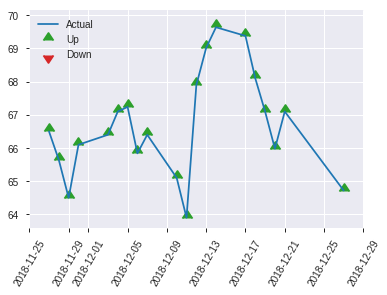


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24967322594300234
RMSE: 0.49967311909187423
LogLoss: 0.7175612312731569
Null degrees of freedom: 248
Residual degrees of freedom: -791
Null deviance: 344.9457142036249
Residual deviance: 357.34549317403184
AIC: 2437.3454931740316
AUC: 0.5641472868217055
pr_auc: 0.5763423362588059
Gini: 0.1282945736434109
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3877160083556633: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    112  0.9333   (112.0/120.0)
1      3    126  0.0233   (3.0/129.0)
Total  11   238  0.4618   (115.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.387716     0.686649  237
max f2                       0.00027695   0.845347  246
max f0point5                 0.483587     0.597884  203
max accuracy                 0.483587     0.570281  203
max precision                0.53613      0.8       14
max recall                   0.00027695   1         246
max specificity              0.555316     0.991667  0
max absolute_mcc             0.483587     0.152758  203
max min_per_class_accuracy   0.501379     0.51938   123
max mean_per_class_accuracy  0.512262     0.565504  74

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 48.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.547734           0.643411  0.643411           0.333333         0.552546  0.333333                    0.552546            0.00775194      0.00775194                 -35.6589  -35.6589
    2        0.0200803                   0.54411            1.93023   1.15814            1                0.544517  0.6                         0.549334            0.0155039       0.0232558                  93.0233   15.814
    3        0.0321285                   0.540538           1.93023   1.44767            1                0.54263   0.75                        0.54682             0.0232558       0.0465116                  93.0233   44.7674
    4        0.0401606                   0.538164           0.965116  1.35116            0.5              0.538917  0.7                         0.54524             0.00775194      0.0542636                  -3.48837  35.1163
    5        0.0522088                   0.536896           1.93023   1.48479            1                0.537462  0.769231                    0.543445            0.0232558       0.0775194                  93.0233   48.4794
    6        0.100402                    0.527823           0.965116  1.23535            0.5              0.532678  0.64                        0.538277            0.0465116       0.124031                   -3.48837  23.5349
    7        0.15261                     0.52387            1.03936   1.1683             0.538462         0.525779  0.605263                    0.534001            0.0542636       0.178295                   3.9356    16.8299
    8        0.200803                    0.518995           1.12597   1.15814            0.583333         0.521226  0.6                         0.530935            0.0542636       0.232558                   12.5969   15.814
    9        0.301205                    0.512216           1.31256   1.20961            0.68             0.515277  0.626667                    0.525716            0.131783        0.364341                   31.2558   20.9612
    10       0.401606                    0.505839           0.849302  1.11953            0.44             0.508954  0.58                        0.521526            0.0852713       0.449612                   -15.0698  11.9535
    11       0.502008                    0.501347           0.694884  1.0346             0.36             0.503104  0.536                       0.517841            0.0697674       0.51938                    -30.5116  3.46047
    12       0.598394                    0.497274           0.88469   1.01046            0.458333         0.499311  0.52349                     0.514856            0.0852713       0.604651                   -11.531   1.04573
    13       0.698795                    0.492194           1.23535   1.04277            0.64             0.49469   0.54023                     0.511959            0.124031        0.728682                   23.5349   4.27693
    14       0.799197                    0.485426           1.23535   1.06696            0.64             0.488852  0.552764                    0.509056            0.124031        0.852713                   23.5349   6.69627
    15       0.899598                    0.469704           0.617674  1.01682            0.32             0.480022  0.526786                    0.505816            0.0620155       0.914729                   -38.2326  1.68189
    16       1                           2.22053e-07        0.849302  1                  0.44             0.322342  0.518072                    0.487394          

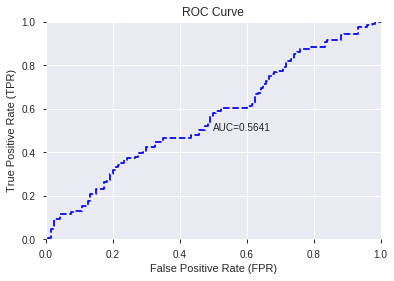

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


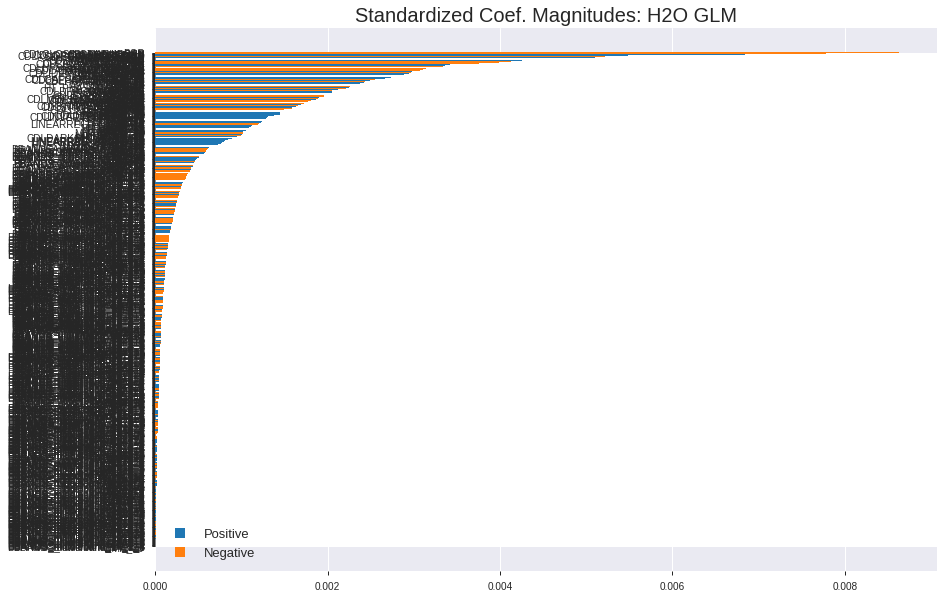

'log_likelihood'
--2019-08-25 13:10:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.72.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.72.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_130958_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_130958_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLTASUKIGAP',
 'CDLCLOSINGMARUBOZU',
 'CDLSHORTLINE',
 'weekday_name',
 'CDLGRAVESTONEDOJI',
 'CDLXSIDEGAP3METHODS',
 'CDL3LINESTRIKE',
 'CDLMARUBOZU',
 'CDLSHOOTINGSTAR',
 'CDLINNECK',
 'CDLHIKKAKE',
 'TANH',
 'days_in_month',
 'CDL2CROWS',
 'CDLMATCHINGLOW',
 'CDLHIGHWAVE',
 'aroonup_30',
 'STOCHF_fastk',
 'AD',
 'CDLADVANCEBLOCK',
 'SIN',
 'CDLCOUNTERATTACK',
 'STOCHRSI_fastd',
 'MFI_12',
 'MFI_14',
 'ULTOSC',
 'aroonup_14',
 'MFI_30',
 'aroondown_12',
 'AROONOSC_12',
 'CDLUPSIDEGAP2CROWS',
 'CORREL_24',
 'HT_TRENDMODE',
 'STOCHRSI_fastk',
 'CDLABANDONEDBABY',
 'WILLR_8',
 'day',
 'CDLHIKKAKEMOD',
 'DX_8',
 'CCI_30',
 'ADXR_14',
 'CDLIDENTICAL3CROWS',
 'CDLLONGLINE',
 'PPO',
 'STOCH_slowk',
 'MFI_20',
 'STOCHF_fastd',
 'CDLONNECK',
 'CDLBELTHOLD',
 'ADXR_12',
 'aroonup_24',
 'DX_12',
 'TAN',
 'CDLGAPSIDESIDEWHITE',
 'TRIX_8',
 'AROONOSC_30',
 'CDLSEPARATINGLINES',
 'CORREL_30',
 'aroonup_12',
 'CDLHOMINGPIGEON',
 'CORREL_8',
 'aroonup_20',
 'TRIX_12',
 'DX_14',
 'MFI_24',

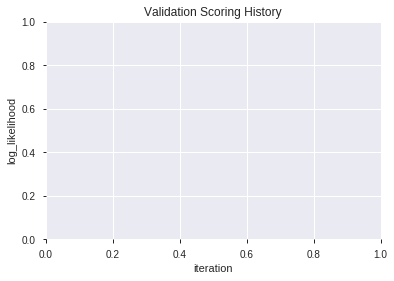

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190825_131131_model_1  0.602907  0.680020              0.487500  0.493465  0.243508
1  XGBoost_grid_1_AutoML_20190825_131131_model_6  0.573966  0.694037              0.500000  0.500180  0.250180
2               XGBoost_3_AutoML_20190825_131131  0.559044  0.687350              0.448547  0.497165  0.247173
3  XGBoost_grid_1_AutoML_20190825_131131_model_3  0.557817  0.689069              0.483333  0.497969  0.247973
4  XGBoost_grid_1_AutoML_20190825_131131_model_5  0.555556  0.705563              0.469671  0.505824  0.255858
5               XGBoost_2_AutoML_20190825_131131  0.553359  0.689046              0.461628  0.498018  0.248022
6  XGBoost_grid_1_AutoML_20190825_131131_model_2  0.551744  0.688483              0.448837  0.497728  0.247733
7  XGBoost_grid_1_AutoML_20190825_131131_model_4  0.539599  0.691321              0.469961  0.499063  0.249064
8               XGBoost_1_AutoML_20190825_131131  0.511047  0.705117              0.491376  0.505755  0.255788
9  XGBoost_grid_1_AutoML_20190825_131131_model_7  0.509044  0.714086              0.457752  0.509760  0.259855

variable  relative_importance  scaled_importance  percentage
0                        BOP           178.859344           1.000000    0.040313
1                STOCH_slowd           108.085785           0.604306    0.024362
2                     MFI_12            76.945961           0.430204    0.017343
3          HT_PHASOR_inphase            76.796906           0.429370    0.017309
4                      ROC_8            67.028358           0.374755    0.015108
..                       ...                  ...                ...         ...
196  BBANDS_lowerband_20_0_4             3.738269           0.020901    0.000843
197                   MOM_20             3.641142           0.020358    0.000821
198                    DX_14             3.636367           0.020331    0.000820
199                     DX_8             3.450155           0.019290    0.000778
200                     High             3.370272           0.018843    0.000760

[201 rows x 4 columns]

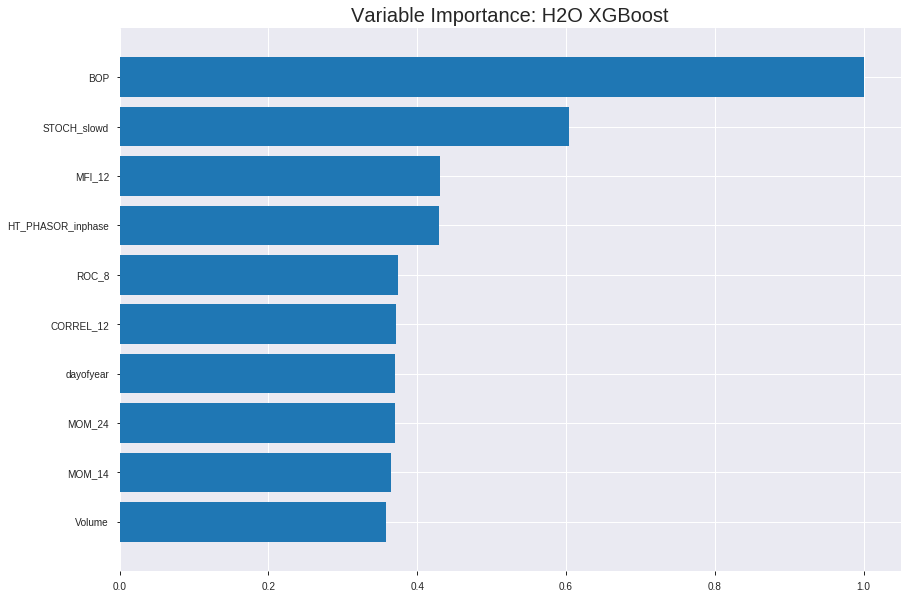

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190825_131131_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1893162821714324
RMSE: 0.4351049093855784
LogLoss: 0.5689314342394436
Mean Per-Class Error: 0.14381674653149057
AUC: 0.9314053568835557
pr_auc: 0.9352961157716564
Gini: 0.8628107137671115
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4997816350724962: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      721  134  0.1567   (134.0/855.0)
1      119  767  0.1343   (119.0/886.0)
Total  840  901  0.1453   (253.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499782     0.858422  211
max f2                       0.457961     0.902925  256
max f0point5                 0.516104     0.872467  191
max accuracy                 0.508043     0.85583   202
max precision                0.793735     1         0
max recall                   0.389748     1         330
max specificity              0.793735     1         0
max absolute_mcc             0.508043     0.712513  202
max min_per_class_accuracy   0.502077     0.854971  208
max mean_per_class_accuracy  0.508043     0.856183  202

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.730186           1.96501   1.96501            1                0.757108  1                           0.757108            0.020316        0.020316                   96.5011   96.5011
    2        0.0201034                   0.705409           1.96501   1.96501            1                0.718705  1                           0.738455            0.0191874       0.0395034                  96.5011   96.5011
    3        0.0304423                   0.686393           1.96501   1.96501            1                0.692574  1                           0.722873            0.020316        0.0598194                  96.5011   96.5011
    4        0.0402068                   0.676133           1.96501   1.96501            1                0.681623  1                           0.712855            0.0191874       0.0790068                  96.5011   96.5011
    5        0.0505457                   0.66712            1.96501   1.96501            1                0.67126   1                           0.704347            0.020316        0.0993228                  96.5011   96.5011
    6        0.100517                    0.637328           1.96501   1.96501            1                0.652402  1                           0.678523            0.0981941       0.197517                   96.5011   96.5011
    7        0.150488                    0.612471           1.89725   1.94251            0.965517         0.624427  0.98855                     0.66056             0.0948081       0.292325                   89.7252   94.2511
    8        0.20046                     0.598431           1.94242   1.94249            0.988506         0.605199  0.988539                    0.646759            0.0970655       0.389391                   94.2425   94.249
    9        0.300402                    0.563228           1.80691   1.89738            0.91954          0.58101   0.965583                    0.624885            0.180587        0.569977                   80.6907   89.7382
    10       0.400345                    0.531756           1.4907    1.79586            0.758621         0.547398  0.913917                    0.605541            0.148984        0.718962                   49.0698   79.5857
    11       0.500287                    0.502875           1.28742   1.69429            0.655172         0.51705   0.862227                    0.587863            0.128668        0.84763                    28.7421   69.4286
    12       0.60023                     0.475611           0.722763  1.53252            0.367816         0.489985  0.779904                    0.571566            0.0722348       0.919865                   -27.7237  53.2521
    13       0.700172                    0.449647           0.485606  1.38308            0.247126         0.463513  0.703856                    0.556142            0.0485327       0.968397                   -51.4394  38.3084
    14       0.800115                    0.420722           0.24845   1.24136            0.126437         0.435584  0.63173                     0.541083            0.0248307       0.993228                   -75.155   24.1357
    15       0.900057                    0.385019           0.067759  1.11104            0.0344828        0.403704  0.565412                    0.525829            0.00677201      1                          -93.2241  11.104
    16       1                           0.253071           0         1                  0                0.348905  0.508903                    0.508146           



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25798774774003347
RMSE: 0.5079249430181919
LogLoss: 0.7096946644414409
Mean Per-Class Error: 0.4478986712304438
AUC: 0.5427611928249673
pr_auc: 0.540669124562576
Gini: 0.08552238564993453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30403846502304077: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      21   220  0.9129   (220.0/241.0)
1      6    251  0.0233   (6.0/257.0)
Total  27   471  0.4538   (226.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.304038     0.68956   373
max f2                       0.219294     0.842071  399
max f0point5                 0.340471     0.590189  333
max accuracy                 0.370978     0.560241  295
max precision                0.732685     1         0
max recall                   0.219294     1         399
max specificity              0.732685     1         0
max absolute_mcc             0.304038     0.14078   373
max min_per_class_accuracy   0.421461     0.513619  199
max mean_per_class_accuracy  0.370978     0.552101  295

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 42.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.62706            0.775097  0.775097           0.4              0.664247  0.4                         0.664247            0.0077821       0.0077821                  -22.4903  -22.4903
    2        0.0200803                   0.606269           1.16265   0.968872           0.6              0.616719  0.5                         0.640483            0.0116732       0.0194553                  16.2646   -3.11284
    3        0.0301205                   0.597622           1.55019   1.16265            0.8              0.602597  0.6                         0.627855            0.0155642       0.0350195                  55.0195   16.2646
    4        0.0401606                   0.585934           1.93774   1.35642            1                0.591112  0.7                         0.618669            0.0194553       0.0544747                  93.7743   35.642
    5        0.0502008                   0.571952           0.775097  1.24016            0.4              0.576623  0.64                        0.61026             0.0077821       0.0622568                  -22.4903  24.0156
    6        0.100402                    0.548594           0.852607  1.04638            0.44             0.560975  0.54                        0.585617            0.0428016       0.105058                   -14.7393  4.63813
    7        0.150602                    0.522465           0.930117  1.00763            0.48             0.536019  0.52                        0.569084            0.0466926       0.151751                   -6.98833  0.762646
    8        0.200803                    0.500001           1.24016   1.06576            0.64             0.509686  0.55                        0.554235            0.0622568       0.214008                   24.0156   6.57588
    9        0.301205                    0.46893            0.968872  1.03346            0.5              0.484045  0.533333                    0.530838            0.0972763       0.311284                   -3.11284  3.3463
    10       0.399598                    0.445311           1.14683   1.06138            0.591837         0.4552    0.547739                    0.512214            0.11284         0.424125                   14.6828   6.13769
    11       0.5                         0.419768           0.891362  1.02724            0.46             0.434319  0.53012                     0.496572            0.0894942       0.513619                   -10.8638  2.72374
    12       0.600402                    0.397112           1.08514   1.03692            0.56             0.408917  0.535117                    0.481914            0.108949        0.622568                   8.51362   3.69194
    13       0.698795                    0.37866            1.10728   1.04683            0.571429         0.387624  0.54023                     0.468638            0.108949        0.731518                   10.7282   4.68268
    14       0.799197                    0.358694           1.12389   1.05651            0.58             0.370866  0.545226                    0.456355            0.11284         0.844358                   12.3891   5.65082
    15       0.899598                    0.323403           0.813852  1.02943            0.42             0.341983  0.53125                     0.44359             0.0817121       0.92607                    -18.6148  2.94261
    16       1                           0.219294           0.736342  1                  0.38             0.295165  0.516064                    0.428688        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:11:45  0.012 sec   0                  0.5              0.693147            0.5             0                  1                0.491097                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-25 13:11:46  0.766 sec   5                  0.489256         0.671857            0.789613        0.783532           1.96501          0.294084                         0.499703           0.692553              0.530248          0.545087             1.21109            0.477912
    2019-08-25 13:11:46  0.973 sec   10                 0.479062         0.651955            0.831918        0.830592           1.86159          0.262493                         0.498991           0.691118              0.537223          0.547744             1.16265            0.46988
    2019-08-25 13:11:47  1.166 sec   15                 0.472819         0.639893            0.854675        0.856802           1.96501          0.2556                           0.500225           0.69359               0.543359          0.55101              0.775097           0.453815
    2019-08-25 13:11:47  1.366 sec   20                 0.465683         0.62617             0.865228        0.872231           1.96501          0.231476                         0.50068            0.69446               0.546031          0.551852             1.55019            0.459839
    2019-08-25 13:11:47  1.570 sec   25                 0.459166         0.613774            0.881814        0.88827            1.96501          0.20448                          0.501075           0.695208              0.552174          0.55294              1.55019            0.437751
    2019-08-25 13:11:47  1.774 sec   30                 0.45282          0.601813            0.89779         0.903303           1.96501          0.178633                         0.501869           0.696844              0.547831          0.553826             1.55019            0.449799
    2019-08-25 13:11:47  2.002 sec   35                 0.44853          0.593732            0.905019        0.91067            1.96501          0.17174                          0.50344            0.700068              0.54482           0.549565             1.16265            0.443775
    2019-08-25 13:11:48  2.200 sec   40                 0.443504         0.584415            0.916226        0.92108            1.96501          0.166571                         0.504742           0.702856              0.543851          0.545354             1.55019            0.457831
    2019-08-25 13:11:48  2.400 sec   45                 0.438398         0.575003            0.925825        0.929865           1.96501          0.152211                         0.506206           0.705944              0.541284          0.541058             0.775097           0.441767
    2019-08-25 13:11:48  2.596 sec   50                 0.435105         0.568931            0.931405        0.935296           1.96501          0.145319                         0.507925           0.709695              0.542761          0.540669             0.775097           0.453815

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
BOP                      178.85934448242188     1.0                   0.040313427253275365
STOCH_slowd              108.08578491210938     0.6043060552686524    0.02436164819778662
MFI_12                   76.94596099853516      0.4302037515635496    0.017342987642743304
HT_PHASOR_inphase        76.79690551757812      0.4293703845321073    0.017309391761545976
ROC_8                    67.02835845947266      0.37475457965831993   0.015107641484887468
---                      ---                    ---                   ---
BBANDS_lowerband_20_0_4  3.7382686138153076     0.020900605582744383  0.0008425750427093667
MOM_20                   3.641141891479492      0.02035757148733898   0.0008206834772081927
DX_14                    3.636366844177246      0.020330874267151442  0.0008196072207642977
DX_8                     3.4501545429229736     0.019289763992521237  0.0007776364974453555
High                     3.370271921157837      0.0188431414132185    0.0007596316105849642


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5823293172690763)

('F1', 0.6880000000000001)

('auc', 0.6029069767441861)

('logloss', 0.6800201671002525)

('mean_per_class_error', 0.41133720930232553)

('rmse', 0.4934652866839955)

('mse', 0.24350798916211785)

xgboost prediction progress: |████████████████████████████████████████████| 100%


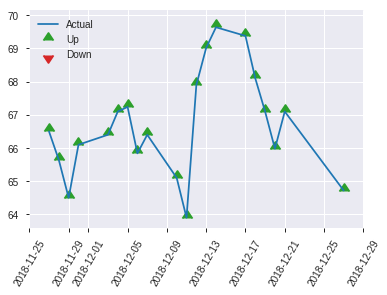


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24350798916211785
RMSE: 0.4934652866839955
LogLoss: 0.6800201671002525
Mean Per-Class Error: 0.41133720930232553
AUC: 0.6029069767441861
pr_auc: 0.610747210164978
Gini: 0.20581395348837228
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3064655065536499: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    117  0.975    (117.0/120.0)
1      0    129  0        (0.0/129.0)
Total  3    246  0.4699   (117.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.306466     0.688     245
max f2                       0.306466     0.846457  245
max f0point5                 0.460765     0.595745  143
max accuracy                 0.482392     0.582329  112
max precision                0.576408     0.772727  21
max recall                   0.306466     1         245
max specificity              0.666591     0.991667  0
max absolute_mcc             0.525945     0.215002  53
max min_per_class_accuracy   0.477014     0.565891  122
max mean_per_class_accuracy  0.525945     0.588663  53

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 47.24 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.650665           1.28682   1.28682            0.666667         0.661442  0.666667                    0.661442            0.0155039       0.0155039                  28.6822   28.6822
    2        0.0200803                   0.628546           0.965116  1.15814            0.5              0.637303  0.6                         0.651786            0.00775194      0.0232558                  -3.48837  15.814
    3        0.0321285                   0.61722            1.28682   1.2064             0.666667         0.624924  0.625                       0.641713            0.0155039       0.0387597                  28.6822   20.6395
    4        0.0401606                   0.608043           1.93023   1.35116            1                0.610653  0.7                         0.635501            0.0155039       0.0542636                  93.0233   35.1163
    5        0.0522088                   0.603436           0.643411  1.18784            0.333333         0.606059  0.615385                    0.628707            0.00775194      0.0620155                  -35.6589  18.7835
    6        0.100402                    0.564357           1.60853   1.38977            0.833333         0.583214  0.72                        0.60687             0.0775194       0.139535                   60.8527   38.9767
    7        0.15261                     0.547595           1.33631   1.37148            0.692308         0.554995  0.710526                    0.589124            0.0697674       0.209302                   33.6315   37.1481
    8        0.200803                    0.528421           1.44767   1.38977            0.75             0.538273  0.72                        0.57692             0.0697674       0.27907                    44.7674   38.9767
    9        0.301205                    0.512803           0.926512  1.23535            0.48             0.520248  0.64                        0.558029            0.0930233       0.372093                   -7.34884  23.5349
    10       0.401606                    0.492966           1.08093   1.19674            0.56             0.502071  0.62                        0.54404             0.108527        0.48062                    8.09302   19.6744
    11       0.502008                    0.473682           0.849302  1.12726            0.44             0.483189  0.584                       0.53187             0.0852713       0.565891                   -15.0698  12.7256
    12       0.598394                    0.455474           0.88469   1.08818            0.458333         0.464752  0.563758                    0.521059            0.0852713       0.651163                   -11.531   8.81848
    13       0.698795                    0.433706           1.08093   1.08714            0.56             0.44752   0.563218                    0.510493            0.108527        0.75969                    8.09302   8.71425
    14       0.799197                    0.40936            0.926512  1.06696            0.48             0.420781  0.552764                    0.499222            0.0930233       0.852713                   -7.34884  6.69627
    15       0.899598                    0.375155           0.694884  1.02544            0.36             0.392557  0.53125                     0.487318            0.0697674       0.922481                   -30.5116  2.5436
    16       1                           0.274176           0.772093  1                  0.4              0.338972  0.518072                    0.472424           

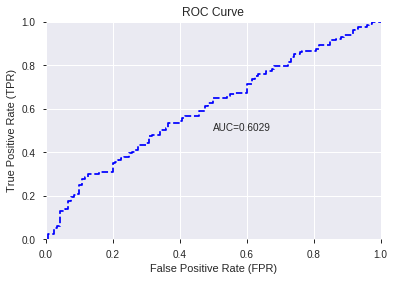

This function is available for GLM models only


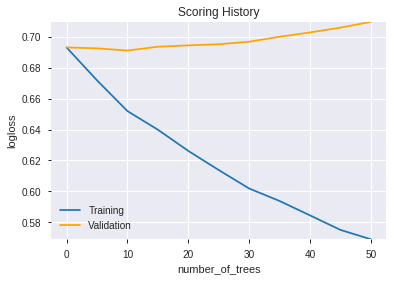

--2019-08-25 13:12:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.136.188
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.136.188|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190825_131131_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190825_131131_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCH_slowd',
 'MFI_12',
 'HT_PHASOR_inphase',
 'ROC_8',
 'CORREL_12',
 'dayofyear',
 'MOM_24',
 'MOM_14',
 'Volume',
 'ADX_12',
 'STOCH_slowk',
 'HT_DCPERIOD',
 'CCI_30',
 'HT_PHASOR_quadrature',
 'STDDEV_24',
 'BETA_12',
 'CORREL_20',
 'weekday_name',
 'ULTOSC',
 'DX_30',
 'day',
 'BETA_14',
 'ROC_24',
 'AROONOSC_12',
 'BBANDS_upperband_12_6_4',
 'ADXR_14',
 'TAN',
 'COS',
 'CCI_12',
 'WILLR_24',
 'BETA_8',
 'DIV',
 'ADXR_8',
 'MINUS_DI_30',
 'STDDEV_30',
 'WILLR_8',
 'week',
 'MINUS_DI_8',
 'MACDEXT_hist',
 'NATR_30',
 'DX_20',
 'TRANGE',
 'MFI_14',
 'ADXR_12',
 'MACDFIX_signal_8',
 'BBANDS_lowerband_30_7_5',
 'STOCHRSI_fastd',
 'TRIX_8',
 'ADOSC',
 'VAR_24',
 'MINUS_DI_12',
 'AD',
 'ROC_20',
 'MINUS_DM_8',
 'NATR_8',
 'ROCP_24',
 'SAR_0.12',
 'BBANDS_lowerband_24_5_2',
 'BBANDS_upperband_12_7_5',
 'ROC_14',
 'BETA_20',
 'PPO',
 'WILLR_30',
 'NATR_14',
 'LINEARREG_INTERCEPT_30',
 'MACDFIX_hist_24',
 'MINUS_DM_24',
 'MFI_20',
 'CORREL_30',
 'BBANDS_lowerband_8_2_5',
 'MACD_

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

141

['BBANDS_middleband_14_1_3',
 'BBANDS_upperband_14_1_5',
 'BBANDS_upperband_14_2_3',
 'BBANDS_middleband_14_2_4',
 'BBANDS_upperband_14_3_3',
 'BBANDS_upperband_14_3_4',
 'BBANDS_lowerband_14_3_5',
 'BBANDS_upperband_14_4_2',
 'BBANDS_upperband_14_4_4',
 'BBANDS_lowerband_14_4_4',
 'BBANDS_middleband_14_4_5',
 'BBANDS_middleband_14_5_2',
 'BBANDS_upperband_14_6_3',
 'BBANDS_middleband_14_7_5',
 'KAMA_20',
 'TRIMA_20',
 'BBANDS_upperband_20_0_4',
 'BBANDS_lowerband_20_1_5',
 'BBANDS_middleband_20_2_2',
 'BBANDS_middleband_20_2_3',
 'BBANDS_middleband_20_3_5',
 'MAVP_20_5',
 'BBANDS_upperband_20_5_4',
 'BBANDS_lowerband_20_6_4',
 'BBANDS_upperband_24_1_4',
 'BBANDS_upperband_24_7_2',
 'BOP',
 'aroondown_8',
 'CMO_8',
 'MACDFIX_8',
 'MINUS_DI_8',
 'MOM_8',
 'PLUS_DI_8',
 'ROC_8',
 'ROCP_8',
 'ROCR100_8',
 'RSI_8',
 'ADXR_12',
 'aroondown_12',
 'CCI_12',
 'CMO_12',
 'MACDFIX_hist_12',
 'MOM_12',
 'PLUS_DI_12',
 'PLUS_DM_12',
 'ROCR_12',
 'RSI_12',
 'WILLR_12',
 'ADXR_14',
 'aroonup_14',
 '

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190825_131444_model_3  0.588501  0.706121              0.500000  0.503181  0.253191
1               DeepLearning_1_AutoML_20190825_131444  0.563824  0.791892              0.478876  0.536250  0.287564
2  DeepLearning_grid_1_AutoML_20190825_131444_model_8  0.558721  0.690853              0.483333  0.498663  0.248665
3  DeepLearning_grid_1_AutoML_20190825_131444_model_2  0.558656  0.763805              0.500000  0.521988  0.272471
4  DeepLearning_grid_1_AutoML_20190825_131444_model_7  0.554522  0.814775              0.487500  0.545605  0.297684
5  DeepLearning_grid_1_AutoML_20190825_131444_model_6  0.544897  0.692804              0.495833  0.499537  0.249537
6  DeepLearning_grid_1_AutoML_20190825_131444_model_1  0.544574  1.409792              0.491667  0.628678  0.395236
7  DeepLearning_grid_1_AutoML_20190825_131444_model_5  0.543831  0.688131              0.462500  0.497485  0.247492
8  DeepLearning_grid_1_AutoML_20190825_131444_model_9  0.531266  0.696614              0.469961  0.501701  0.251704
9  DeepLearning_grid_1_AutoML_20190825_131444_model_4  0.526034  0.864463              0.478295  0.550187  0.302706

variable  relative_importance  scaled_importance  percentage
0                BOP             1.000000           1.000000    0.010179
1        aroondown_8             0.974245           0.974245    0.009917
2         aroonup_20             0.888506           0.888506    0.009044
3                 AD             0.867751           0.867751    0.008833
4           CORREL_8             0.858855           0.858855    0.008742
..               ...                  ...                ...         ...
136  MACDFIX_hist_14             0.612569           0.612569    0.006235
137           ROC_14             0.610218           0.610218    0.006211
138           RSI_14             0.605725           0.605725    0.006166
139          ROCR_30             0.601895           0.601895    0.006127
140        CDLHARAMI             0.590948           0.590948    0.006015

[141 rows x 4 columns]

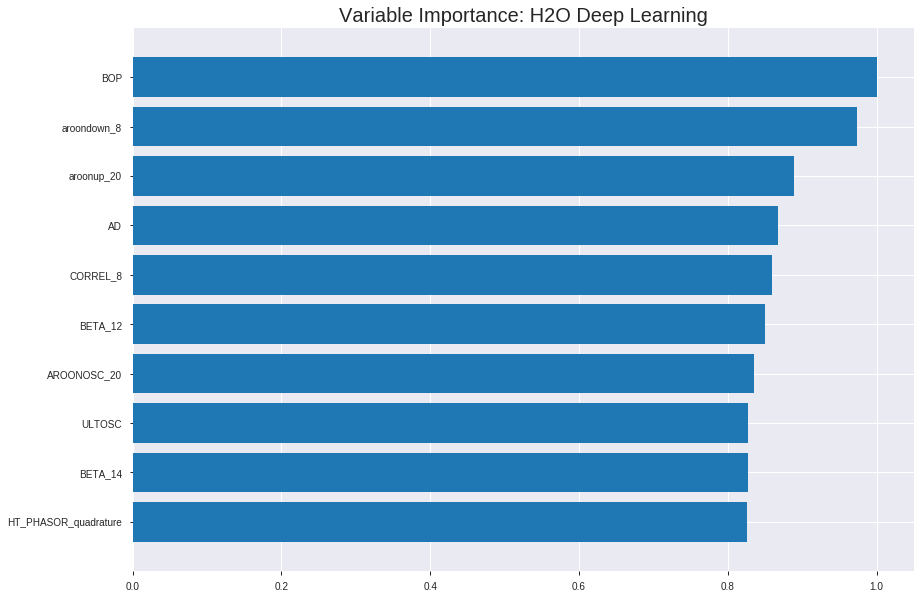

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190825_131444_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2582383002113158
RMSE: 0.5081715263681307
LogLoss: 0.7204089369173013
Mean Per-Class Error: 0.4351141208929019
AUC: 0.5825010230617929
pr_auc: 0.5649904360591096
Gini: 0.1650020461235857
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2257179822794432: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      33   822   0.9614   (822.0/855.0)
1      8    878   0.009    (8.0/886.0)
Total  41   1700  0.4767   (830.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.225718     0.679041  377
max f2                       0.103791     0.838221  399
max f0point5                 0.486333     0.583549  242
max accuracy                 0.488693     0.566916  240
max precision                0.885749     0.605263  17
max recall                   0.103791     1         399
max specificity              0.948761     0.99883   0
max absolute_mcc             0.486333     0.134608  242
max min_per_class_accuracy   0.561544     0.554386  195
max mean_per_class_accuracy  0.603129     0.564886  168

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 56.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0103389                   0.915271           0.982506  0.982506           0.5              0.930639  0.5                         0.930639            0.010158        0.010158                   -1.74944   -1.74944
    2        0.0201034                   0.886066           1.38707   1.17901            0.705882         0.898502  0.6                         0.91503             0.013544        0.023702                   38.7067    17.9007
    3        0.0304423                   0.871425           0.873338  1.07519            0.444444         0.878868  0.54717                     0.902748            0.00902935      0.0327314                  -12.6662   7.51949
    4        0.0402068                   0.858155           1.27148   1.12286            0.647059         0.863409  0.571429                    0.893194            0.0124153       0.0451467                  27.1478    12.2864
    5        0.0505457                   0.848879           1.09167   1.11648            0.555556         0.854238  0.568182                    0.885226            0.0112867       0.0564334                  9.16729    11.6484
    6        0.100517                    0.79745            1.21966   1.16778            0.62069          0.823704  0.594286                    0.854641            0.0609481       0.117381                   21.9662    16.7778
    7        0.150488                    0.756316           1.19708   1.17751            0.609195         0.774581  0.599237                    0.828056            0.0598194       0.177201                   19.7076    17.7507
    8        0.20046                     0.722739           1.17449   1.17675            0.597701         0.737623  0.598854                    0.805513            0.0586907       0.235892                   17.449     17.6755
    9        0.300402                    0.668173           1.1632    1.17224            0.591954         0.695587  0.596558                    0.768941            0.116253        0.352144                   16.3196    17.2244
    10       0.400345                    0.613889           1.05026   1.14179            0.534483         0.642618  0.581062                    0.737406            0.104966        0.457111                   5.02647    14.1793
    11       0.500287                    0.561464           0.993799  1.11223            0.505747         0.586248  0.566016                    0.707209            0.0993228       0.556433                   -0.620119  11.2228
    12       0.60023                     0.50847            1.00509   1.09439            0.511494         0.532786  0.556938                    0.678166            0.100451        0.656885                   0.509198   9.43891
    13       0.700172                    0.45638            0.993799  1.08003            0.505747         0.483375  0.549631                    0.650362            0.0993228       0.756208                   -0.620119  8.00308
    14       0.800115                    0.398267           0.89216   1.05656            0.454023         0.428416  0.537688                    0.622638            0.0891648       0.845372                   -10.784    5.65639
    15       0.900057                    0.330547           0.846988  1.03329            0.431034         0.368386  0.525846                    0.594406            0.0846501       0.930023                   -15.3012   3.32925
    16       1                           0.103646           0.700176  1                  0.356322         0.262747  0.508903                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.28811246264064994
RMSE: 0.5367610852517626
LogLoss: 0.80797195922438
Mean Per-Class Error: 0.4479309621066567
AUC: 0.5400003229087622
pr_auc: 0.5271465642269885
Gini: 0.08000064581752442
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2195443263699903: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   204  0.8465   (204.0/241.0)
1      18   239  0.07     (18.0/257.0)
Total  55   443  0.4458   (222.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.219544     0.682857  351
max f2                       0.0896782    0.842071  399
max f0point5                 0.219544     0.58896   351
max accuracy                 0.219544     0.554217  351
max precision                0.532605     0.577181  131
max recall                   0.0896782    1         399
max specificity              0.986322     0.995851  0
max absolute_mcc             0.219544     0.133112  351
max min_per_class_accuracy   0.415883     0.547718  207
max mean_per_class_accuracy  0.41141      0.552069  209

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 44.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.965152           0.775097  0.775097           0.4              0.979767  0.4                         0.979767            0.0077821       0.0077821                  -22.4903  -22.4903
    2        0.0200803                   0.952237           0.775097  0.775097           0.4              0.9618    0.4                         0.970784            0.0077821       0.0155642                  -22.4903  -22.4903
    3        0.0301205                   0.929622           0.775097  0.775097           0.4              0.943822  0.4                         0.961796            0.0077821       0.0233463                  -22.4903  -22.4903
    4        0.0401606                   0.899864           1.55019   0.968872           0.8              0.9213    0.5                         0.951672            0.0155642       0.0389105                  55.0195   -3.11284
    5        0.0502008                   0.875461           0.775097  0.930117           0.4              0.88999   0.48                        0.939336            0.0077821       0.0466926                  -22.4903  -6.98833
    6        0.100402                    0.752945           0.852607  0.891362           0.44             0.811649  0.46                        0.875492            0.0428016       0.0894942                  -14.7393  -10.8638
    7        0.150602                    0.680088           1.08514   0.955953           0.56             0.715374  0.493333                    0.82212             0.0544747       0.143969                   8.51362   -4.40467
    8        0.200803                    0.628727           1.00763   0.968872           0.52             0.650066  0.5                         0.779106            0.0505837       0.194553                   0.762646  -3.11284
    9        0.301205                    0.530331           1.39518   1.11097            0.72             0.57326   0.573333                    0.710491            0.140078        0.33463                    39.5175   11.0973
    10       0.399598                    0.476104           0.909553  1.06138            0.469388         0.503977  0.547739                    0.659641            0.0894942       0.424125                   -9.04471  6.13769
    11       0.5                         0.416499           1.2014    1.08949            0.62             0.447211  0.562249                    0.616984            0.120623        0.544747                   20.1401   8.94942
    12       0.600402                    0.354981           0.968872  1.06932            0.5              0.384789  0.551839                    0.578156            0.0972763       0.642023                   -3.11284  6.93232
    13       0.698795                    0.309674           0.830461  1.03569            0.428571         0.334291  0.534483                    0.543818            0.0817121       0.723735                   -16.9539  3.56903
    14       0.799197                    0.26305            0.968872  1.0273             0.5              0.285468  0.530151                    0.511362            0.0972763       0.821012                   -3.11284  2.7296
    15       0.899598                    0.208196           1.12389   1.03808            0.58             0.238882  0.535714                    0.480951            0.11284         0.933852                   12.3891   3.80767
    16       1                           0.0896782          0.658833  1                  0.34             0.151811  0.516064                    0.447905  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:16:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-25 13:16:23  1 min 38.303 sec  2761 obs/sec      5.31993   1             9262       0.602682         1.30649             -0.453365      0.536692        0.528336           0.764171         0.491097                         0.689879           2.74762               -0.905702        0.532178          0.519646             0.387549           0.467871
    2019-08-25 13:16:30  1 min 44.449 sec  2985 obs/sec      15.9294   3             27733      0.512667         0.740384            -0.0516419     0.597747        0.596616           1.20084          0.4888                           0.630114           1.26129               -0.589818        0.511261          0.504247             0.775097           0.461847
    2019-08-25 13:16:35  1 min 49.990 sec  3162 obs/sec      26.5485   5             46221      0.508172         0.720409            -0.0332808     0.582501        0.56499            0.982506         0.476738                         0.536761           0.807972              -0.153641        0.54              0.527147             0.775097           0.445783
    2019-08-25 13:16:40  1 min 55.078 sec  3316 obs/sec      37.1453   7             64670      0.497408         0.697753            0.0100273      0.617138        0.616847           1.52834          0.487076                         0.62846            1.25119               -0.581481        0.519544          0.516736             0.775097           0.471888
    2019-08-25 13:16:47  2 min  2.037 sec  3518 obs/sec      53.0615   10            92380      0.488057         0.676097            0.0469         0.648938        0.640256           1.52834          0.41815                          0.617156           1.19332               -0.525101        0.515346          0.510808             0.775097           0.473896
    2019-08-25 13:16:54  2 min  8.494 sec  3701 obs/sec      69.027    13            120176     0.491591         0.685734            0.0330465      0.692493        0.678801           1.63751          0.409535                         0.657096           1.55306               -0.728885        0.534923          0.527879             0.387549           0.473896
    2019-08-25 13:17:00  2 min 14.620 sec  3851 obs/sec      84.9127   16            147833     0.460008         0.611573            0.153301       0.734915        0.726053           1.63751          0.341758                         0.591897           1.04918               -0.402815        0.529917          0.526193             0.775097           0.483936
    2019-08-25 13:17:00  2 min 14.843 sec  3850 obs/sec      84.9127   16            147833     0.508172         0.720409            -0.0332808     0.582501        0.56499            0.982506         0.476738                         0.536761           0.807972              -0.153641        0.54              0.527147             0.775097           0.445783

Variable Importances: 


variable         relative_importance    scaled_importance    percentage
---------------  ---------------------  -------------------  --------------------
BOP              1.0                    1.0                  0.010178937156149993
aroondown_8      0.9742449522018433     0.9742449522018433   0.009916778143158916
aroonup_20       0.8885059356689453     0.8885059356689453   0.009044046082040444
AD               0.8677511811256409     0.8677511811256409   0.008832784739852828
CORREL_8         0.8588553071022034     0.8588553071022034   0.00874223419721923
---              ---                    ---                  ---
MACDFIX_hist_14  0.6125687956809998     0.6125687956809998   0.006235299275055382
ROC_14           0.6102181077003479     0.6102181077003479   0.00621137176982661
RSI_14           0.6057248115539551     0.6057248115539551   0.006165634790728506
ROCR_30          0.6018950939178467     0.6018950939178467   0.006126652335584759
CDLHARAMI        0.5909484624862671     0.5909484624862671   0.006015227262171174


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.606425702811245)

('F1', 0.6825396825396826)

('auc', 0.588501291989664)

('logloss', 0.7061207685275132)

('mean_per_class_error', 0.3929263565891472)

('rmse', 0.5031810055419874)

('mse', 0.25319112433824553)

deeplearning prediction progress: |███████████████████████████████████████| 100%


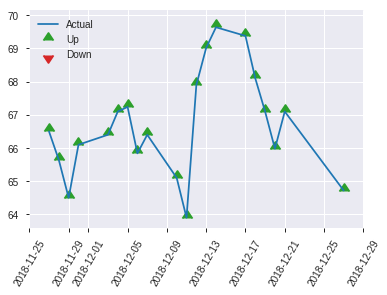


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25319112433824553
RMSE: 0.5031810055419874
LogLoss: 0.7061207685275132
Mean Per-Class Error: 0.3929263565891472
AUC: 0.588501291989664
pr_auc: 0.5679207042030634
Gini: 0.1770025839793281
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1220528264851391: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    120  1        (120.0/120.0)
1      0    129  0        (0.0/129.0)
Total  0    249  0.4819   (120.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.122053     0.68254   248
max f2                       0.122053     0.843137  248
max f0point5                 0.529529     0.620032  124
max accuracy                 0.532711     0.606426  120
max precision                0.828914     1         0
max recall                   0.122053     1         248
max specificity              0.828914     1         0
max absolute_mcc             0.532711     0.214092  120
max min_per_class_accuracy   0.529529     0.604651  124
max mean_per_class_accuracy  0.532711     0.607074  120

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 52.30 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.810793           1.28682   1.28682            0.666667         0.820481  0.666667                    0.820481            0.0155039       0.0155039                  28.6822   28.6822
    2        0.0200803                   0.786272           0         0.772093           0                0.801871  0.4                         0.813037            0               0.0155039                  -100      -22.7907
    3        0.0321285                   0.773108           1.28682   0.965116           0.666667         0.78303   0.5                         0.801785            0.0155039       0.0310078                  28.6822   -3.48837
    4        0.0401606                   0.757741           0.965116  0.965116           0.5              0.763741  0.5                         0.794176            0.00775194      0.0387597                  -3.48837  -3.48837
    5        0.0522088                   0.740776           0.643411  0.890877           0.333333         0.748679  0.461538                    0.783676            0.00775194      0.0465116                  -35.6589  -10.9123
    6        0.100402                    0.714222           1.12597   1.00372            0.583333         0.727884  0.52                        0.756896            0.0542636       0.100775                   12.5969   0.372093
    7        0.15261                     0.684854           0.890877  0.965116           0.461538         0.700924  0.5                         0.737748            0.0465116       0.147287                   -10.9123  -3.48837
    8        0.200803                    0.662948           1.76938   1.15814            0.916667         0.675307  0.6                         0.722762            0.0852713       0.232558                   76.938    15.814
    9        0.301205                    0.610432           1.15814   1.15814            0.6              0.637151  0.6                         0.694225            0.116279        0.348837                   15.814    15.814
    10       0.401606                    0.5639             1.15814   1.15814            0.6              0.583053  0.6                         0.666432            0.116279        0.465116                   15.814    15.814
    11       0.502008                    0.529529           1.38977   1.20447            0.72             0.54659   0.624                       0.642464            0.139535        0.604651                   38.9767   20.4465
    12       0.598394                    0.494705           0.88469   1.15296            0.458333         0.514847  0.597315                    0.621908            0.0852713       0.689922                   -11.531   15.2958
    13       0.698795                    0.448056           0.772093  1.09824            0.4              0.47443   0.568966                    0.600719            0.0775194       0.767442                   -22.7907  9.82358
    14       0.799197                    0.390718           0.617674  1.03786            0.32             0.41717   0.537688                    0.57766             0.0620155       0.829457                   -38.2326  3.78637
    15       0.899598                    0.317586           0.772093  1.0082             0.4              0.360253  0.522321                    0.553396            0.0775194       0.906977                   -22.7907  0.820183
    16       1                           0.122053           0.926512  1                  0.48             0.250206  0.518072                    0.522955     

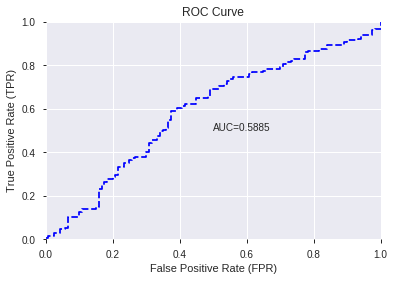

This function is available for GLM models only


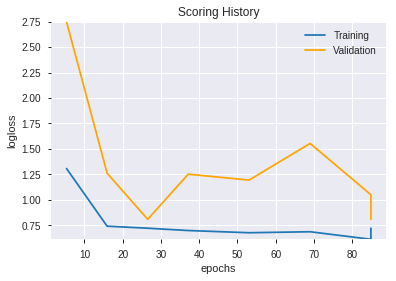

--2019-08-25 13:26:52--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.3
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190825_131444_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190825_131444_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'aroondown_8',
 'aroonup_20',
 'AD',
 'CORREL_8',
 'BETA_12',
 'AROONOSC_20',
 'ULTOSC',
 'BETA_14',
 'HT_PHASOR_quadrature',
 'NATR_12',
 'CORREL_14',
 'ADXR_12',
 'STOCH_slowk',
 'STOCH_slowd',
 'aroonup_24',
 'STOCHF_fastk',
 'aroondown_12',
 'aroonup_14',
 'TRANGE',
 'ADXR_14',
 'aroonup_30',
 'CORREL_12',
 'NATR_20',
 'DX_14',
 'CDLSHORTLINE',
 'aroondown_20',
 'OBV',
 'STOCHRSI_fastd',
 'ADX_24',
 'CCI_12',
 'AROONOSC_30',
 'NATR_30',
 'MINUS_DM_20',
 'WILLR_12',
 'ADOSC',
 'AROONOSC_24',
 'MFI_30',
 'MFI_14',
 'STDDEV_8',
 'BBANDS_lowerband_20_1_5',
 'MFI_24',
 'CDLCLOSINGMARUBOZU',
 'ROCP_8',
 'aroondown_30',
 'BBANDS_upperband_24_1_4',
 'MOM_20',
 'BBANDS_upperband_14_1_5',
 'CDLSPINNINGTOP',
 'PLUS_DM_20',
 'LINEARREG_ANGLE_14',
 'BBANDS_lowerband_14_4_4',
 'WILLR_14',
 'PLUS_DM_12',
 'CDLHIGHWAVE',
 'STDDEV_12',
 'ROCP_20',
 'BBANDS_middleband_20_3_5',
 'CCI_30',
 'BBANDS_lowerband_20_6_4',
 'CDLBELTHOLD',
 'ATR_14',
 'BBANDS_upperband_14_6_3',
 'MINUS_DI_8',
 'PLUS

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190825_132748_model_1  0.553036  0.688326              0.486919  0.497593  0.247599

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.028050           1.000000    0.040882
1               CDLSHORTLINE             0.026645           0.949930    0.038835
2         CDLCLOSINGMARUBOZU             0.025516           0.909684    0.037190
3                 CDLHIKKAKE             0.018754           0.668619    0.027334
4                         AD             0.017617           0.628066    0.025677
..                       ...                  ...                ...         ...
136  BBANDS_upperband_14_1_5             0.000228           0.008115    0.000332
137           CDLSPINNINGTOP             0.000224           0.007982    0.000326
138  BBANDS_upperband_20_0_4             0.000177           0.006294    0.000257
139             LINEARREG_14             0.000172           0.006131    0.000251
140               MINUS_DI_8             0.000085           0.003014    0.000123

[141 rows x 4 columns]

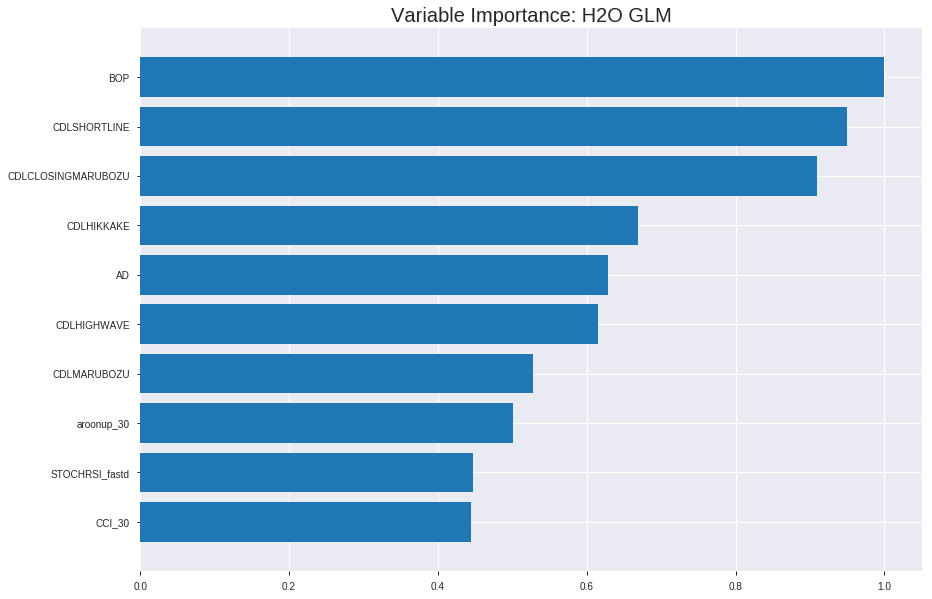

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190825_132748_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24602967418031815
RMSE: 0.4960137842644276
LogLoss: 0.6851810235157869
Null degrees of freedom: 1740
Residual degrees of freedom: 1599
Null deviance: 2412.986471918777
Residual deviance: 2385.80032388197
AIC: 2669.80032388197
AUC: 0.586055997782266
pr_auc: 0.5793036867041074
Gini: 0.17211199556453205
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42530001107728066: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      7    848   0.9918   (848.0/855.0)
1      2    884   0.0023   (2.0/886.0)
Total  9    1732  0.4882   (850.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.4253       0.675325  391
max f2                       0.417632     0.838539  397
max f0point5                 0.469809     0.581093  314
max accuracy                 0.503944     0.568064  213
max precision                0.586574     0.916667  9
max recall                   0.417632     1         397
max specificity              0.632081     0.99883   0
max absolute_mcc             0.527626     0.135344  138
max min_per_class_accuracy   0.508919     0.562573  198
max mean_per_class_accuracy  0.503944     0.567129  213

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.579879           1.52834   1.52834            0.777778         0.593718  0.777778                    0.593718            0.0158014       0.0158014                  52.8342   52.8342
    2        0.0201034                   0.572883           1.27148   1.40358            0.647059         0.576329  0.714286                    0.585272            0.0124153       0.0282167                  27.1478   40.3579
    3        0.0304423                   0.568059           1.09167   1.29765            0.555556         0.570318  0.660377                    0.580193            0.0112867       0.0395034                  9.16729   29.7649
    4        0.0402068                   0.564185           1.27148   1.29129            0.647059         0.565802  0.657143                    0.576698            0.0124153       0.0519187                  27.1478   29.1293
    5        0.0505457                   0.561561           0.655004  1.16114            0.333333         0.562764  0.590909                    0.573848            0.00677201      0.0586907                  -34.4996  16.1143
    6        0.100517                    0.551488           1.19708   1.17901            0.609195         0.556136  0.6                         0.565043            0.0598194       0.11851                    19.7076   17.9007
    7        0.150488                    0.54528            1.24225   1.20001            0.632184         0.548387  0.610687                    0.559512            0.0620767       0.180587                   24.2249   20.0007
    8        0.20046                     0.539318           1.24225   1.21054            0.632184         0.542456  0.616046                    0.55526             0.0620767       0.242664                   24.2249   21.0537
    9        0.300402                    0.528318           1.1632    1.19479            0.591954         0.53378   0.608031                    0.548114            0.116253        0.358916                   16.3196   19.4787
    10       0.400345                    0.518421           1.00509   1.14743            0.511494         0.523221  0.583931                    0.5419              0.100451        0.459368                   0.509198  14.7431
    11       0.500287                    0.508909           1.02768   1.12351            0.522989         0.513665  0.571757                    0.536259            0.102709        0.562077                   2.76783   12.3508
    12       0.60023                     0.500533           0.971212  1.09815            0.494253         0.504493  0.558852                    0.53097             0.0970655       0.659142                   -2.87875  9.81498
    13       0.700172                    0.490832           0.948626  1.07681            0.482759         0.495562  0.54799                     0.525916            0.0948081       0.75395                    -5.13739  7.68068
    14       0.800115                    0.480512           0.835694  1.04669            0.425287         0.485855  0.532663                    0.520912            0.0835214       0.837472                   -16.4306  4.66894
    15       0.900057                    0.463734           0.914747  1.03204            0.465517         0.472234  0.525207                    0.515507            0.0914221       0.928894                   -8.52534  3.20385
    16       1                           0.412678           0.71147   1                  0.362069         0.449432  0.508903                    0.508903         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24887765483758034
RMSE: 0.4988763923434144
LogLoss: 0.6908924297875739
Null degrees of freedom: 497
Residual degrees of freedom: 356
Null deviance: 689.962659370588
Residual deviance: 688.1288600684236
AIC: 972.1288600684236
AUC: 0.5305310234593216
pr_auc: 0.5421154890798328
Gini: 0.06106204691864314
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43820678796792417: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    239  0.9917   (239.0/241.0)
1      0    257  0        (0.0/257.0)
Total  2    496  0.4799   (239.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.438207     0.682603  397
max f2                       0.438207     0.843176  397
max f0point5                 0.478287     0.580795  325
max accuracy                 0.480105     0.544177  316
max precision                0.603072     1         0
max recall                   0.438207     1         397
max specificity              0.603072     1         0
max absolute_mcc             0.478287     0.091242  325
max min_per_class_accuracy   0.508752     0.510373  195
max mean_per_class_accuracy  0.480105     0.533954  316

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 50.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.57206            1.16265   1.16265            0.6              0.589343  0.6                         0.589343            0.0116732       0.0116732                  16.2646   16.2646
    2        0.0200803                   0.564358           1.55019   1.35642            0.8              0.568923  0.7                         0.579133            0.0155642       0.0272374                  55.0195   35.642
    3        0.0301205                   0.560673           1.16265   1.29183            0.6              0.562628  0.666667                    0.573631            0.0116732       0.0389105                  16.2646   29.1829
    4        0.0401606                   0.558561           0.387549  1.06576            0.2              0.559316  0.55                        0.570052            0.00389105      0.0428016                  -61.2451  6.57588
    5        0.0502008                   0.555909           1.16265   1.08514            0.6              0.557347  0.56                        0.567511            0.0116732       0.0544747                  16.2646   8.51362
    6        0.100402                    0.545319           1.16265   1.12389            0.6              0.550834  0.58                        0.559173            0.0583658       0.11284                    16.2646   12.3891
    7        0.150602                    0.540033           0.930117  1.0593             0.48             0.542906  0.546667                    0.55375             0.0466926       0.159533                   -6.98833  5.92996
    8        0.200803                    0.533011           1.00763   1.04638            0.52             0.536105  0.54                        0.549339            0.0505837       0.210117                   0.762646  4.63813
    9        0.301205                    0.525714           1.00763   1.03346            0.52             0.529413  0.533333                    0.542697            0.101167        0.311284                   0.762646  3.3463
    10       0.399598                    0.515553           1.14683   1.06138            0.591837         0.521108  0.547739                    0.537381            0.11284         0.424125                   14.6828   6.13769
    11       0.5                         0.508812           0.852607  1.01946            0.44             0.51258   0.526104                    0.532401            0.0856031       0.509728                   -14.7393  1.94553
    12       0.600402                    0.49958            0.968872  1.011              0.5              0.503807  0.521739                    0.527619            0.0972763       0.607004                   -3.11284  1.09964
    13       0.698795                    0.491516           1.14683   1.03012            0.591837         0.495761  0.531609                    0.523134            0.11284         0.719844                   14.6828   3.01221
    14       0.799197                    0.48143            1.08514   1.03703            0.56             0.486449  0.535176                    0.518525            0.108949        0.828794                   8.51362   3.70334
    15       0.899598                    0.46867            0.852607  1.01645            0.44             0.476599  0.524554                    0.513846            0.0856031       0.914397                   -14.7393  1.64501
    16       1                           0.421567           0.852607  1                  0.44             0.456949  0.516064                    0.508133           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-25 13:27:49  0.000 sec   2            3.7       142           1.37962           1.38434
    2019-08-25 13:27:49  0.048 sec   4            2.7       142           1.37824           1.38369
    2019-08-25 13:27:49  0.097 sec   6            2         142           1.37663           1.38303
    2019-08-25 13:27:49  0.150 sec   8            1.4       142           1.37477           1.38238
    2019-08-25 13:27:49  0.198 sec   10           1         142           1.37267           1.38192
    2019-08-25 13:27:49  0.251 sec   12           0.76      142           1.37036           1.38178
    2019-08-25 13:27:49  0.303 sec   14           0.55      142           1.36788           1.38216
    2019-08-25 13:27:49  0.354 sec   16           0.4       142           1.36524           1.38328
    2019-08-25 13:27:49  0.402 sec   18           0.29      142           1.36248           1.3853
    2019-08-25 13:27:49  0.454 sec   20           0.21      142           1.35964           1.38835
    2019-08-25 13:27:49  0.507 sec   22           0.15      142           1.3568            1.3924

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5742971887550201)

('F1', 0.6846361185983827)

('auc', 0.5530361757105944)

('logloss', 0.6883261576662278)

('mean_per_class_error', 0.42189922480620157)

('rmse', 0.4975930525829078)

('mse', 0.24759884597877646)

glm prediction progress: |████████████████████████████████████████████████| 100%


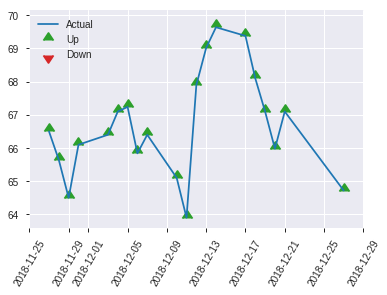


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24759884597877646
RMSE: 0.4975930525829078
LogLoss: 0.6883261576662278
Null degrees of freedom: 248
Residual degrees of freedom: 107
Null deviance: 344.9457142036249
Residual deviance: 342.78642651778154
AIC: 626.7864265177816
AUC: 0.5530361757105944
pr_auc: 0.5691430176276285
Gini: 0.10607235142118876
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45311822413935615: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    115  0.9583   (115.0/120.0)
1      2    127  0.0155   (2.0/129.0)
Total  7    242  0.4699   (117.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453118     0.684636  240
max f2                       0.432464     0.844241  246
max f0point5                 0.480453     0.588832  212
max accuracy                 0.517236     0.574297  97
max precision                0.574629     0.8       4
max recall                   0.432464     1         246
max specificity              0.598858     0.991667  0
max absolute_mcc             0.517236     0.159481  97
max min_per_class_accuracy   0.512103     0.534884  117
max mean_per_class_accuracy  0.517236     0.578101  97

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 51.20 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.583169           1.28682   1.28682            0.666667         0.591632  0.666667                    0.591632            0.0155039       0.0155039                  28.6822   28.6822
    2        0.0200803                   0.574616           1.93023   1.54419            1                0.576846  0.8                         0.585718            0.0155039       0.0310078                  93.0233   54.4186
    3        0.0321285                   0.569521           0.643411  1.2064             0.333333         0.572129  0.625                       0.580622            0.00775194      0.0387597                  -35.6589  20.6395
    4        0.0401606                   0.566854           0.965116  1.15814            0.5              0.567989  0.6                         0.578095            0.00775194      0.0465116                  -3.48837  15.814
    5        0.0522088                   0.562739           1.28682   1.18784            0.666667         0.564491  0.615385                    0.574956            0.0155039       0.0620155                  28.6822   18.7835
    6        0.100402                    0.554009           1.44767   1.31256            0.75             0.558264  0.68                        0.566944            0.0697674       0.131783                   44.7674   31.2558
    7        0.15261                     0.547814           0.742397  1.1175             0.384615         0.550669  0.578947                    0.561376            0.0387597       0.170543                   -25.7603  11.7503
    8        0.200803                    0.537452           1.12597   1.11953            0.583333         0.543182  0.58                        0.55701             0.0542636       0.224806                   12.5969   11.9535
    9        0.301205                    0.527176           1.23535   1.15814            0.64             0.532769  0.6                         0.548929            0.124031        0.348837                   23.5349   15.814
    10       0.401606                    0.516666           1.23535   1.17744            0.64             0.522021  0.61                        0.542202            0.124031        0.472868                   23.5349   17.7442
    11       0.502008                    0.510963           0.617674  1.06549            0.32             0.5136    0.552                       0.536482            0.0620155       0.534884                   -38.2326  6.54884
    12       0.598394                    0.501775           0.88469   1.03637            0.458333         0.507028  0.536913                    0.531737            0.0852713       0.620155                   -11.531   3.63665
    13       0.698795                    0.494985           0.772093  0.998396           0.4              0.498134  0.517241                    0.526909            0.0775194       0.697674                   -22.7907  -0.160385
    14       0.799197                    0.485807           1.15814   1.01846            0.6              0.491198  0.527638                    0.522423            0.116279        0.813953                   15.814    1.84644
    15       0.899598                    0.47718            1.00372   1.01682            0.52             0.481299  0.526786                    0.517833            0.100775        0.914729                   0.372093  1.68189
    16       1                           0.42946            0.849302  1                  0.44             0.459763  0.518072                    0.512003         

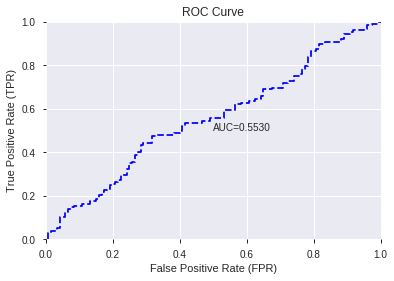

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


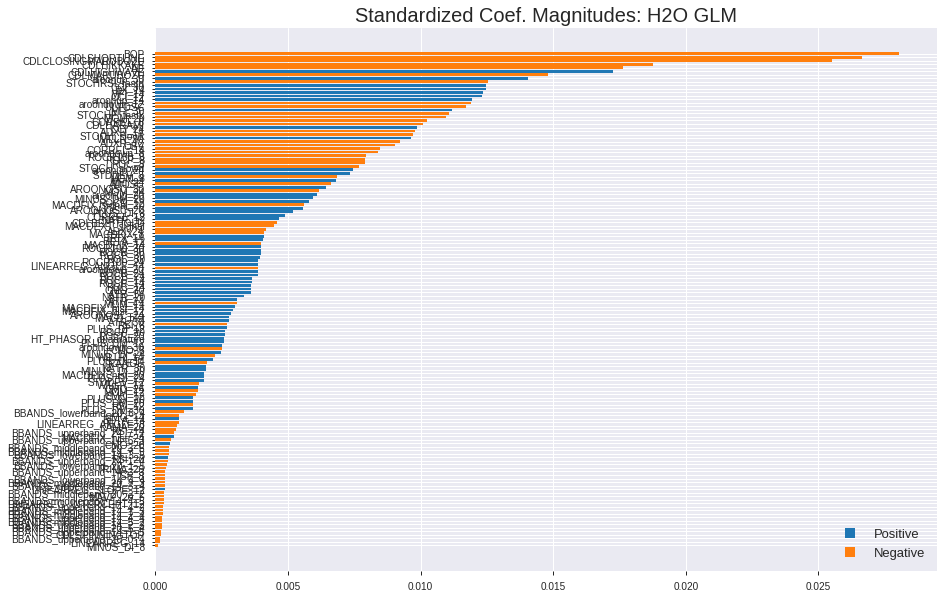

'log_likelihood'
--2019-08-25 13:28:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.171
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.171|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190825_132748_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190825_132748_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLSHORTLINE',
 'CDLCLOSINGMARUBOZU',
 'CDLHIKKAKE',
 'AD',
 'CDLHIGHWAVE',
 'CDLMARUBOZU',
 'aroonup_30',
 'STOCHRSI_fastd',
 'CCI_30',
 'DX_14',
 'MFI_14',
 'CCI_12',
 'aroonup_14',
 'aroondown_12',
 'ULTOSC',
 'MFI_30',
 'STOCHF_fastk',
 'MOM_20',
 'CORREL_8',
 'CDLHARAMI',
 'CCI_24',
 'ADXR_14',
 'STOCH_slowk',
 'WILLR_30',
 'ADXR_12',
 'OBV',
 'CORREL_14',
 'aroondown_8',
 'ROCR100_8',
 'ROCP_8',
 'ROC_8',
 'STOCH_slowd',
 'aroonup_24',
 'STDDEV_8',
 'MOM_8',
 'MFI_24',
 'ADOSC',
 'AROONOSC_30',
 'MOM_24',
 'aroonup_20',
 'MINUS_DM_20',
 'ROCR_12',
 'MACDFIX_signal_20',
 'AROONOSC_20',
 'PLUS_DI_8',
 'CORREL_12',
 'NATR_12',
 'CDLBELTHOLD',
 'MACDEXT_signal',
 'ADX_24',
 'MACDFIX_8',
 'TRIX_14',
 'BETA_12',
 'MACDFIX_14',
 'ROCR100_30',
 'ROCR_30',
 'ROCP_30',
 'ROC_30',
 'ROCR100_24',
 'LINEARREG_ANGLE_14',
 'aroondown_20',
 'ROCR_24',
 'ROCP_24',
 'ROCP_14',
 'ROCR_14',
 'ROC_14',
 'CMO_30',
 'ATR_14',
 'NATR_20',
 'ATR_24',
 'MOM_14',
 'MACDFIX_hist_14',
 'MACDFIX_his

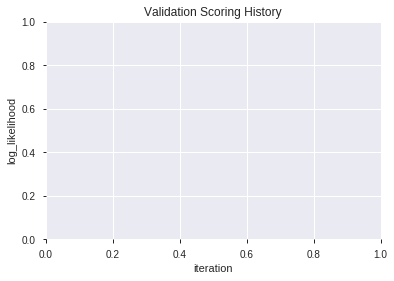

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190825_132857  0.603618  0.675793              0.474709  0.491442  0.241515
1  XGBoost_grid_1_AutoML_20190825_132857_model_5  0.580103  0.692928              0.456880  0.499645  0.249645
2  XGBoost_grid_1_AutoML_20190825_132857_model_6  0.570284  0.689222              0.478876  0.497998  0.248002
3  XGBoost_grid_1_AutoML_20190825_132857_model_2  0.561886  0.686887              0.487500  0.496875  0.246885
4  XGBoost_grid_1_AutoML_20190825_132857_model_7  0.560013  0.694698              0.469961  0.500598  0.250599
5  XGBoost_grid_1_AutoML_20190825_132857_model_1  0.540762  0.694299              0.474128  0.500478  0.250478
6               XGBoost_1_AutoML_20190825_132857  0.540698  0.701502              0.487209  0.503712  0.253726
7               XGBoost_2_AutoML_20190825_132857  0.524548  0.702112              0.473256  0.504222  0.254240
8  XGBoost_grid_1_AutoML_20190825_132857_model_4  0.523837  0.697428              0.495833  0.502048  0.252052
9  XGBoost_grid_1_AutoML_20190825_132857_model_3  0.516860  0.703462              0.487500  0.504861  0.254885

variable  relative_importance  scaled_importance  percentage
0                         BOP           223.393692           1.000000    0.042174
1                 STOCH_slowd           188.620895           0.844343    0.035610
2                 STOCH_slowk           142.136551           0.636260    0.026834
3                     BETA_12           135.783997           0.607824    0.025635
4                  MINUS_DI_8           128.240051           0.574054    0.024210
..                        ...                  ...                ...         ...
120                CDLHIKKAKE             3.980669           0.017819    0.000752
121  BBANDS_middleband_14_4_5             3.557570           0.015925    0.000672
122                    CMO_24             3.220669           0.014417    0.000608
123                aroonup_14             2.850339           0.012759    0.000538
124              aroondown_12             0.102510           0.000459    0.000019

[125 rows x 4 columns]

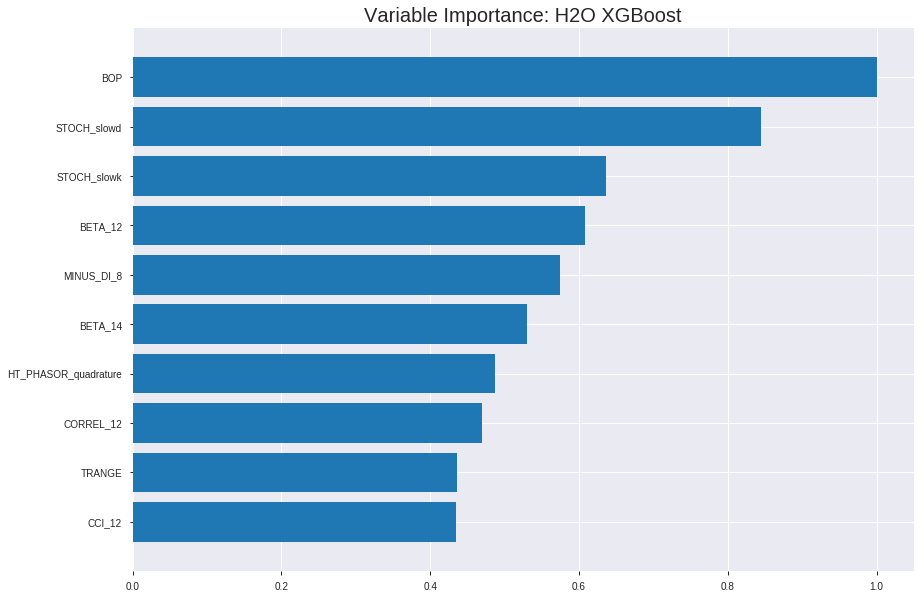

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190825_132857


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18005640768396594
RMSE: 0.4243305405977349
LogLoss: 0.5496321757436317
Mean Per-Class Error: 0.13939579950629022
AUC: 0.9445309096669439
pr_auc: 0.947755826845212
Gini: 0.8890618193338877
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4920698752005895: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      697  158  0.1848   (158.0/855.0)
1      85   801  0.0959   (85.0/886.0)
Total  782  959  0.1396   (243.0/1741.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49207      0.868293  219
max f2                       0.457567     0.914725  255
max f0point5                 0.53554      0.889359  173
max accuracy                 0.495986     0.860999  215
max precision                0.816212     1         0
max recall                   0.383613     1         327
max specificity              0.816212     1         0
max absolute_mcc             0.493815     0.72351   217
max min_per_class_accuracy   0.506424     0.85731   204
max mean_per_class_accuracy  0.519564     0.860604  189

Gains/Lift Table: Avg response rate: 50.89 %, avg score: 50.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0103389                   0.716761           1.96501    1.96501            1                0.740645  1                           0.740645            0.020316        0.020316                   96.5011   96.5011
    2        0.0201034                   0.698376           1.96501    1.96501            1                0.706639  1                           0.724128            0.0191874       0.0395034                  96.5011   96.5011
    3        0.0304423                   0.689333           1.96501    1.96501            1                0.692829  1                           0.713498            0.020316        0.0598194                  96.5011   96.5011
    4        0.0402068                   0.678656           1.96501    1.96501            1                0.683728  1                           0.706268            0.0191874       0.0790068                  96.5011   96.5011
    5        0.0505457                   0.673777           1.96501    1.96501            1                0.67639   1                           0.700157            0.020316        0.0993228                  96.5011   96.5011
    6        0.100517                    0.650942           1.96501    1.96501            1                0.661411  1                           0.680894            0.0981941       0.197517                   96.5011   96.5011
    7        0.150488                    0.633883           1.96501    1.96501            1                0.64205   1                           0.667996            0.0981941       0.295711                   96.5011   96.5011
    8        0.20046                     0.615822           1.94242    1.95938            0.988506         0.624419  0.997135                    0.657133            0.0970655       0.392777                   94.2425   95.9381
    9        0.300402                    0.581041           1.80691    1.90865            0.91954          0.59837   0.971319                    0.637583            0.180587        0.573363                   80.6907   90.8653
    10       0.400345                    0.539812           1.61492    1.83533            0.821839         0.559778  0.934003                    0.618159            0.1614          0.734763                   61.4923   83.5326
    11       0.500287                    0.508219           1.1632     1.70105            0.591954         0.523474  0.865672                    0.599244            0.116253        0.851016                   16.3196   70.1055
    12       0.60023                     0.474299           0.903453   1.56825            0.45977          0.491947  0.798086                    0.581378            0.0902935       0.941309                   -9.65465  56.8248
    13       0.700172                    0.441047           0.372675   1.39759            0.189655         0.457916  0.711239                    0.563755            0.037246        0.978555                   -62.7325  39.7592
    14       0.800115                    0.404938           0.180691   1.24559            0.091954         0.422005  0.633884                    0.546049            0.0180587       0.996614                   -81.9309  24.5589
    15       0.900057                    0.365864           0.0338795  1.11104            0.0172414        0.386604  0.565412                    0.528344            0.003386        1                          -96.612   11.104
    16       1                           0.253035           0          1                  0                0.330194  0.508903                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24996445127753122
RMSE: 0.4999644500137297
LogLoss: 0.6931710691579416
Mean Per-Class Error: 0.4512569223565881
AUC: 0.5435684647302904
pr_auc: 0.5485105671844992
Gini: 0.08713692946058083
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3419169485569: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    232  0.9627   (232.0/241.0)
1      3    254  0.0117   (3.0/257.0)
Total  12   486  0.4719   (235.0/498.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.341917     0.683715  387
max f2                       0.263818     0.842071  399
max f0point5                 0.403954     0.59194   338
max accuracy                 0.407562     0.560241  334
max precision                0.676826     0.75      3
max recall                   0.263818     1         399
max specificity              0.710084     0.995851  0
max absolute_mcc             0.403954     0.142921  338
max min_per_class_accuracy   0.499343     0.522822  199
max mean_per_class_accuracy  0.407562     0.548743  334

Gains/Lift Table: Avg response rate: 51.61 %, avg score: 49.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0100402                   0.67097            1.16265   1.16265            0.6              0.691716  0.6                         0.691716            0.0116732       0.0116732                  16.2646   16.2646
    2        0.0200803                   0.656329           1.55019   1.35642            0.8              0.663484  0.7                         0.6776              0.0155642       0.0272374                  55.0195   35.642
    3        0.0301205                   0.645979           1.55019   1.42101            0.8              0.651313  0.733333                    0.668838            0.0155642       0.0428016                  55.0195   42.1012
    4        0.0401606                   0.639976           0.775097  1.25953            0.4              0.643874  0.65                        0.662597            0.0077821       0.0505837                  -22.4903  25.9533
    5        0.0502008                   0.626688           0.387549  1.08514            0.2              0.63403   0.56                        0.656883            0.00389105      0.0544747                  -61.2451  8.51362
    6        0.100402                    0.603932           1.08514   1.08514            0.56             0.614656  0.56                        0.63577             0.0544747       0.108949                   8.51362   8.51362
    7        0.150602                    0.587556           0.930117  1.03346            0.48             0.595463  0.533333                    0.622334            0.0466926       0.155642                   -6.98833  3.3463
    8        0.200803                    0.575936           1.16265   1.06576            0.6              0.582969  0.55                        0.612493            0.0583658       0.214008                   16.2646   6.57588
    9        0.301205                    0.546881           1.16265   1.09805            0.6              0.559686  0.566667                    0.594891            0.116732        0.330739                   16.2646   9.80545
    10       0.399598                    0.52146            0.830461  1.03216            0.428571         0.533042  0.532663                    0.579662            0.0817121       0.412451                   -16.9539  3.21647
    11       0.5                         0.499503           1.08514   1.0428             0.56             0.508786  0.538153                    0.56543             0.108949        0.521401                   8.51362   4.28016
    12       0.600402                    0.473872           1.00763   1.03692            0.52             0.487241  0.535117                    0.552355            0.101167        0.622568                   0.762646  3.69194
    13       0.698795                    0.451446           1.10728   1.04683            0.571429         0.463007  0.54023                     0.539774            0.108949        0.731518                   10.7282   4.68268
    14       0.799197                    0.426385           1.04638   1.04677            0.54             0.43968   0.540201                    0.527199            0.105058        0.836576                   4.63813   4.67708
    15       0.899598                    0.391793           0.930117  1.03375            0.48             0.411103  0.533482                    0.514242            0.0933852       0.929961                   -6.98833  3.37514
    16       1                           0.263818           0.697588  1                  0.36             0.358179  0.516064                    0.498573           


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-25 13:29:01  0.003 sec   0                  0.5              0.693147            0.5             0                  1                0.491097                         0.5                0.693147              0.5               0                    1                  0.483936
    2019-08-25 13:29:01  0.122 sec   5                  0.487753         0.66891             0.804755        0.795176           1.76851          0.293509                         0.501183           0.695521              0.481191          0.490987             0.775097           0.483936
    2019-08-25 13:29:01  0.189 sec   10                 0.477127         0.648251            0.855089        0.853632           1.96501          0.231476                         0.49985            0.692853              0.520238          0.529427             1.16265            0.481928
    2019-08-25 13:29:01  0.266 sec   15                 0.469777         0.634117            0.87052         0.876953           1.96501          0.244687                         0.498139           0.689432              0.552771          0.549925             1.16265            0.47992
    2019-08-25 13:29:01  0.327 sec   20                 0.462881         0.620982            0.883335        0.892183           1.96501          0.214819                         0.499144           0.691437              0.536384          0.540926             1.55019            0.47992
    2019-08-25 13:29:01  0.393 sec   25                 0.45464          0.605429            0.899084        0.907405           1.96501          0.211947                         0.499334           0.691838              0.538467          0.547197             1.55019            0.47992
    2019-08-25 13:29:01  0.457 sec   30                 0.447769         0.592577            0.911137        0.917635           1.96501          0.188972                         0.500217           0.693629              0.532985          0.544385             1.16265            0.481928
    2019-08-25 13:29:01  0.526 sec   35                 0.442489         0.582756            0.91917         0.923812           1.96501          0.172315                         0.499245           0.69168               0.54151           0.553041             1.55019            0.481928
    2019-08-25 13:29:01  0.595 sec   40                 0.435227         0.56942             0.930514        0.933592           1.96501          0.167145                         0.499802           0.692799              0.538257          0.549765             1.55019            0.481928
    2019-08-25 13:29:02  0.660 sec   45                 0.430024         0.560008            0.940648        0.943081           1.96501          0.147042                         0.50037            0.693981              0.537086          0.544664             1.16265            0.475904
    2019-08-25 13:29:02  0.729 sec   50                 0.424331         0.549632            0.944531        0.947756           1.96501          0.139575                         0.499964           0.693171              0.543568          0.548511             1.16265            0.471888

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ----------------------
BOP                       223.39369201660156     1.0                    0.04217440692210896
STOCH_slowd               188.6208953857422      0.8443429789043675     0.035609664374138456
STOCH_slowk               142.1365509033203      0.6362603599960083     0.02683390333087919
BETA_12                   135.78399658203125     0.60782377226632       0.025634607108491067
MINUS_DI_8                128.24005126953125     0.5740540393593614     0.024210388651222062
---                       ---                    ---                    ---
CDLHIKKAKE                3.980668783187866      0.017819074241774212   0.0007515088880478558
BBANDS_middleband_14_4_5  3.5575695037841797     0.01592511172392369    0.0006716321421248059
CMO_24                    3.2206687927246094     0.01441700866148568    0.0006080287898890665
aroonup_14                2.850339412689209      0.012759265433857395   0.0005381144524347009
aroondown_12              0.10251045227050781    0.0004588780074546139  1.9352907813997437e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5943775100401606)

('F1', 0.6918918918918919)

('auc', 0.6036175710594315)

('logloss', 0.6757934252884378)

('mean_per_class_error', 0.40804263565891474)

('rmse', 0.4914422300867022)

('mse', 0.24151546551259115)

xgboost prediction progress: |████████████████████████████████████████████| 100%


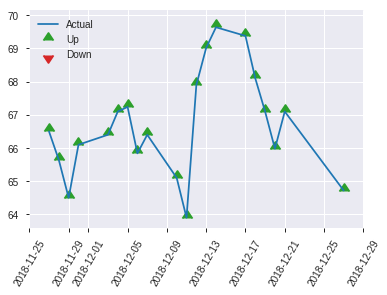


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24151546551259115
RMSE: 0.4914422300867022
LogLoss: 0.6757934252884378
Mean Per-Class Error: 0.40804263565891474
AUC: 0.6036175710594315
pr_auc: 0.6235308941774234
Gini: 0.20723514211886296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4305504858493805: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    113  0.9417   (113.0/120.0)
1      1    128  0.0078   (1.0/129.0)
Total  8    241  0.4578   (114.0/249.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.43055      0.691892  240
max f2                       0.43055      0.845443  240
max f0point5                 0.483307     0.610687  196
max accuracy                 0.525735     0.594378  141
max precision                0.7005       1         0
max recall                   0.383344     1         248
max specificity              0.7005       1         0
max absolute_mcc             0.483307     0.196542  196
max min_per_class_accuracy   0.537899     0.55      124
max mean_per_class_accuracy  0.525735     0.591957  141

Gains/Lift Table: Avg response rate: 51.81 %, avg score: 53.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0120482                   0.679974           1.93023   1.93023            1                0.688941  1                           0.688941            0.0232558       0.0232558                  93.0233   93.0233
    2        0.0200803                   0.673738           1.93023   1.93023            1                0.676613  1                           0.684009            0.0155039       0.0387597                  93.0233   93.0233
    3        0.0321285                   0.660095           1.28682   1.68895            0.666667         0.669598  0.875                       0.678605            0.0155039       0.0542636                  28.6822   68.8953
    4        0.0401606                   0.653517           0.965116  1.54419            0.5              0.656581  0.8                         0.6742              0.00775194      0.0620155                  -3.48837  54.4186
    5        0.0522088                   0.648449           1.28682   1.48479            0.666667         0.651324  0.769231                    0.668921            0.0155039       0.0775194                  28.6822   48.4794
    6        0.100402                    0.618598           1.44767   1.46698            0.75             0.633591  0.76                        0.651963            0.0697674       0.147287                   44.7674   46.6977
    7        0.15261                     0.600643           0.890877  1.26989            0.461538         0.610252  0.657895                    0.637693            0.0465116       0.193798                   -10.9123  26.989
    8        0.200803                    0.594515           1.28682   1.27395            0.666667         0.597948  0.66                        0.628154            0.0620155       0.255814                   28.6822   27.3953
    9        0.301205                    0.575877           0.926512  1.15814            0.48             0.583191  0.6                         0.613167            0.0930233       0.348837                   -7.34884  15.814
    10       0.401606                    0.556999           0.926512  1.10023            0.48             0.567066  0.57                        0.601641            0.0930233       0.44186                    -7.34884  10.0233
    11       0.502008                    0.537899           1.08093   1.09637            0.56             0.547185  0.568                       0.59075             0.108527        0.550388                   8.09302   9.63721
    12       0.598394                    0.51918            1.36725   1.14               0.708333         0.529054  0.590604                    0.580813            0.131783        0.682171                   36.7248   14.0003
    13       0.698795                    0.502161           0.772093  1.08714            0.4              0.510877  0.563218                    0.570764            0.0775194       0.75969                    -22.7907  8.71425
    14       0.799197                    0.482194           1.08093   1.08636            0.56             0.491501  0.562814                    0.560807            0.108527        0.868217                   8.09302   8.6362
    15       0.899598                    0.454369           0.694884  1.04267            0.36             0.468178  0.540179                    0.550469            0.0697674       0.937984                   -30.5116  4.26703
    16       1                           0.383344           0.617674  1                  0.32             0.429738  0.518072                    0.538347            

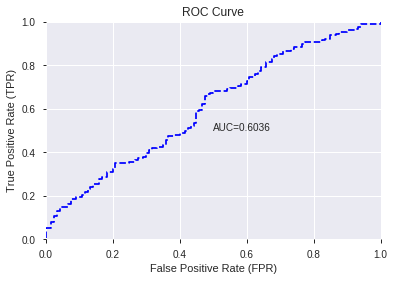

This function is available for GLM models only


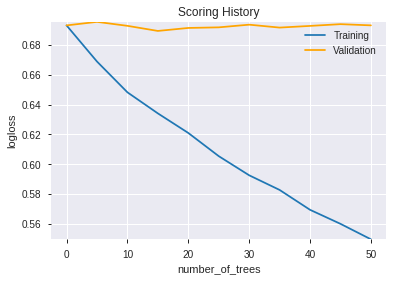

--2019-08-25 13:29:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.100.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.100.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190825_132857',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190825_132857',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_ae65',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_ae65',
   'ty

['BOP',
 'STOCH_slowd',
 'STOCH_slowk',
 'BETA_12',
 'MINUS_DI_8',
 'BETA_14',
 'HT_PHASOR_quadrature',
 'CORREL_12',
 'TRANGE',
 'CCI_12',
 'ADXR_12',
 'MOM_24',
 'WILLR_30',
 'AD',
 'CORREL_8',
 'MFI_30',
 'ULTOSC',
 'MINUS_DI_20',
 'STOCHF_fastk',
 'ADX_24',
 'LINEARREG_ANGLE_8',
 'ADOSC',
 'CCI_30',
 'ROCP_14',
 'MOM_20',
 'ADXR_14',
 'STDDEV_8',
 'ROCP_24',
 'ROCP_20',
 'STDDEV_12',
 'DX_14',
 'STOCHRSI_fastd',
 'ROC_8',
 'MACDEXT_signal',
 'NATR_30',
 'MACD_hist',
 'MOM_14',
 'OBV',
 'WILLR_12',
 'CCI_24',
 'MFI_24',
 'PLUS_DI_14',
 'MACDFIX_signal_20',
 'MFI_14',
 'PLUS_DI_24',
 'MACDFIX_hist_12',
 'NATR_20',
 'BBANDS_lowerband_20_1_5',
 'MINUS_DM_20',
 'NATR_12',
 'MACDFIX_8',
 'WILLR_14',
 'LINEARREG_SLOPE_12',
 'MOM_12',
 'CMO_30',
 'ATR_14',
 'ROCR_24',
 'PLUS_DI_20',
 'ROC_14',
 'MINUS_DI_24',
 'ROC_30',
 'PLUS_DI_8',
 'aroondown_20',
 'ROCP_8',
 'AROONOSC_24',
 'ROCR100_24',
 'ROCR100_8',
 'TRIX_14',
 'CORREL_14',
 'MACDFIX_hist_14',
 'AROONOSC_20',
 'aroondown_30',
 'aroo

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.606
GLM             0.574
XGBoost         0.594
dtype: float64

DeepLearning    GLM  XGBoost
All          0.582  0.570    0.582
DLF          0.590  0.534    0.574
Fwe          0.594  0.570    0.582
RFE          0.606  0.574    0.594
XGBF         0.574  0.534    0.574





F1


DeepLearning    0.691
GLM             0.687
XGBoost         0.692
dtype: float64

DeepLearning    GLM  XGBoost
All          0.683  0.687    0.688
DLF          0.684  0.686    0.686
Fwe          0.691  0.687    0.688
RFE          0.683  0.685    0.692
XGBF         0.686  0.686    0.686





auc


DeepLearning    0.589
GLM             0.564
XGBoost         0.604
dtype: float64

DeepLearning    GLM  XGBoost
All          0.589  0.564    0.603
DLF          0.578  0.492    0.568
Fwe          0.587  0.564    0.603
RFE          0.589  0.553    0.604
XGBF         0.566  0.492    0.568





logloss


DeepLearning    6.098
GLM             0.718
XGBoost         0.701
dtype: float64

DeepLearning    GLM  XGBoost
All          6.098  0.718    0.680
DLF          0.790  0.698    0.701
Fwe          2.411  0.718    0.680
RFE          0.706  0.688    0.676
XGBF         0.796  0.698    0.701





mean_per_class_error


DeepLearning    0.428
GLM             0.472
XGBoost         0.428
dtype: float64

DeepLearning    GLM  XGBoost
All          0.421  0.434    0.411
DLF          0.416  0.472    0.428
Fwe          0.412  0.434    0.411
RFE          0.393  0.422    0.408
XGBF         0.428  0.472    0.428





rmse


DeepLearning    0.675
GLM             0.502
XGBoost         0.504
dtype: float64

DeepLearning    GLM  XGBoost
All          0.675  0.500    0.493
DLF          0.521  0.502    0.504
Fwe          0.644  0.500    0.493
RFE          0.503  0.498    0.491
XGBF         0.541  0.502    0.504





mse


DeepLearning    0.456
GLM             0.252
XGBoost         0.254
dtype: float64

DeepLearning    GLM  XGBoost
All          0.456  0.250    0.244
DLF          0.272  0.252    0.254
Fwe          0.415  0.250    0.244
RFE          0.253  0.248    0.242
XGBF         0.292  0.252    0.254

{'F1':       DeepLearning    GLM  XGBoost
 All          0.683    NaN      NaN
 DLF          0.684    NaN      NaN
 DLF            NaN  0.686      NaN
 DLF            NaN    NaN    0.686
 All            NaN  0.687      NaN
 All            NaN    NaN    0.688
 XGBF         0.686    NaN      NaN
 XGBF           NaN  0.686      NaN
 XGBF           NaN    NaN    0.686
 Fwe          0.691    NaN      NaN
 Fwe            NaN  0.687      NaN
 Fwe            NaN    NaN    0.688
 RFE          0.683    NaN      NaN
 RFE            NaN  0.685      NaN
 RFE            NaN    NaN    0.692,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.582    NaN      NaN
 DLF          0.590    NaN      NaN
 DLF            NaN  0.534      NaN
 DLF            NaN    NaN    0.574
 All            NaN  0.570      NaN
 All            NaN    NaN    0.582
 XGBF         0.574    NaN      NaN
 XGBF           NaN  0.534      NaN
 XGBF           NaN    NaN    0.574
 Fwe          0.594    NaN      NaN
 Fwe     